# Test sistema 1/ sistema 2

Provare sistema con riallenamento da scratch e tuning iperparametri
Verifica incremental learning (cosa esiste)
Codice Geffner
Dominio applicativo

## Informazioni generali
### Sistemi utilizzati
**Sistema 1**: GRNet (LSTM)
**Sistema 2**: PAC+LAMA  
### Domini utilizzati
1. Depots
2. Logistics
3. Blocksworld
4. Zenotravel
### Piani utilizzati
Piani ottimi **Sistema 1** ottenuti con `LAMA` utilizzando l'alias `seq-opt-bjolp`

Piani ottimi **Sistema 2** ottenuti con `LAMA` utilizzando l'euristica `ce-lmcut`
### Metriche utilizzate per il sistema MC
- `output sistema 1`: misura di confidenza, differenza tra lo score del goal scelto e quello del secondo goal con score più alto.
- `precision sistema 1 su test-set`: misura dell'esperienza, media della precisione (calcolata sul test set) per i fatti del goal scelto con predizione maggiore di 0.5.
- `uniqueness`: misura per indicare il rischio, somma normalizzata dei valori di uniqueness del goal scelto. 

Calibration su output (?)
Rischio da discutere


## Imports

In [1]:
import pandas as pd
import json
import os
from os import path
from utils_torch import load_from_folder, save_file
import numpy as np
from utils_unibs.plots import get_line_plot, set_size
from utils_unibs.constants import C
from utils_unibs.plots import plt
from IPython.display import clear_output

## Methods

### General methods

In [2]:
def load_results(target_folder: str): 
    files = np.sort([f for f in os.listdir(target_folder) if f.endswith('.txt')])
    results = load_from_folder(target_folder, files, type=C.TXT)
    return files, results

### Planner methods

In [3]:
def create_df_dict_planner(results_folder: str = '/Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/', verbose: int = 0):
    planner_files, planner_results = load_results(path.join(results_folder, 'planner'))
    df_planner = dict()
    for i, file in enumerate(planner_files):
        df = None
        for l in planner_results[i]:
            json_line = json.loads(l)
            if df is None:
                for l1 in planner_results[i]:
                    json_line1 = json.loads(l1)
                    if 'FD_PLAN_STEPS' in json_line1:
                        columns = list(json_line1.keys())
                    break
                df = pd.DataFrame(columns=columns)

            df.loc[df.shape[0]] = json_line

        df_planner[file.split('.',1)[0]] = df
        if verbose > 0:
            display(df_planner[file.split('.',1)[0]])
    return df_planner

### Network methods

In [4]:
def get_sorted_keys(line: pd.Series, goals_number: int):
    scores_dict = {i : line[f'{i}'] for i in range(goals_number+1)}
    sorted_keys = sorted(scores_dict, key=scores_dict.get, reverse=True)
    return sorted_keys

def create_df_network(results_file: str):
    df = None
    df_scores = None
    df_goals = None
    df_prec = None
    for l in results_file:
        json_line = json.loads(l)
        scores = json_line['SCORES']
        goals = json_line['GOALS']
        prec_scores = json_line['PRED']
        json_line.pop('SCORES')
        json_line.pop('GOALS')
        json_line.pop('PRED')
        if df is None:
            df = pd.DataFrame(json_line, index=[0])
        else:
            df.loc[df.shape[0]] = json_line
        if df_scores is None:
            df_scores = pd.DataFrame(scores, index=[0])
        else:
            df_scores.loc[df_scores.shape[0]] = scores
        if df_goals is None:
            df_goals = pd.DataFrame(goals, index=[0])
        else:
            df_goals.loc[df_goals.shape[0]] = goals
        if df_prec is None:
            df_prec = pd.DataFrame(prec_scores, index=[0])
        else:
            df_prec.loc[df_prec.shape[0]] = prec_scores

    
    df_goals.columns = [f'GOAL_{c}' for c in df_goals.columns]
    df_prec.columns = [f'PREC_{c}' for c in df_prec.columns]
    df = df.join(df_goals)
    df = df.join(df_prec)
    df = df.join(df_scores)
    return df, df_scores.columns

def create_df_dict_network(model_number: int, results_folder: str = '/Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/', verbose: int = 0):
    network_files, network_results = load_results(os.path.join(results_folder, f'model_{model_number}'))
    df_network = dict()
    for i, file in enumerate(network_files):
        df, goals_list = create_df_network(network_results[i])
        df_network[file.split('.',1)[0]] = df
        if verbose > 0:
            c = [f'GOAL_{c}' for c in goals_list if f'GOAL_{c}' in df_network[file.split('.',1)[0]].columns]
            c.extend(goals_list)
            c.extend(['PREDICTED'])
            display(df_network[file.split('.',1)[0]][c])
    return df_network

### MC system methods

In [5]:
def get_planner_metric(df_planner: dict, df_network: dict, unresolved_instances: dict, uncertain_instances: dict, threshold: float, verbose: int = 0):
    tot = 0
    all_metrics = np.zeros((2,))
    for k in unresolved_instances:
        metrics = np.zeros((2,))
        p = k.rsplit('_', 1)[1]
        count = 0

        for domain in uncertain_instances[k]:
            df_problem_planner_final = None
            df_optimal_planner_final = None
            problem_name = domain.split(',', 1)[0].rsplit('-', 1)[1]
            constraint = domain.rsplit('constraint', 1)[1]
            line = df_network[k][df_network[k]['DOMAIN'] == domain].iloc[0]
            actual_goal = df_network[k][df_network[k]['DOMAIN'] == domain]['ACTUAL'].values[0]
            goals_number = int(df_network[k].columns[-1])
            sorted_keys = get_sorted_keys(line, goals_number)
            goals_to_keep = []
            for i, sorted_key in enumerate(sorted_keys):
                if float(line[f'{sorted_keys[0]}']) - float(line[f'{sorted_keys[i]}']) <= threshold:
                    goals_to_keep.append(sorted_key)
            df_problem_planner = df_planner[f'results_{p}']
            df_problem_planner = df_problem_planner[df_problem_planner['INSTANCE'] == problem_name]
            df_problem_planner = df_problem_planner[df_problem_planner['DOMAIN'].str.contains(f"constraint{int(float(constraint)*100) if float(constraint) <= 1 else int(constraint)}")]

            df_optimal_planner = df_planner[f'results_{p}']
            df_optimal_planner = df_optimal_planner[df_optimal_planner['INSTANCE'] == problem_name]
            df_optimal_planner = df_optimal_planner[(df_optimal_planner['SYSTEM'] == "ottimo") | (df_optimal_planner['SYSTEM'] == "fast-downward_HMAX")]
            for goal_to_keep in goals_to_keep:
                if df_problem_planner_final is None:
                    df_problem_planner_final = df_problem_planner[df_problem_planner['DOMAIN'].str.endswith(f"goal_{goal_to_keep}")]
                    df_optimal_planner_final = df_optimal_planner[df_optimal_planner['DOMAIN'].str.endswith(f"goal_{goal_to_keep}")]
                else:
                    df_problem_planner_final = pd.concat([df_problem_planner_final, df_problem_planner[df_problem_planner['DOMAIN'].str.endswith(f"goal_{goal_to_keep}")]])
                    df_optimal_planner_final = pd.concat([df_optimal_planner_final, df_optimal_planner[df_optimal_planner['DOMAIN'].str.endswith(f"goal_{goal_to_keep}")]])
            df_problem_planner = df_problem_planner_final.sort_values(by=['DOMAIN'])
            df_optimal_planner = df_optimal_planner_final.sort_values(by=['DOMAIN'])
            time = np.sum(df_problem_planner['TOTALRUNTIME']) + np.sum(df_optimal_planner['TOTALRUNTIME'])
            
            if k == 'network_results_test_plans_p05':
                if actual_goal > 6:
                    actual_goal -= 2
                elif actual_goal > 2:
                    actual_goal -= 1

            min_value_idx = df_problem_planner['FD_PLAN_STEPS'].reset_index(drop=True).sub(df_optimal_planner['FD_PLAN_STEPS'].reset_index(drop=True))
            min_value_idx.index = df_problem_planner.index
            min_value_idx = min_value_idx[min_value_idx == 0]
            if min_value_idx.shape[0] > 0 and not(np.isnan(min_value_idx.idxmin())):
                min_value_idx = min_value_idx.index
                pred_goals = []
                for ind in min_value_idx:
                    pred_goal = df_problem_planner.loc[ind]['DOMAIN'].rsplit('_',1)[1]
                    pred_goals.append(int(pred_goal))
                if int(actual_goal) in pred_goals:
                    metrics[0] += 1/len(pred_goals)
            else:
                goals_number = int(list(df_network[k].columns)[-1])
                pred_goal = [np.random.randint(0, goals_number)]
            metrics[1] += time
            count +=1

        for domain in unresolved_instances[k]:
            problem_name = domain.split(',', 1)[0].rsplit('-', 1)[1]
            constraint = domain.rsplit('constraint', 1)[1]
            df_problem_planner = df_planner[f'results_{p}']
            df_problem_planner = df_problem_planner[df_problem_planner['INSTANCE'] == problem_name]
            df_problem_planner = df_problem_planner[df_problem_planner['DOMAIN'].str.contains(f"constraint{int(float(constraint)*100) if float(constraint) <= 1 else int(constraint)}")]
            df_problem_planner = df_problem_planner.sort_values(by=['DOMAIN'])
            df_optimal_planner = df_planner[f'results_{p}']
            df_optimal_planner = df_optimal_planner[df_optimal_planner['INSTANCE'] == problem_name]
            df_optimal_planner = df_optimal_planner[(df_optimal_planner['SYSTEM'] == "ottimo") | (df_optimal_planner['SYSTEM'] == "fast-downward_HMAX")]
            df_optimal_planner = df_optimal_planner.sort_values(by=['DOMAIN'])
            time = np.sum(df_problem_planner['TOTALRUNTIME']) + np.sum(df_optimal_planner['TOTALRUNTIME'])
            actual_goal = df_network[k][df_network[k]['DOMAIN'] == domain]['ACTUAL'].values[0]

            if k == 'network_results_test_plans_p05':
                if actual_goal > 6:
                    actual_goal -= 2
                elif actual_goal > 2:
                    actual_goal -= 1

            min_value_idx = df_problem_planner['FD_PLAN_STEPS'].reset_index(drop=True).sub(df_optimal_planner['FD_PLAN_STEPS'].reset_index(drop=True))
            min_value_idx.index = df_problem_planner.index
            min_value_idx = min_value_idx[min_value_idx == 0]
            if min_value_idx.shape[0] > 0 and not(np.isnan(min_value_idx.idxmin())):
                min_value_idx = min_value_idx.index
                pred_goals = []
                for ind in min_value_idx:
                    pred_goal = df_problem_planner.loc[ind]['DOMAIN'].rsplit('_',1)[1]
                    pred_goals.append(int(pred_goal))
                if int(actual_goal) in pred_goals:
                    metrics[0] += 1/len(pred_goals)
            else:
                goals_number = int(list(df_network[k].columns)[-1])
                pred_goal = [np.random.randint(0, goals_number)]
            metrics[1] += time
            count +=1
        if verbose:
            print(f'{k}: Precision: {metrics[0]/count*100 : .2f}, Time: {metrics[1]/count : .2f}')
            print('=========================')
        all_metrics += metrics
        tot += count
    return all_metrics, tot

In [6]:
def get_sorted_keys(line: pd.Series, goals_number: int):
    scores_dict = {i : line[f'{i}'] for i in range(goals_number+1)}
    sorted_keys = sorted(scores_dict, key=scores_dict.get, reverse=True)
    return sorted_keys

def get_confidence(line: pd.Series, goals_number: int, confidence_threshold: float, sorted_keys: list):
    is_confident = float(line[f'{sorted_keys[0]}']) - float(line[f'{sorted_keys[1]}']) > confidence_threshold
    return is_confident

def get_risk_free(line: pd.Series, goals_number: int, uniqueness_threshold: float, sorted_keys: list):
    goals_dict = {i : line[f'GOAL_{i}'].split(' ') if f'GOAL_{i}' in line.index else [] for i in range(goals_number+1)}
    uniq_dict = {}
    for k in goals_dict.keys():
        for el in goals_dict[k]:
            if el in uniq_dict:
                uniq_dict[el] += 1
            else:
                uniq_dict[el] = 1
    uniq_dict = {k: 1/uniq_dict[k] for k in uniq_dict.keys()}
    is_risk_free = sum([uniq_dict[k] for k in goals_dict[sorted_keys[0]]])/ sum([1 for k,g in goals_dict.items() if g != []]) > uniqueness_threshold
    return is_risk_free

def get_precision(line: pd.Series, goals_number: int, precision_threshold: float, sorted_keys: list):
    prec_dict = {i : float(line[f'PREC_{i}']) for i in range(goals_number+1)}
    is_precise = prec_dict[sorted_keys[0]] >= precision_threshold
    return is_precise

def get_counts(metrics, predicted, time):
    out = []
    # Add the value for all the metrics in and
    metrics.append(True)
    for m in metrics:
        counts = np.zeros((3,), dtype=float)
        if m:
            counts[0] = 1
            counts[2] = time
            if predicted == True:
                counts[1] = 1
        else:
            metrics[-1] = False
        
        out.append(counts)
    return out

def get_metric(df_dictionary: dict, thresholds: list, verbose: int = 0, metrics_labels = ['Confidence', 'Risk Free', 'Precise', 'Confidence AND Risk Free AND Precise']):
    all_metrics = np.zeros((len(metrics_labels), 3))
    tot = 0
    unsolved_instances = {}
    uncertain_instances = {}
    for key in df_dictionary.keys():
        df_unresolved_instances = []
        df_uncertain_instances = []
        metrics = np.zeros((len(metrics_labels), 3))
        df = df_dictionary[key]
        indexes = list(range(0, df.shape[0]))
        np.random.seed(420)
        np.random.shuffle(indexes)
        for l in range(df.shape[0]):
            line = df.iloc[indexes[l]]
            goals_number = int(df.columns[-1])
            sorted_keys = get_sorted_keys(line, goals_number)
            res = []
            for i, m in enumerate(metrics_labels):
                if m == 'Confidence' :
                    is_confident = get_confidence(line, goals_number, thresholds[i], sorted_keys)
                    res.append(is_confident)
                if m == 'Risk Free':
                    is_risk_free = get_risk_free(line, goals_number, thresholds[i], sorted_keys)
                    res.append(is_risk_free)
                if m == 'Precise':
                    is_precise = get_precision(line, goals_number, thresholds[i], sorted_keys)
                    res.append(is_precise)
            predicted = line['PREDICTED']
            counts = get_counts(res, predicted, line['TOTALRUNTIME'])
            is_sample_uncertain = False
            if 'Confidence' in metrics_labels and 'Precise' in metrics_labels:
                conf_index = metrics_labels.index('Confidence')
                prec_index = metrics_labels.index('Precise')
                if counts[conf_index][0] == 0 and counts[prec_index][0] == 1:
                    is_sample_uncertain = True
                    df_uncertain_instances.append(line['DOMAIN'])
            if counts[-1][0] == 0 and not(is_sample_uncertain):
                df_unresolved_instances.append(line['DOMAIN'])
            metrics += counts
        unsolved_instances[key] = df_unresolved_instances
        uncertain_instances[key] = df_uncertain_instances
            
        if verbose > 0:
            print(f'{key}:')
            for i, m in enumerate(metrics):
                print(f'{metrics_labels[i]}: Plan percentage: {m[0]/(l+1)*100 :.2f}, Precision: {m[1]/m[0]*100 :.2f}')
            print('=========================')
        all_metrics += metrics
        tot += l+1
    return all_metrics, tot, unsolved_instances, uncertain_instances
            

def get_metrics_in_range(df_dict: dict, target_metric: int, range: list, verbose: int = 0, metrics_labels = ['Confidence', 'Risk Free', 'Precise', 'Confidence AND Risk Free AND Precise']):
    x, y_metric, y_pred_metric = range, [], []
    thresholds = np.zeros((len(metrics_labels)-1,))
    for target_threshold in range:
        thresholds[target_metric] = target_threshold
        all_metrics, tot, unresolved_instances, uncertain_instances = get_metric(df_dict, thresholds, verbose, metrics_labels)
        y_metric.append(all_metrics[target_metric][0]/tot*100)
        y_pred_metric.append(all_metrics[target_metric][1]/all_metrics[target_metric][0]*100)
    return x, y_metric, y_pred_metric


def get_metrics_for_models(models_list: list, thresholds: list, results_folder: str = '/Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/',use_planner: bool = True, verbose: int = 0, metrics_labels = ['Confidence', 'Risk Free', 'Precise', 'Confidence AND Risk Free AND Precise']):
    x = models_list
    network_plan_percentages = [[] for i in range(len(metrics_labels))]
    planner_plan_percentages = []
    network_precisions = [[] for i in range(len(metrics_labels))]
    only_network_precisions = []
    planner_precisions = []
    network_times = [[] for i in range(len(metrics_labels))]
    only_network_times = []
    planner_times = []

    if use_planner:
        df_planner_dict = create_df_dict_planner(results_folder, verbose=verbose)

    for model_number in models_list:
        print(f'Model {model_number}')
        if verbose > 0:
            print('Network statistics:')
        df_network_dict = create_df_dict_network(model_number, results_folder=results_folder, verbose=verbose)
        network_only_metrics, network_only_instances, unresolved_instances, uncertain_instances = get_metric(df_network_dict, [0], verbose, ['Confidence', 'C1'])
        only_network_precisions.append(network_only_metrics[0][1]/network_only_metrics[0][0]*100)
        only_network_times.append(network_only_metrics[0][2]/network_only_metrics[0][0])
        network_metrics, network_instances, unresolved_instances, uncertain_instances = get_metric(df_network_dict, thresholds, verbose, metrics_labels)
        for i, m in enumerate(metrics_labels):
            plan_percentage = network_metrics[i][0]/network_instances*100
            precision = network_metrics[i][1]/network_metrics[i][0]*100
            time = network_metrics[i][2]/network_metrics[i][0]
            network_plan_percentages[i].append(plan_percentage)
            network_precisions[i].append(precision)
            network_times[i].append(time)
            if verbose > 0:
                print(f'{m}: Plan percentage: {plan_percentage :.2f}, Precision: {precision :.2f}')     
                print('=========================')
        if use_planner:
            conf_index = metrics_labels.index('Confidence')
            planner_metrics, planner_instances = get_planner_metric(df_planner_dict, df_network_dict, unresolved_instances, uncertain_instances, thresholds[conf_index], verbose=verbose)
            plan_percentage = 100-plan_percentage
            precision = planner_metrics[0]/planner_instances*100
            time = planner_metrics[1]/planner_instances
            planner_plan_percentages.append(plan_percentage)
            planner_precisions.append(precision)
            planner_times.append(time)
        

    return x, network_plan_percentages, network_precisions, network_times, planner_plan_percentages, planner_precisions, planner_times, only_network_precisions, only_network_times

In [7]:
results_folder = '../datasets/gr_logistics/results/results_jsons'
target_model = 16
r_confidence = np.arange(0.00, 1, 0.01)
r_precision = np.arange(0.00, 1, 0.01)
r_risk = np.arange(0.00, 1, 0.01)

In [9]:
df_planner = create_df_dict_planner(results_folder, verbose=1)

results_p01.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p02.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p03.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p04.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p05.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p06.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p07.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p001666,classic_goal_6,ottimo,classic_goal_6_p001666.sol,NoValidationPerformed,NaN,0.45,0.047,8,0.018763,11.0
1,p006744,classic_goal_7,ottimo,classic_goal_7_p006744.sol,NoValidationPerformed,NaN,0.28,0.023,6,0.023122,7.0
2,p008429,classic_goal_7,ottimo,classic_goal_7_p008429.sol,NoValidationPerformed,NaN,0.39,0.059,7,0.023326,8.0
3,p006824,classic_goal_0,ottimo,classic_goal_0_p006824.sol,NoValidationPerformed,NaN,0.28,0.025,10,0.021020,11.0
4,p009543,classic_goal_3,ottimo,classic_goal_3_p009543.sol,NoValidationPerformed,NaN,0.31,0.023,15,0.022152,91.0
...,...,...,...,...,...,...,...,...,...,...,...
3915,p008904,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p008904.sol,NoValidationPerformed,NaN,1.31,0.078,26,0.760431,NaN
3916,p004160,constraints_constraint50_goal_7,pac_ottimo,constraints_constraint50_goal_7_p004160.sol,NoValidationPerformed,NaN,1.53,0.081,22,0.808418,NaN
3917,p008989,constraints_constraint50_goal_7,pac_ottimo,constraints_constraint50_goal_7_p008989.sol,NoValidationPerformed,NaN,1.51,0.079,23,1.123140,NaN
3918,p000792,constraints_constraint50_goal_7,pac_ottimo,constraints_constraint50_goal_7_p000792.sol,NoValidationPerformed,NaN,1.91,0.125,30,1.348470,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p013325,classic_goal_5,ottimo,classic_goal_5_p013325.sol,NoValidationPerformed,NaN,0.33,0.024,4,0.015947,5.0
1,p010321,classic_goal_7,ottimo,classic_goal_7_p010321.sol,NoValidationPerformed,NaN,0.34,0.026,8,0.018188,11.0
2,p011607,classic_goal_5,ottimo,classic_goal_5_p011607.sol,NoValidationPerformed,NaN,0.30,0.023,15,0.018144,67.0
3,p015247,classic_goal_0,ottimo,classic_goal_0_p015247.sol,NoValidationPerformed,NaN,0.29,0.023,15,0.018334,64.0
4,p013690,classic_goal_6,ottimo,classic_goal_6_p013690.sol,NoValidationPerformed,NaN,0.42,0.033,20,0.023726,128.0
...,...,...,...,...,...,...,...,...,...,...,...
3875,p017320,constraints_constraint50_goal_7,pac_ottimo,constraints_constraint50_goal_7_p017320.sol,NoValidationPerformed,NaN,1.51,0.077,16,0.810783,NaN
3876,p019559,constraints_constraint50_goal_7,pac_ottimo,constraints_constraint50_goal_7_p019559.sol,NoValidationPerformed,NaN,1.40,0.087,14,0.948225,NaN
3877,p015950,constraints_constraint50_goal_7,pac_ottimo,constraints_constraint50_goal_7_p015950.sol,NoValidationPerformed,NaN,2.92,0.460,27,1.222600,NaN
3878,p015086,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p015086.sol,NoValidationPerformed,NaN,2.24,0.081,28,1.381610,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p039758,classic_goal_5,ottimo,classic_goal_5_p039758.sol,NoValidationPerformed,NaN,0.37,0.052,15,0.022059,176.0
1,p033894,classic_goal_0,ottimo,classic_goal_0_p033894.sol,NoValidationPerformed,NaN,0.27,0.026,15,0.017945,217.0
2,p031413,classic_goal_1,ottimo,classic_goal_1_p031413.sol,NoValidationPerformed,NaN,0.38,0.056,7,0.018279,9.0
3,p030650,classic_goal_1,ottimo,classic_goal_1_p030650.sol,NoValidationPerformed,NaN,0.27,0.026,4,0.013822,5.0
4,p037544,classic_goal_0,ottimo,classic_goal_0_p037544.sol,NoValidationPerformed,NaN,0.28,0.025,6,0.013656,7.0
...,...,...,...,...,...,...,...,...,...,...,...
3875,p030948,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p030948.sol,NoValidationPerformed,NaN,1.52,0.147,20,0.939378,NaN
3876,p035497,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p035497.sol,NoValidationPerformed,NaN,2.01,0.113,33,1.245830,NaN
3877,p039758,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p039758.sol,NoValidationPerformed,NaN,2.44,0.104,29,1.626840,NaN
3878,p032342,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p032342.sol,NoValidationPerformed,NaN,4.10,0.343,27,2.223570,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p025803,classic_goal_9,ottimo,NO SOLUTION,NaN,NaN,1.59,NaN,NaN,NaN,NaN
1,p020675,classic_goal_11,ottimo,NO SOLUTION,NaN,NaN,1.63,NaN,NaN,NaN,NaN
2,p026375,classic_goal_5,ottimo,NO SOLUTION,NaN,NaN,1.59,NaN,NaN,NaN,NaN
3,p029867,classic_goal_6,ottimo,classic_goal_6_p029867.sol,NoValidationPerformed,NaN,31.96,0.797,15.0,29.4579,194923.0
4,p023146,classic_goal_4,ottimo,classic_goal_4_p023146.sol,NoValidationPerformed,NaN,70.43,0.900,16.0,67.1729,354587.0
...,...,...,...,...,...,...,...,...,...,...,...
2539,p028189,constraints_constraint50_goal_2,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN
2540,p025167,constraints_constraint50_goal_0,pac_ottimo,constraints_constraint50_goal_0_p025167.sol,NoValidationPerformed,NaN,1454.12,3.919,45.0,1449.6100,137908.0
2541,p027788,constraints_constraint50_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.01,NaN,NaN,NaN,NaN
2542,p029830,constraints_constraint50_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p052158,classic_goal_6,ottimo,classic_goal_6_p052158.sol,NoValidationPerformed,NaN,3.23,0.172,20.0,0.159316,2981.0
1,p050582,classic_goal_0,ottimo,NO SOLUTION,NaN,NaN,3.24,NaN,NaN,NaN,NaN
2,p054378,classic_goal_7,ottimo,NO SOLUTION,NaN,NaN,3.19,NaN,NaN,NaN,NaN
3,p058031,classic_goal_3,ottimo,NO SOLUTION,NaN,NaN,2.97,NaN,NaN,NaN,NaN
4,p051181,classic_goal_4,ottimo,NO SOLUTION,NaN,NaN,3.13,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3915,p059786,constraints_constraint70_goal_9,pac_ottimo,constraints_constraint70_goal_9_p059786.sol,NoValidationPerformed,NaN,715.51,0.596,39.0,713.684000,NaN
3916,p059807,constraints_constraint70_goal_9,pac_ottimo,constraints_constraint70_goal_9_p059807.sol,NoValidationPerformed,NaN,192.55,0.619,35.0,191.275000,NaN
3917,p059918,constraints_constraint70_goal_9,pac_ottimo,NO SOLUTION,NaN,NaN,0.29,NaN,NaN,NaN,NaN
3918,p059712,constraints_constraint70_goal_6,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p041989,classic_goal_3,ottimo,NO SOLUTION,NaN,NaN,3.46,NaN,NaN,NaN,NaN
1,p048766,classic_goal_9,ottimo,NO SOLUTION,NaN,NaN,3.35,NaN,NaN,NaN,NaN
2,p040518,classic_goal_3,ottimo,NO SOLUTION,NaN,NaN,3.42,NaN,NaN,NaN,NaN
3,p040964,classic_goal_6,ottimo,classic_goal_6_p040964.sol,NoValidationPerformed,NaN,3.52,0.738,13.0,0.10011,1802.0
4,p048766,classic_goal_1,ottimo,classic_goal_1_p048766.sol,NoValidationPerformed,NaN,3.63,0.680,13.0,0.18556,1594.0
...,...,...,...,...,...,...,...,...,...,...,...
4747,p041610,constraints_constraint50_goal_7,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN
4748,p045440,constraints_constraint70_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN
4749,p045452,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p045452.sol,NoValidationPerformed,NaN,11.31,1.670,33.0,9.32908,2801.0
4750,p045503,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p045503.sol,NoValidationPerformed,NaN,25.89,1.553,31.0,24.03290,9117.0


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p064907,classic_goal_5,ottimo,NO SOLUTION,NaN,NaN,6.73,NaN,NaN,NaN,NaN
1,p064907,classic_goal_2,ottimo,NO SOLUTION,NaN,NaN,7.13,NaN,NaN,NaN,NaN
2,p064907,classic_goal_6,ottimo,NO SOLUTION,NaN,NaN,6.86,NaN,NaN,NaN,NaN
3,p064907,classic_goal_3,ottimo,NO SOLUTION,NaN,NaN,7.10,NaN,NaN,NaN,NaN
4,p064907,classic_goal_9,ottimo,NO SOLUTION,NaN,NaN,6.91,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4603,p068638,constraints_constraint50_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN
4604,p061348,constraints_constraint70_goal_9,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN
4605,p068618,constraints_constraint70_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN
4606,p062404,constraints_constraint50_goal_2,pac_ottimo,NO SOLUTION,NaN,NaN,1800.01,NaN,NaN,NaN,NaN


In [10]:
df_network = create_df_dict_network(model_number=16, verbose=1, results_folder=results_folder)

network_results_test_plans_p01.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_16
network_results_test_plans_p02.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_16
network_results_test_plans_p03.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_16
network_results_test_plans_p04.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_16
network_results_test_plans_p05.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_16
network_results_test_plans_p06.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_16
network_results_test_plans_p07.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_16


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,1,2,3,4,5,6,7,8,9,PREDICTED
0,29 147,60 100,18 67,15 147,29 54,3 15,60 66,11 49,6 46,15 46,...,0.00169,0.00118,0.02299,0.00425,0.02299,0.00172,0.03113,0.09799,0.08470,False
1,29 147,60 100,18 67,15 147,29 54,3 15,60 66,11 49,6 46,15 46,...,0.01340,0.03042,0.03456,0.02958,0.04766,0.01030,0.05790,0.06131,0.06066,False
2,29 147,60 100,18 67,15 147,29 54,3 15,60 66,11 49,6 46,15 46,...,0.01696,0.04971,0.22506,0.01078,0.23121,0.00781,0.00547,0.00178,0.22407,False
3,29 147,60 100,18 67,15 147,29 54,3 15,60 66,11 49,6 46,15 46,...,0.00744,0.00408,0.00883,0.73475,0.00858,0.00050,0.00032,0.00184,0.00903,False
4,29 147,60 100,18 67,15 147,29 54,3 15,60 66,11 49,6 46,15 46,...,0.00428,0.01088,0.00555,0.00259,0.00306,0.00832,0.02502,0.15825,0.01015,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,29 147,60 100,18 67,15 147,29 54,3 15,60 66,11 49,6 46,15 46,...,0.00598,0.00019,0.60594,0.00069,0.47041,0.00192,0.01334,0.00271,0.46993,True
584,29 147,60 100,18 67,15 147,29 54,3 15,60 66,11 49,6 46,15 46,...,0.00169,0.00158,0.01179,0.00221,0.01368,0.00121,0.00233,0.13317,0.01363,False
585,29 147,60 100,18 67,15 147,29 54,3 15,60 66,11 49,6 46,15 46,...,0.02053,0.01698,0.43547,0.00261,0.43592,0.00138,0.00341,0.00610,0.43539,False
586,29 147,60 100,18 67,15 147,29 54,3 15,60 66,11 49,6 46,15 46,...,0.00144,0.00232,0.00099,0.05000,0.00131,0.00166,0.00228,0.00797,0.00855,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,1,2,3,4,5,6,7,8,9,PREDICTED
0,3 6,15 66,11 94,15 100,54 121,3 15,54 60,6 46,6 54,3 49,...,0.03327,0.08003,0.03558,0.01473,0.03695,0.00792,0.17464,0.17755,0.01515,False
1,3 6,15 66,11 94,15 100,54 121,3 15,54 60,6 46,6 54,3 49,...,0.00913,0.34563,0.01569,0.95916,0.00874,0.95303,0.02389,0.95819,0.01175,False
2,3 6,15 66,11 94,15 100,54 121,3 15,54 60,6 46,6 54,3 49,...,0.00031,0.00471,0.00125,0.00495,0.40059,0.02938,0.01329,0.01370,0.40393,False
3,3 6,15 66,11 94,15 100,54 121,3 15,54 60,6 46,6 54,3 49,...,0.22873,0.06689,0.04087,0.00575,0.02810,0.00327,0.21325,0.15356,0.02608,False
4,3 6,15 66,11 94,15 100,54 121,3 15,54 60,6 46,6 54,3 49,...,0.37495,0.00200,0.00423,0.00188,0.00152,0.00255,0.00394,0.00124,0.00642,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,3 6,15 66,11 94,15 100,54 121,3 15,54 60,6 46,6 54,3 49,...,0.19650,0.00678,0.18968,0.06233,0.18851,0.05711,0.00101,0.05715,0.00094,False
578,3 6,15 66,11 94,15 100,54 121,3 15,54 60,6 46,6 54,3 49,...,0.02120,0.00316,0.01920,0.00005,0.01698,0.00007,0.00037,0.00011,0.00649,False
579,3 6,15 66,11 94,15 100,54 121,3 15,54 60,6 46,6 54,3 49,...,0.00501,0.00239,0.00451,0.77138,0.00219,0.76201,0.00089,0.76234,0.00030,False
580,3 6,15 66,11 94,15 100,54 121,3 15,54 60,6 46,6 54,3 49,...,0.00383,0.99987,0.00266,0.00457,0.00075,0.00170,0.00424,0.00368,0.09221,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,1,2,3,4,5,6,7,8,9,PREDICTED
0,29 46,20 60,67 127,94 110,54 125,66 127,94 100,11 125,18 147,49 110,...,0.02111,0.00371,0.00543,0.13948,0.00565,0.01559,0.13519,0.00652,0.02367,False
1,29 46,20 60,67 127,94 110,54 125,66 127,94 100,11 125,18 147,49 110,...,0.00214,0.00780,0.00211,0.00612,0.00682,0.00271,0.00613,0.00053,0.00545,True
2,29 46,20 60,67 127,94 110,54 125,66 127,94 100,11 125,18 147,49 110,...,0.00342,0.00831,0.00377,0.00365,0.00436,0.00326,0.00415,0.00345,0.02475,False
3,29 46,20 60,67 127,94 110,54 125,66 127,94 100,11 125,18 147,49 110,...,0.00451,0.00934,0.89603,0.00731,0.00580,1.11418,0.00733,0.03768,0.00016,True
4,29 46,20 60,67 127,94 110,54 125,66 127,94 100,11 125,18 147,49 110,...,0.00576,0.08649,0.00098,0.00500,0.07181,0.00084,0.00390,0.00264,0.00619,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,29 46,20 60,67 127,94 110,54 125,66 127,94 100,11 125,18 147,49 110,...,0.09103,0.00311,0.06038,0.01289,0.00055,0.00261,0.07050,0.01646,0.07356,False
578,29 46,20 60,67 127,94 110,54 125,66 127,94 100,11 125,18 147,49 110,...,0.01314,0.01573,0.58006,0.00058,0.00048,0.58165,0.00124,0.00106,0.03008,True
579,29 46,20 60,67 127,94 110,54 125,66 127,94 100,11 125,18 147,49 110,...,0.04101,0.01479,0.05413,0.00150,0.01258,0.00521,0.13559,0.03440,0.05660,False
580,29 46,20 60,67 127,94 110,54 125,66 127,94 100,11 125,18 147,49 110,...,0.07875,0.13890,0.01096,0.02241,0.13826,0.00558,0.01908,0.00194,0.01117,False


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,3,4,5,6,7,8,9,10,11,PREDICTED
0,28 29 46 150,11 41 60 118,18 19 108 133,38 94 110 128,54 118 125 150,1 15 66 85,38 41 94 100,11 76 118 125,15 44 93 115,1 21 94 110,...,0.02451,0.00487,0.05522,0.07874,0.01171,0.00119,0.07735,0.02866,0.00599,False
1,28 29 46 150,11 41 60 118,18 19 108 133,38 94 110 128,54 118 125 150,1 15 66 85,38 41 94 100,11 76 118 125,15 44 93 115,1 21 94 110,...,0.05481,0.75022,0.01726,0.00683,0.68137,0.07208,0.06241,0.67761,0.69797,False
2,28 29 46 150,11 41 60 118,18 19 108 133,38 94 110 128,54 118 125 150,1 15 66 85,38 41 94 100,11 76 118 125,15 44 93 115,1 21 94 110,...,0.02963,0.09450,0.03324,0.03590,0.62731,0.01532,0.03734,0.57345,0.02637,True
3,28 29 46 150,11 41 60 118,18 19 108 133,38 94 110 128,54 118 125 150,1 15 66 85,38 41 94 100,11 76 118 125,15 44 93 115,1 21 94 110,...,0.08936,0.04068,0.01485,0.00741,0.05133,0.03324,0.07682,0.01950,0.01686,True
4,28 29 46 150,11 41 60 118,18 19 108 133,38 94 110 128,54 118 125 150,1 15 66 85,38 41 94 100,11 76 118 125,15 44 93 115,1 21 94 110,...,0.00673,0.00232,0.01357,0.21875,0.02495,0.00369,0.00981,0.23869,0.00031,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,28 29 46 150,11 41 60 118,18 19 108 133,38 94 110 128,54 118 125 150,1 15 66 85,38 41 94 100,11 76 118 125,15 44 93 115,1 21 94 110,...,0.03295,0.13143,0.00563,0.00389,0.06728,0.00238,0.03671,0.00143,0.00336,False
314,28 29 46 150,11 41 60 118,18 19 108 133,38 94 110 128,54 118 125 150,1 15 66 85,38 41 94 100,11 76 118 125,15 44 93 115,1 21 94 110,...,0.07003,0.03054,0.00357,0.48660,0.01761,0.01378,0.07453,0.01306,0.00241,False
315,28 29 46 150,11 41 60 118,18 19 108 133,38 94 110 128,54 118 125 150,1 15 66 85,38 41 94 100,11 76 118 125,15 44 93 115,1 21 94 110,...,1.12920,0.01261,0.00030,1.11292,0.00081,0.00605,1.09648,0.13999,0.00052,True
316,28 29 46 150,11 41 60 118,18 19 108 133,38 94 110 128,54 118 125 150,1 15 66 85,38 41 94 100,11 76 118 125,15 44 93 115,1 21 94 110,...,0.03483,0.00711,0.65916,0.03344,0.30100,0.04160,0.66085,0.03208,0.00105,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,1,2,3,4,5,6,7,8,9,PREDICTED
0,29 46,20 60,94 110,54 125,94 100,11 125,18 147,49 110,90 148,118 147,...,0.93165,0.00681,0.00075,0.00680,0.00028,0.01320,0.00229,0.00484,0.01426,True
1,29 46,20 60,94 110,54 125,94 100,11 125,18 147,49 110,90 148,118 147,...,0.00981,0.06555,0.02168,0.08214,0.02162,0.01221,0.01257,0.02468,0.02555,False
2,29 46,20 60,94 110,54 125,94 100,11 125,18 147,49 110,90 148,118 147,...,0.04882,0.00386,0.01641,0.00992,0.06486,0.03341,0.01492,0.00282,0.01457,True
3,29 46,20 60,94 110,54 125,94 100,11 125,18 147,49 110,90 148,118 147,...,0.28263,0.06648,0.16110,0.01318,0.15030,0.09338,0.08649,0.08277,0.07259,False
4,29 46,20 60,94 110,54 125,94 100,11 125,18 147,49 110,90 148,118 147,...,0.00036,0.99715,0.00253,1.00083,0.00056,0.00262,0.00372,0.00094,0.00284,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,29 46,20 60,94 110,54 125,94 100,11 125,18 147,49 110,90 148,118 147,...,0.00085,0.01142,0.00114,0.01142,0.00108,0.10163,0.00079,0.00539,0.00045,True
584,29 46,20 60,94 110,54 125,94 100,11 125,18 147,49 110,90 148,118 147,...,0.00366,0.07573,0.00121,0.07861,0.00165,0.00037,0.00250,0.00018,0.01199,True
585,29 46,20 60,94 110,54 125,94 100,11 125,18 147,49 110,90 148,118 147,...,0.00466,0.03370,0.00332,0.14004,0.00325,0.00431,0.00201,0.00132,0.00586,True
586,29 46,20 60,94 110,54 125,94 100,11 125,18 147,49 110,90 148,118 147,...,0.00044,0.00670,0.02075,0.00605,0.01858,0.80329,0.00093,0.00648,0.74302,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,3,4,5,6,7,8,9,10,11,PREDICTED
0,29 46 90,20 60 118,18 35 54,90 94 110,54 118 125,15 66 82,90 94 100,11 118 125,18 41 147,49 90 110,...,0.26092,0.57386,0.18344,0.17036,0.32608,0.25239,0.41750,0.18421,0.20708,False
1,29 46 90,20 60 118,18 35 54,90 94 110,54 118 125,15 66 82,90 94 100,11 118 125,18 41 147,49 90 110,...,0.02399,0.11139,0.02645,0.03440,0.09545,0.11977,0.02161,0.02855,0.14077,False
2,29 46 90,20 60 118,18 35 54,90 94 110,54 118 125,15 66 82,90 94 100,11 118 125,18 41 147,49 90 110,...,0.16467,0.01530,0.03621,0.16452,0.02032,0.43673,0.03092,0.03541,0.02863,False
3,29 46 90,20 60 118,18 35 54,90 94 110,54 118 125,15 66 82,90 94 100,11 118 125,18 41 147,49 90 110,...,0.12214,0.01225,0.01254,0.11130,0.01026,0.03271,0.37535,0.11468,0.01067,True
4,29 46 90,20 60 118,18 35 54,90 94 110,54 118 125,15 66 82,90 94 100,11 118 125,18 41 147,49 90 110,...,0.21041,0.00503,0.00403,0.22350,0.00542,0.02276,0.21267,0.20934,0.00227,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,29 46 90,20 60 118,18 35 54,90 94 110,54 118 125,15 66 82,90 94 100,11 118 125,18 41 147,49 90 110,...,0.00895,0.00812,0.02022,0.00537,0.01053,0.74803,0.04946,0.01137,0.74162,False
590,29 46 90,20 60 118,18 35 54,90 94 110,54 118 125,15 66 82,90 94 100,11 118 125,18 41 147,49 90 110,...,0.00223,0.00104,0.00202,0.03947,0.00033,0.03075,0.00828,0.00368,0.00776,False
591,29 46 90,20 60 118,18 35 54,90 94 110,54 118 125,15 66 82,90 94 100,11 118 125,18 41 147,49 90 110,...,0.04967,0.01574,0.00129,0.05046,0.00458,0.00139,0.03528,0.03771,0.00509,True
592,29 46 90,20 60 118,18 35 54,90 94 110,54 118 125,15 66 82,90 94 100,11 118 125,18 41 147,49 90 110,...,0.00494,0.98235,0.00041,0.00968,0.98676,0.00019,0.00488,0.01906,0.97927,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,3,4,5,6,7,8,9,10,11,PREDICTED
0,29 38 46,11 60 118,18 19 133,38 94 110,54 118 125,1 15 66,38 94 100,11 118 125,15 41 44,21 94 110,...,0.00624,0.00239,0.00318,0.03857,0.00247,0.10832,0.04733,0.03289,0.13501,True
1,29 38 46,11 60 118,18 19 133,38 94 110,54 118 125,1 15 66,38 94 100,11 118 125,15 41 44,21 94 110,...,0.01721,0.00286,0.02367,0.00854,0.00334,0.18051,0.03257,0.00744,0.02092,True
2,29 38 46,11 60 118,18 19 133,38 94 110,54 118 125,1 15 66,38 94 100,11 118 125,15 41 44,21 94 110,...,0.49259,0.03170,0.00917,0.05942,0.01338,0.00500,0.49031,0.05833,0.02312,False
3,29 38 46,11 60 118,18 19 133,38 94 110,54 118 125,1 15 66,38 94 100,11 118 125,15 41 44,21 94 110,...,0.02320,0.05481,0.00117,0.02214,0.00942,0.00357,0.01883,0.02351,0.00766,False
4,29 38 46,11 60 118,18 19 133,38 94 110,54 118 125,1 15 66,38 94 100,11 118 125,15 41 44,21 94 110,...,0.00489,0.09024,0.03094,0.00416,0.02169,0.01751,0.00676,0.00353,0.11152,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571,29 38 46,11 60 118,18 19 133,38 94 110,54 118 125,1 15 66,38 94 100,11 118 125,15 41 44,21 94 110,...,0.01346,0.01380,0.00523,0.00051,0.05130,0.01049,0.01354,0.01062,0.01143,False
572,29 38 46,11 60 118,18 19 133,38 94 110,54 118 125,1 15 66,38 94 100,11 118 125,15 41 44,21 94 110,...,0.00444,0.44957,0.00386,0.00273,0.44530,0.00182,0.00722,0.23302,0.23487,True
573,29 38 46,11 60 118,18 19 133,38 94 110,54 118 125,1 15 66,38 94 100,11 118 125,15 41 44,21 94 110,...,0.01568,0.07374,0.00263,0.02161,0.01540,0.01651,0.01217,0.01929,0.00866,False
574,29 38 46,11 60 118,18 19 133,38 94 110,54 118 125,1 15 66,38 94 100,11 118 125,15 41 44,21 94 110,...,0.00943,0.70718,0.09581,0.00940,0.71754,0.00448,0.00049,0.71578,0.70679,True


In [11]:
metrics_labels = ['Confidence', 'Precise', 'Confidence AND Precise']
thresholds = [0.08, 0.7]
df_dictionary = df_network
all_metrics = np.zeros((len(metrics_labels), 3))
tot = 0
unsolved_instances = {}
uncertain_instances = {}
for key in df_dictionary.keys():
    df_unresolved_instances = []
    df_uncertain_instances = []
    metrics = np.zeros((len(metrics_labels), 3))
    df = df_dictionary[key]
    indexes = list(range(0, df.shape[0]))
    np.random.seed(420)
    np.random.shuffle(indexes)
    for l in range(df.shape[0]):
        line = df.iloc[indexes[l]]
        goals_number = int(df.columns[-1])
        sorted_keys = get_sorted_keys(line, goals_number)
        res = []
        for i, m in enumerate(metrics_labels):
            if m == 'Confidence' :
                is_confident = get_confidence(line, goals_number, thresholds[i], sorted_keys)
                res.append(is_confident)
            if m == 'Risk Free':
                is_risk_free = get_risk_free(line, goals_number, thresholds[i], sorted_keys)
                res.append(is_risk_free)
            if m == 'Precise':
                is_precise = get_precision(line, goals_number, thresholds[i], sorted_keys)
                res.append(is_precise)
        predicted = line['PREDICTED']
        counts = get_counts(res, predicted, line['TOTALRUNTIME'])
        is_sample_uncertain = False
        if 'Confidence' in metrics_labels and 'Precise' in metrics_labels:
            conf_index = metrics_labels.index('Confidence')
            prec_index = metrics_labels.index('Precise')
            if counts[conf_index][0] == 0 and counts[prec_index][0] == 1:
                is_sample_uncertain = True
                df_uncertain_instances.append(line['DOMAIN'])
        if counts[-1][0] == 0 and not(is_sample_uncertain):
            df_unresolved_instances.append(line['DOMAIN'])
        metrics += counts
    unsolved_instances[key] = df_unresolved_instances
    uncertain_instances[key] = df_uncertain_instances
        
    if 1 > 0:
        print(f'{key}:')
        for i, m in enumerate(metrics):
            print(f'{metrics_labels[i]}: Plan percentage: {m[0]/(l+1)*100 :.2f}, Precision: {m[1]/m[0]*100 :.2f}')
        print('=========================')
    all_metrics += metrics
    tot += l+1
for k in uncertain_instances:
    print(f'{len(uncertain_instances[k]) = }')
    print(f'{len(unsolved_instances[k]) = }')

network_results_test_plans_p01:
Confidence: Plan percentage: 31.29, Precision: 81.52
Precise: Plan percentage: 30.27, Precision: 69.66
Confidence AND Precise: Plan percentage: 11.56, Precision: 88.24
network_results_test_plans_p02:
Confidence: Plan percentage: 30.58, Precision: 71.91
Precise: Plan percentage: 20.96, Precision: 78.69
Confidence AND Precise: Plan percentage: 12.03, Precision: 100.00
network_results_test_plans_p03:
Confidence: Plan percentage: 38.83, Precision: 67.26
Precise: Plan percentage: 19.59, Precision: 85.96
Confidence AND Precise: Plan percentage: 13.75, Precision: 95.00
network_results_test_plans_p04:
Confidence: Plan percentage: 36.48, Precision: 74.14
Precise: Plan percentage: 16.35, Precision: 61.54
Confidence AND Precise: Plan percentage: 8.18, Precision: 92.31
network_results_test_plans_p05:
Confidence: Plan percentage: 36.39, Precision: 85.98
Precise: Plan percentage: 20.75, Precision: 78.69
Confidence AND Precise: Plan percentage: 11.56, Precision: 91.18


In [12]:
threshold = 0.08
tot = 0
all_metrics = np.zeros((2,))
for k in unsolved_instances:
    metrics = np.zeros((2,))
    p = k.rsplit('_', 1)[1]
    count = 0

    for domain in uncertain_instances[k]:
        df_problem_planner_final = None
        df_optimal_planner_final = None
        problem_name = domain.split(',', 1)[0].rsplit('-', 1)[1]
        constraint = domain.rsplit('constraint', 1)[1]
        line = df_network[k][df_network[k]['DOMAIN'] == domain].iloc[0]
        actual_goal = df_network[k][df_network[k]['DOMAIN'] == domain]['ACTUAL'].values[0]
        goals_number = int(df_network[k].columns[-1])
        sorted_keys = get_sorted_keys(line, goals_number)
        goals_to_keep = []
        for i, sorted_key in enumerate(sorted_keys):
            if float(line[f'{sorted_keys[0]}']) - float(line[f'{sorted_keys[i]}']) <= threshold:
                goals_to_keep.append(sorted_key)
        df_problem_planner = df_planner[f'results_{p}']
        df_problem_planner = df_problem_planner[df_problem_planner['INSTANCE'] == problem_name]
        df_problem_planner = df_problem_planner[df_problem_planner['DOMAIN'].str.contains(f"constraint{int(float(constraint)*100) if float(constraint) <= 1 else int(constraint)}")]

        df_optimal_planner = df_planner[f'results_{p}']
        df_optimal_planner = df_optimal_planner[df_optimal_planner['INSTANCE'] == problem_name]
        df_optimal_planner = df_optimal_planner[(df_optimal_planner['SYSTEM'] == "ottimo") | (df_optimal_planner['SYSTEM'] == "fast-downward_HMAX")]
        for goal_to_keep in goals_to_keep:
            if df_problem_planner_final is None:
                df_problem_planner_final = df_problem_planner[df_problem_planner['DOMAIN'].str.endswith(f"goal_{goal_to_keep}")]
                df_optimal_planner_final = df_optimal_planner[df_optimal_planner['DOMAIN'].str.endswith(f"goal_{goal_to_keep}")]
            else:
                df_problem_planner_final = pd.concat([df_problem_planner_final, df_problem_planner[df_problem_planner['DOMAIN'].str.endswith(f"goal_{goal_to_keep}")]])
                df_optimal_planner_final = pd.concat([df_optimal_planner_final, df_optimal_planner[df_optimal_planner['DOMAIN'].str.endswith(f"goal_{goal_to_keep}")]])
        print(goals_to_keep)
        df_problem_planner = df_problem_planner_final.sort_values(by=['DOMAIN'])
        df_optimal_planner = df_optimal_planner_final.sort_values(by=['DOMAIN'])
        time = np.sum(df_problem_planner['TOTALRUNTIME']) + np.sum(df_optimal_planner['TOTALRUNTIME'])
        
        if k == 'network_results_test_plans_p05':
            if actual_goal > 6:
                actual_goal -= 2
            elif actual_goal > 2:
                actual_goal -= 1

        min_value_idx = df_problem_planner['FD_PLAN_STEPS'].reset_index(drop=True).sub(df_optimal_planner['FD_PLAN_STEPS'].reset_index(drop=True))
        min_value_idx.index = df_problem_planner.index
        min_value_idx = min_value_idx[min_value_idx == 0]
        if min_value_idx.shape[0] > 0 and not(np.isnan(min_value_idx.idxmin())):
            min_value_idx = min_value_idx.index
            pred_goals = []
            for ind in min_value_idx:
                pred_goal = df_problem_planner.loc[ind]['DOMAIN'].rsplit('_',1)[1]
                pred_goals.append(int(pred_goal))
            if int(actual_goal) in pred_goals:
                metrics[0] += 1
            else:
                display(df_problem_planner)
                display(df_optimal_planner)
                print(actual_goal)
        else:
            goals_number = int(list(df_network[k].columns)[-1])
            pred_goal = [np.random.randint(0, goals_number)]
        metrics[1] += time
        count +=1
    print(metrics, count)

tot = 0
all_metrics = np.zeros((2,))
for k in unsolved_instances:
    metrics = np.zeros((2,))
    p = k.rsplit('_', 1)[1]
    count = 0
    for domain in uncertain_instances[k]:
        problem_name = domain.split(',', 1)[0].rsplit('-', 1)[1]
        constraint = domain.rsplit('constraint', 1)[1]
        df_problem_planner = df_planner[f'results_{p}']
        df_problem_planner = df_problem_planner[df_problem_planner['INSTANCE'] == problem_name]
        df_problem_planner = df_problem_planner[df_problem_planner['DOMAIN'].str.contains(f"constraint{int(float(constraint)*100) if float(constraint) <= 1 else int(constraint)}")]
        df_problem_planner = df_problem_planner.sort_values(by=['DOMAIN'])
        df_optimal_planner = df_planner[f'results_{p}']
        df_optimal_planner = df_optimal_planner[df_optimal_planner['INSTANCE'] == problem_name]
        df_optimal_planner = df_optimal_planner[(df_optimal_planner['SYSTEM'] == "ottimo") | (df_optimal_planner['SYSTEM'] == "fast-downward_HMAX")]
        df_optimal_planner = df_optimal_planner.sort_values(by=['DOMAIN'])
        time = np.sum(df_problem_planner['TOTALRUNTIME']) + np.sum(df_optimal_planner['TOTALRUNTIME'])
        actual_goal = df_network[k][df_network[k]['DOMAIN'] == domain]['ACTUAL'].values[0]
        if k == 'network_results_test_plans_p05':
            if actual_goal > 6:
                actual_goal -= 2
            elif actual_goal > 2:
                actual_goal -= 1

        min_value_idx = df_problem_planner['FD_PLAN_STEPS'].reset_index(drop=True).sub(df_optimal_planner['FD_PLAN_STEPS'].reset_index(drop=True))
        min_value_idx.index = df_problem_planner.index
        min_value_idx = min_value_idx[min_value_idx == 0]
        if min_value_idx.shape[0] > 0 and not(np.isnan(min_value_idx.idxmin())):
            min_value_idx = min_value_idx.index
            pred_goals = []
            for ind in min_value_idx:
                pred_goal = df_problem_planner.loc[ind]['DOMAIN'].rsplit('_',1)[1]
                pred_goals.append(int(pred_goal))
            if int(actual_goal) in pred_goals:
                metrics[0] += 1
        else:
            goals_number = int(list(df_network[k].columns)[-1])
            pred_goal = [np.random.randint(0, goals_number)]
        metrics[1] += time
        count +=1
    print(metrics, count)

[9, 8]
[8, 9]
[3, 9, 5]
[0, 4]
[4, 0]
[4, 0]
[8, 9]
[1, 6]
[8, 9]
[5, 9, 3]
[1, 6]
[8, 9]
[8, 9]
[8, 9]
[5, 3, 9]
[6, 1]
[3, 5, 9]
[1, 6]
[8, 9]
[1, 6]
[6, 1]
[6, 1]
[0, 4]
[8, 9]
[9, 8]
[6, 1]
[3, 9, 5]
[9, 3, 5]
[9, 8]
[0, 4]
[8, 9]
[8, 9]
[5, 3, 9]
[9, 5, 3]
[8, 9]
[4, 0]
[5, 3, 9]
[3, 9, 5]
[5, 3, 9]
[0, 4]
[8, 9]
[0, 4]
[5, 3, 9]
[8, 9]
[1, 6]
[9, 8]
[4, 0]
[8, 9]
[6, 1]
[5, 3, 9]
[1, 6]
[0, 4]
[1, 6]
[1, 6]
[8, 9]
[0, 4]
[0, 4]
[0, 4]
[1, 6]
[0, 4]
[9, 8]
[6, 1]
[9, 8]
[9, 5, 3]
[0, 4]
[0, 4]
[8, 9]
[6, 1]
[9, 3, 5]
[8, 9]
[8, 9]
[5, 9, 3]
[1, 6]
[5, 3, 9]
[1, 6]
[8, 9]
[0, 4]
[9, 5, 3]
[5, 3, 9]
[0, 4]
[1, 6]
[8, 9]
[6, 1]
[6, 1]
[1, 6]
[8, 9]
[9, 5, 3]
[1, 6]
[1, 6]
[9, 3, 5]
[3, 5, 9]
[9, 3, 5]
[0, 4]
[1, 6]
[0, 4]
[3, 9, 5]
[6, 1]
[0, 4]
[8, 9]
[8, 9]
[5, 9, 3]
[5, 3, 9]
[0, 4]
[0, 4]
[5, 9, 3]
[5, 3, 9]
[0, 4]
[5, 3]
[8, 9]
[5, 3]
[ 110.  1835.4] 110
[0, 9, 5]
[0, 8, 7]
[0, 7, 8]
[1, 3, 5]
[9, 0, 5]
[0, 7, 8]
[1, 3, 5]
[9, 0, 5]
[9, 0, 5]
[1, 3, 5]
[9, 0, 5]
[0, 9, 5]
[1, 3,

,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2103,p059807,constraints_constraint50_goal_1,pac_ottimo,constraints_constraint50_goal_1_p059807.sol,NoValidationPerformed,NaN,5.72,0.844,25.0,4.05376,NaN
2729,p059807,constraints_constraint50_goal_5,pac_ottimo,constraints_constraint50_goal_5_p059807.sol,NoValidationPerformed,NaN,4.51,1.000,20.0,2.87102,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
35,p059807,classic_goal_1,ottimo,classic_goal_1_p059807.sol,NoValidationPerformed,NaN,3.21,0.196,11.0,0.035916,82.0
353,p059807,classic_goal_5,ottimo,classic_goal_5_p059807.sol,NoValidationPerformed,NaN,0.98,0.089,20.0,0.272848,3350.0


4
[2, 4]
[9, 6]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2117,p053199,constraints_constraint70_goal_6,pac_ottimo,constraints_constraint70_goal_6_p053199.sol,NoValidationPerformed,NaN,4.51,1.036,16.0,2.79660,NaN
2742,p053199,constraints_constraint70_goal_9,pac_ottimo,constraints_constraint70_goal_9_p053199.sol,NoValidationPerformed,NaN,4.58,0.652,7.0,3.52921,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
722,p053199,classic_goal_6,ottimo,classic_goal_6_p053199.sol,NoValidationPerformed,NaN,1.28,0.276,14.0,0.044382,23.0
25,p053199,classic_goal_9,ottimo,classic_goal_9_p053199.sol,NoValidationPerformed,NaN,2.96,0.104,7.0,0.045483,8.0


7
[6, 9]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2126,p052158,constraints_constraint70_goal_6,pac_ottimo,constraints_constraint70_goal_6_p052158.sol,NoValidationPerformed,NaN,3.40,0.825,20.0,1.98494,NaN
2753,p052158,constraints_constraint70_goal_9,pac_ottimo,constraints_constraint70_goal_9_p052158.sol,NoValidationPerformed,NaN,29.16,0.663,26.0,27.58240,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p052158,classic_goal_6,ottimo,classic_goal_6_p052158.sol,NoValidationPerformed,NaN,3.23,0.172,20.0,0.159316,2981.0
272,p052158,classic_goal_9,ottimo,classic_goal_9_p052158.sol,NoValidationPerformed,NaN,1.85,0.414,20.0,0.189022,2981.0


5
[4, 2]
[9, 6]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
1674,p053770,constraints_constraint30_goal_6,pac_ottimo,constraints_constraint30_goal_6_p053770.sol,NoValidationPerformed,NaN,75.08,1.753,27.0,69.45500,NaN
2438,p053770,constraints_constraint30_goal_9,pac_ottimo,constraints_constraint30_goal_9_p053770.sol,NoValidationPerformed,NaN,9.01,1.345,22.0,6.47527,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
775,p053770,classic_goal_6,ottimo,classic_goal_6_p053770.sol,NoValidationPerformed,NaN,12.54,0.097,21.0,4.39974,50649.0
969,p053770,classic_goal_9,ottimo,classic_goal_9_p053770.sol,NoValidationPerformed,NaN,19.04,0.668,22.0,8.39771,93229.0


7
[9, 6]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
1674,p053770,constraints_constraint30_goal_6,pac_ottimo,constraints_constraint30_goal_6_p053770.sol,NoValidationPerformed,NaN,75.08,1.753,27.0,69.45500,NaN
2438,p053770,constraints_constraint30_goal_9,pac_ottimo,constraints_constraint30_goal_9_p053770.sol,NoValidationPerformed,NaN,9.01,1.345,22.0,6.47527,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
775,p053770,classic_goal_6,ottimo,classic_goal_6_p053770.sol,NoValidationPerformed,NaN,12.54,0.097,21.0,4.39974,50649.0
969,p053770,classic_goal_9,ottimo,classic_goal_9_p053770.sol,NoValidationPerformed,NaN,19.04,0.668,22.0,8.39771,93229.0


7
[9, 6]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2301,p053467,constraints_constraint50_goal_6,pac_ottimo,constraints_constraint50_goal_6_p053467.sol,NoValidationPerformed,NaN,4.03,0.851,19.0,2.50527,NaN
2422,p053467,constraints_constraint50_goal_9,pac_ottimo,constraints_constraint50_goal_9_p053467.sol,NoValidationPerformed,NaN,8.99,0.724,25.0,7.28182,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
407,p053467,classic_goal_6,ottimo,classic_goal_6_p053467.sol,NoValidationPerformed,NaN,1.71,0.418,19.0,0.153326,2924.0
545,p053467,classic_goal_9,ottimo,classic_goal_9_p053467.sol,NoValidationPerformed,NaN,1.89,0.301,19.0,0.217244,2924.0


5
[2, 4]
[4, 2]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
947,p058031,constraints_constraint70_goal_2,pac_ottimo,NO SOLUTION,NaN,NaN,1.21,NaN,NaN,NaN,NaN
2386,p058031,constraints_constraint70_goal_4,pac_ottimo,constraints_constraint70_goal_4_p058031.sol,NoValidationPerformed,NaN,2.94,0.916,19.0,1.51216,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
843,p058031,classic_goal_2,ottimo,NO SOLUTION,NaN,NaN,0.91,NaN,NaN,NaN,NaN
369,p058031,classic_goal_4,ottimo,classic_goal_4_p058031.sol,NoValidationPerformed,NaN,0.78,0.14,19.0,0.044914,69.0


3
[4, 2]
[6, 9]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2584,p058730,constraints_constraint30_goal_6,pac_ottimo,constraints_constraint30_goal_6_p058730.sol,NoValidationPerformed,NaN,4.38,0.908,13.0,2.85628,NaN
2424,p058730,constraints_constraint30_goal_9,pac_ottimo,constraints_constraint30_goal_9_p058730.sol,NoValidationPerformed,NaN,4.09,1.092,20.0,2.34894,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
119,p058730,classic_goal_6,ottimo,classic_goal_6_p058730.sol,NoValidationPerformed,NaN,1.02,0.173,13.0,0.050275,21.0
883,p058730,classic_goal_9,ottimo,classic_goal_9_p058730.sol,NoValidationPerformed,NaN,1.64,0.364,20.0,0.105468,914.0


5
[4, 2]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
1195,p052423,constraints_constraint30_goal_2,pac_ottimo,constraints_constraint30_goal_2_p052423.sol,NoValidationPerformed,NaN,13.23,1.347,14.0,10.42270,NaN
2559,p052423,constraints_constraint30_goal_4,pac_ottimo,constraints_constraint30_goal_4_p052423.sol,NoValidationPerformed,NaN,3.35,1.208,4.0,1.56055,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
588,p052423,classic_goal_2,ottimo,classic_goal_2_p052423.sol,NoValidationPerformed,NaN,1.50,0.473,14.0,0.058392,727.0
334,p052423,classic_goal_4,ottimo,classic_goal_4_p052423.sol,NoValidationPerformed,NaN,1.88,0.704,4.0,0.039866,6.0


3
[9, 6]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2190,p053770,constraints_constraint70_goal_6,pac_ottimo,constraints_constraint70_goal_6_p053770.sol,NoValidationPerformed,NaN,136.28,1.250,29.0,130.6140,NaN
3749,p053770,constraints_constraint70_goal_9,pac_ottimo,constraints_constraint70_goal_9_p053770.sol,NoValidationPerformed,NaN,4.63,0.933,22.0,3.2842,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
775,p053770,classic_goal_6,ottimo,classic_goal_6_p053770.sol,NoValidationPerformed,NaN,12.54,0.097,21.0,4.39974,50649.0
969,p053770,classic_goal_9,ottimo,classic_goal_9_p053770.sol,NoValidationPerformed,NaN,19.04,0.668,22.0,8.39771,93229.0


7
[4, 2]
[4, 2]
[2, 4]
[2, 4]
[4, 2]
[9, 6]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2190,p053770,constraints_constraint70_goal_6,pac_ottimo,constraints_constraint70_goal_6_p053770.sol,NoValidationPerformed,NaN,136.28,1.250,29.0,130.6140,NaN
3749,p053770,constraints_constraint70_goal_9,pac_ottimo,constraints_constraint70_goal_9_p053770.sol,NoValidationPerformed,NaN,4.63,0.933,22.0,3.2842,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
775,p053770,classic_goal_6,ottimo,classic_goal_6_p053770.sol,NoValidationPerformed,NaN,12.54,0.097,21.0,4.39974,50649.0
969,p053770,classic_goal_9,ottimo,classic_goal_9_p053770.sol,NoValidationPerformed,NaN,19.04,0.668,22.0,8.39771,93229.0


7
[6, 9]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2092,p053467,constraints_constraint70_goal_6,pac_ottimo,constraints_constraint70_goal_6_p053467.sol,NoValidationPerformed,NaN,4.95,1.00,19.0,3.08901,NaN
3747,p053467,constraints_constraint70_goal_9,pac_ottimo,constraints_constraint70_goal_9_p053467.sol,NoValidationPerformed,NaN,7.54,0.75,25.0,6.34398,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
407,p053467,classic_goal_6,ottimo,classic_goal_6_p053467.sol,NoValidationPerformed,NaN,1.71,0.418,19.0,0.153326,2924.0
545,p053467,classic_goal_9,ottimo,classic_goal_9_p053467.sol,NoValidationPerformed,NaN,1.89,0.301,19.0,0.217244,2924.0


5
[4, 2]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2893,p052423,constraints_constraint50_goal_2,pac_ottimo,constraints_constraint50_goal_2_p052423.sol,NoValidationPerformed,NaN,3.46,1.174,14.0,1.62770,NaN
3316,p052423,constraints_constraint50_goal_4,pac_ottimo,constraints_constraint50_goal_4_p052423.sol,NoValidationPerformed,NaN,3.60,1.429,4.0,1.62205,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
588,p052423,classic_goal_2,ottimo,classic_goal_2_p052423.sol,NoValidationPerformed,NaN,1.50,0.473,14.0,0.058392,727.0
334,p052423,classic_goal_4,ottimo,classic_goal_4_p052423.sol,NoValidationPerformed,NaN,1.88,0.704,4.0,0.039866,6.0


3
[6, 9]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
1629,p053257,constraints_constraint30_goal_6,pac_ottimo,constraints_constraint30_goal_6_p053257.sol,NoValidationPerformed,NaN,3.86,0.947,13.0,2.31205,NaN
2314,p053257,constraints_constraint30_goal_9,pac_ottimo,constraints_constraint30_goal_9_p053257.sol,NoValidationPerformed,NaN,3.15,1.171,13.0,1.54636,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
85,p053257,classic_goal_6,ottimo,classic_goal_6_p053257.sol,NoValidationPerformed,NaN,3.29,0.095,13.0,0.058491,397.0
187,p053257,classic_goal_9,ottimo,classic_goal_9_p053257.sol,NoValidationPerformed,NaN,1.19,0.247,13.0,0.088984,397.0


5
[4, 2]
[2, 4]
[4, 2]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
1212,p052423,constraints_constraint70_goal_2,pac_ottimo,constraints_constraint70_goal_2_p052423.sol,NoValidationPerformed,NaN,23.90,1.811,14.0,19.75610,NaN
2566,p052423,constraints_constraint70_goal_4,pac_ottimo,constraints_constraint70_goal_4_p052423.sol,NoValidationPerformed,NaN,3.15,1.111,4.0,1.49057,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
588,p052423,classic_goal_2,ottimo,classic_goal_2_p052423.sol,NoValidationPerformed,NaN,1.50,0.473,14.0,0.058392,727.0
334,p052423,classic_goal_4,ottimo,classic_goal_4_p052423.sol,NoValidationPerformed,NaN,1.88,0.704,4.0,0.039866,6.0


3
[2, 4]
[4, 2]
[7, 0]
[6, 9]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2584,p058730,constraints_constraint30_goal_6,pac_ottimo,constraints_constraint30_goal_6_p058730.sol,NoValidationPerformed,NaN,4.38,0.908,13.0,2.85628,NaN
2424,p058730,constraints_constraint30_goal_9,pac_ottimo,constraints_constraint30_goal_9_p058730.sol,NoValidationPerformed,NaN,4.09,1.092,20.0,2.34894,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
119,p058730,classic_goal_6,ottimo,classic_goal_6_p058730.sol,NoValidationPerformed,NaN,1.02,0.173,13.0,0.050275,21.0
883,p058730,classic_goal_9,ottimo,classic_goal_9_p058730.sol,NoValidationPerformed,NaN,1.64,0.364,20.0,0.105468,914.0


5
[4, 2]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
1195,p052423,constraints_constraint30_goal_2,pac_ottimo,constraints_constraint30_goal_2_p052423.sol,NoValidationPerformed,NaN,13.23,1.347,14.0,10.42270,NaN
2559,p052423,constraints_constraint30_goal_4,pac_ottimo,constraints_constraint30_goal_4_p052423.sol,NoValidationPerformed,NaN,3.35,1.208,4.0,1.56055,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
588,p052423,classic_goal_2,ottimo,classic_goal_2_p052423.sol,NoValidationPerformed,NaN,1.50,0.473,14.0,0.058392,727.0
334,p052423,classic_goal_4,ottimo,classic_goal_4_p052423.sol,NoValidationPerformed,NaN,1.88,0.704,4.0,0.039866,6.0


3
[6, 9]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2126,p052158,constraints_constraint70_goal_6,pac_ottimo,constraints_constraint70_goal_6_p052158.sol,NoValidationPerformed,NaN,3.40,0.825,20.0,1.98494,NaN
2753,p052158,constraints_constraint70_goal_9,pac_ottimo,constraints_constraint70_goal_9_p052158.sol,NoValidationPerformed,NaN,29.16,0.663,26.0,27.58240,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p052158,classic_goal_6,ottimo,classic_goal_6_p052158.sol,NoValidationPerformed,NaN,3.23,0.172,20.0,0.159316,2981.0
272,p052158,classic_goal_9,ottimo,classic_goal_9_p052158.sol,NoValidationPerformed,NaN,1.85,0.414,20.0,0.189022,2981.0


5
[4, 2]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
3050,p050953,constraints_constraint50_goal_2,pac_ottimo,constraints_constraint50_goal_2_p050953.sol,NoValidationPerformed,NaN,20.84,1.049,28.0,18.82840,NaN
3157,p050953,constraints_constraint50_goal_4,pac_ottimo,constraints_constraint50_goal_4_p050953.sol,NoValidationPerformed,NaN,3.73,0.637,20.0,2.17678,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
256,p050953,classic_goal_2,ottimo,classic_goal_2_p050953.sol,NoValidationPerformed,NaN,2.63,0.402,21.0,0.342050,4207.0
766,p050953,classic_goal_4,ottimo,classic_goal_4_p050953.sol,NoValidationPerformed,NaN,1.46,0.304,20.0,0.231247,3338.0


3
[6, 9]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
3880,p050465,constraints_constraint70_goal_6,pac_ottimo,constraints_constraint70_goal_6_p050465.sol,NoValidationPerformed,NaN,2.22,0.65,14.0,1.20958,NaN
2743,p050465,constraints_constraint70_goal_9,pac_ottimo,constraints_constraint70_goal_9_p050465.sol,NoValidationPerformed,NaN,11.79,0.72,16.0,10.57770,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
158,p050465,classic_goal_6,ottimo,classic_goal_6_p050465.sol,NoValidationPerformed,NaN,0.95,0.189,14.0,0.287006,2639.0
352,p050465,classic_goal_9,ottimo,classic_goal_9_p050465.sol,NoValidationPerformed,NaN,1.11,0.132,7.0,0.079686,39.0


5
[4, 2]
[1, 5]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2103,p059807,constraints_constraint50_goal_1,pac_ottimo,constraints_constraint50_goal_1_p059807.sol,NoValidationPerformed,NaN,5.72,0.844,25.0,4.05376,NaN
2729,p059807,constraints_constraint50_goal_5,pac_ottimo,constraints_constraint50_goal_5_p059807.sol,NoValidationPerformed,NaN,4.51,1.000,20.0,2.87102,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
35,p059807,classic_goal_1,ottimo,classic_goal_1_p059807.sol,NoValidationPerformed,NaN,3.21,0.196,11.0,0.035916,82.0
353,p059807,classic_goal_5,ottimo,classic_goal_5_p059807.sol,NoValidationPerformed,NaN,0.98,0.089,20.0,0.272848,3350.0


4
[4, 2]
[4, 2]
[7, 0]
[4, 2]
[6, 9]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
1629,p053257,constraints_constraint30_goal_6,pac_ottimo,constraints_constraint30_goal_6_p053257.sol,NoValidationPerformed,NaN,3.86,0.947,13.0,2.31205,NaN
2314,p053257,constraints_constraint30_goal_9,pac_ottimo,constraints_constraint30_goal_9_p053257.sol,NoValidationPerformed,NaN,3.15,1.171,13.0,1.54636,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
85,p053257,classic_goal_6,ottimo,classic_goal_6_p053257.sol,NoValidationPerformed,NaN,3.29,0.095,13.0,0.058491,397.0
187,p053257,classic_goal_9,ottimo,classic_goal_9_p053257.sol,NoValidationPerformed,NaN,1.19,0.247,13.0,0.088984,397.0


5
[4, 2]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
1212,p052423,constraints_constraint70_goal_2,pac_ottimo,constraints_constraint70_goal_2_p052423.sol,NoValidationPerformed,NaN,23.90,1.811,14.0,19.75610,NaN
2566,p052423,constraints_constraint70_goal_4,pac_ottimo,constraints_constraint70_goal_4_p052423.sol,NoValidationPerformed,NaN,3.15,1.111,4.0,1.49057,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
588,p052423,classic_goal_2,ottimo,classic_goal_2_p052423.sol,NoValidationPerformed,NaN,1.50,0.473,14.0,0.058392,727.0
334,p052423,classic_goal_4,ottimo,classic_goal_4_p052423.sol,NoValidationPerformed,NaN,1.88,0.704,4.0,0.039866,6.0


3
[9, 6]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2301,p053467,constraints_constraint50_goal_6,pac_ottimo,constraints_constraint50_goal_6_p053467.sol,NoValidationPerformed,NaN,4.03,0.851,19.0,2.50527,NaN
2422,p053467,constraints_constraint50_goal_9,pac_ottimo,constraints_constraint50_goal_9_p053467.sol,NoValidationPerformed,NaN,8.99,0.724,25.0,7.28182,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
407,p053467,classic_goal_6,ottimo,classic_goal_6_p053467.sol,NoValidationPerformed,NaN,1.71,0.418,19.0,0.153326,2924.0
545,p053467,classic_goal_9,ottimo,classic_goal_9_p053467.sol,NoValidationPerformed,NaN,1.89,0.301,19.0,0.217244,2924.0


5
[9, 6]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2117,p053199,constraints_constraint70_goal_6,pac_ottimo,constraints_constraint70_goal_6_p053199.sol,NoValidationPerformed,NaN,4.51,1.036,16.0,2.79660,NaN
2742,p053199,constraints_constraint70_goal_9,pac_ottimo,constraints_constraint70_goal_9_p053199.sol,NoValidationPerformed,NaN,4.58,0.652,7.0,3.52921,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
722,p053199,classic_goal_6,ottimo,classic_goal_6_p053199.sol,NoValidationPerformed,NaN,1.28,0.276,14.0,0.044382,23.0
25,p053199,classic_goal_9,ottimo,classic_goal_9_p053199.sol,NoValidationPerformed,NaN,2.96,0.104,7.0,0.045483,8.0


7
[2, 4]
[6, 9]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2092,p053467,constraints_constraint70_goal_6,pac_ottimo,constraints_constraint70_goal_6_p053467.sol,NoValidationPerformed,NaN,4.95,1.00,19.0,3.08901,NaN
3747,p053467,constraints_constraint70_goal_9,pac_ottimo,constraints_constraint70_goal_9_p053467.sol,NoValidationPerformed,NaN,7.54,0.75,25.0,6.34398,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
407,p053467,classic_goal_6,ottimo,classic_goal_6_p053467.sol,NoValidationPerformed,NaN,1.71,0.418,19.0,0.153326,2924.0
545,p053467,classic_goal_9,ottimo,classic_goal_9_p053467.sol,NoValidationPerformed,NaN,1.89,0.301,19.0,0.217244,2924.0


5
[4, 2]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
947,p058031,constraints_constraint70_goal_2,pac_ottimo,NO SOLUTION,NaN,NaN,1.21,NaN,NaN,NaN,NaN
2386,p058031,constraints_constraint70_goal_4,pac_ottimo,constraints_constraint70_goal_4_p058031.sol,NoValidationPerformed,NaN,2.94,0.916,19.0,1.51216,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
843,p058031,classic_goal_2,ottimo,NO SOLUTION,NaN,NaN,0.91,NaN,NaN,NaN,NaN
369,p058031,classic_goal_4,ottimo,classic_goal_4_p058031.sol,NoValidationPerformed,NaN,0.78,0.14,19.0,0.044914,69.0


3
[2, 4]
[4, 2]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
3050,p050953,constraints_constraint50_goal_2,pac_ottimo,constraints_constraint50_goal_2_p050953.sol,NoValidationPerformed,NaN,20.84,1.049,28.0,18.82840,NaN
3157,p050953,constraints_constraint50_goal_4,pac_ottimo,constraints_constraint50_goal_4_p050953.sol,NoValidationPerformed,NaN,3.73,0.637,20.0,2.17678,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
256,p050953,classic_goal_2,ottimo,classic_goal_2_p050953.sol,NoValidationPerformed,NaN,2.63,0.402,21.0,0.342050,4207.0
766,p050953,classic_goal_4,ottimo,classic_goal_4_p050953.sol,NoValidationPerformed,NaN,1.46,0.304,20.0,0.231247,3338.0


3
[2, 4]
[4, 2]
[6, 9]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
3880,p050465,constraints_constraint70_goal_6,pac_ottimo,constraints_constraint70_goal_6_p050465.sol,NoValidationPerformed,NaN,2.22,0.65,14.0,1.20958,NaN
2743,p050465,constraints_constraint70_goal_9,pac_ottimo,constraints_constraint70_goal_9_p050465.sol,NoValidationPerformed,NaN,11.79,0.72,16.0,10.57770,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
158,p050465,classic_goal_6,ottimo,classic_goal_6_p050465.sol,NoValidationPerformed,NaN,0.95,0.189,14.0,0.287006,2639.0
352,p050465,classic_goal_9,ottimo,classic_goal_9_p050465.sol,NoValidationPerformed,NaN,1.11,0.132,7.0,0.079686,39.0


5
[2, 4]
[4, 2]


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
2893,p052423,constraints_constraint50_goal_2,pac_ottimo,constraints_constraint50_goal_2_p052423.sol,NoValidationPerformed,NaN,3.46,1.174,14.0,1.62770,NaN
3316,p052423,constraints_constraint50_goal_4,pac_ottimo,constraints_constraint50_goal_4_p052423.sol,NoValidationPerformed,NaN,3.60,1.429,4.0,1.62205,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
588,p052423,classic_goal_2,ottimo,classic_goal_2_p052423.sol,NoValidationPerformed,NaN,1.50,0.473,14.0,0.058392,727.0
334,p052423,classic_goal_4,ottimo,classic_goal_4_p052423.sol,NoValidationPerformed,NaN,1.88,0.704,4.0,0.039866,6.0


3
[  20.   1509.46] 54
[11, 8]
[2, 8]
[10, 9, 6, 3, 0]
[2, 8]
[3, 6, 9, 0]
[11, 8]
[2, 8]
[6, 3]
[3, 6, 0, 9, 10]
[3, 10, 9, 6, 0]
[3, 6]
[6, 3]
[6, 3]
[6, 3]
[6, 3]
[3, 6]
[3, 10, 9, 6, 0]
[2, 8]
[3, 6]
[8, 2]
[3, 6]
[6, 3]
[8, 2]
[6, 3]
[2, 8]
[3, 6, 0, 9, 10]
[8, 2]
[2, 8]
[6, 3]
[8, 11]
[8, 2]
[2, 8]
[6, 3]
[2, 8]
[6, 3]
[3, 6]
[8, 11]
[3, 6, 9, 0]
[6, 3]
[3, 6]
[10, 9, 6, 3, 0]
[11, 8]
[11, 8]
[6, 3]
[2.2000000e+01 1.8960992e+05] 44
[6, 9, 3]
[8, 5]
[6, 3, 9]
[10, 6]
[3, 6, 10, 0]
[6, 10]
[5, 8]
[6, 10]
[6, 10]
[10, 6]
[8, 5]
[6, 3]
[6, 3, 9]
[6, 3]
[6, 3, 9]
[9, 3, 6]
[9, 3]
[6, 3, 9]
[8, 5]
[6, 3, 9]
[6, 10]
[8, 5]
[3, 6, 10, 0]
[9, 6, 3]
[6, 9, 3]
[9, 6, 3]
[8, 5]
[6, 10]
[9, 6, 3]
[6, 9, 3]
[9, 3, 6]
[9, 6, 3]
[6, 3]
[6, 3, 9]
[6, 3]
[9, 6, 3]
[9, 3]
[5, 8]
[9, 6, 3]
[6, 3, 9]
[8, 5]
[6, 10]
[6, 9, 3]
[6, 3, 9]
[1.2000000e+01 2.0081102e+05] 44
[ 110.   8233.16] 110
[  52.   3840.92] 52
[  34.   2556.74] 34
[2.000000e+00 9.449628e+05] 26
[2.200000e+01 4.657426e+04] 54
[2.200000

## 1. Depots

### Define variables

In [7]:
results_folder = '/Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/'
target_model = 76
r_confidence = np.arange(0.00, 1, 0.01)
r_precision = np.arange(0.00, 1, 0.01)
r_risk = np.arange(0.00, 1, 0.01)


### Import results json

In [8]:
df_planner = create_df_dict_planner(results_folder, verbose=1)

results_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p006009,classic_goal_2,ottimo,classic_goal_2_p006009.sol,NoValidationPerformed,NaN,0.32,0.075,16,0.044262,660
1,p006003,classic_goal_2,ottimo,classic_goal_2_p006003.sol,NoValidationPerformed,NaN,0.35,0.112,5,0.014938,16
2,p006094,classic_goal_2,ottimo,classic_goal_2_p006094.sol,NoValidationPerformed,NaN,0.38,0.073,16,0.135767,4534
3,p006084,classic_goal_2,ottimo,classic_goal_2_p006084.sol,NoValidationPerformed,NaN,0.37,0.073,16,0.134830,4660
4,p006089,classic_goal_2,ottimo,classic_goal_2_p006089.sol,NoValidationPerformed,NaN,0.31,0.073,15,0.041102,653
...,...,...,...,...,...,...,...,...,...,...,...
3995,p006716,classic_goal_2,ottimo,classic_goal_2_p006716.sol,NoValidationPerformed,NaN,0.31,0.071,16,0.058542,1195
3996,p006708,classic_goal_2,ottimo,classic_goal_2_p006708.sol,NoValidationPerformed,NaN,0.37,0.073,16,0.101777,3470
3997,p006891,classic_goal_2,ottimo,classic_goal_2_p006891.sol,NoValidationPerformed,NaN,0.52,0.072,17,0.258235,10688
3998,p006080,constraints_constraint70_goal_6,pac_ottimo,constraints_constraint70_goal_6_p006080.sol,NoValidationPerformed,NaN,0.14,23.936,29,145.855000,5368319


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p002019,constraints_constraint50_goal_0,pac-c_HMAX,constraints_constraint50_goal_0_p002019.sol,True,23,27.14,26.413,23,0.400158,8950
1,p002395,constraints_constraint50_goal_0,pac-c_HMAX,constraints_constraint50_goal_0_p002395.sol,True,23,28.94,25.564,23,2.972850,55975
2,p002078,constraints_constraint50_goal_0,pac-c_HMAX,constraints_constraint50_goal_0_p002078.sol,True,27,34.21,27.461,27,6.380250,122654
3,p002395,constraints_constraint70_goal_0,pac-c_HMAX,constraints_constraint70_goal_0_p002395.sol,True,23,27.27,26.855,23,0.071180,972
4,p002586,constraints_constraint70_goal_0,pac-c_HMAX,constraints_constraint70_goal_0_p002586.sol,True,27,28.53,28.035,27,0.132984,2409
...,...,...,...,...,...,...,...,...,...,...,...
1795,p002617,constraints_constraint30_goal_0,pac-c_HMAX,constraints_constraint30_goal_0_p002617.sol,True,39,544.89,22.678,39,520.526000,23991380
1796,p002997,constraints_constraint30_goal_0,pac-c_HMAX,constraints_constraint30_goal_0_p002997.sol,True,42,594.35,20.791,42,571.790000,28920497
1797,p002324,constraints_constraint30_goal_0,pac-c_HMAX,constraints_constraint30_goal_0_p002324.sol,True,46,632.27,22.679,46,607.628000,30780594
1798,p002972,constraints_constraint30_goal_0,pac-c_HMAX,constraints_constraint30_goal_0_p002972.sol,True,41,630.28,23.217,41,605.161000,30022483


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p004102,constraints_constraint30_goal_0,pac-c_HMAX,constraints_constraint30_goal_0_p004102.sol,True,17,5.62,5.316,17,0.034848,3268
1,p004160,constraints_constraint30_goal_0,pac-c_HMAX,constraints_constraint30_goal_0_p004160.sol,True,13,4.57,4.260,13,0.017686,1317
2,p004070,constraints_constraint30_goal_0,pac-c_HMAX,constraints_constraint30_goal_0_p004070.sol,True,13,8.63,8.365,13,0.016163,1357
3,p004272,constraints_constraint30_goal_0,pac-c_HMAX,constraints_constraint30_goal_0_p004272.sol,True,13,5.70,5.403,13,0.029063,1531
4,p004049,constraints_constraint30_goal_0,pac-c_HMAX,constraints_constraint30_goal_0_p004049.sol,True,11,9.90,9.650,11,0.007253,486
...,...,...,...,...,...,...,...,...,...,...,...
1595,p004160,constraints_constraint70_goal_0,pac-c_HMAX,constraints_constraint70_goal_0_p004160.sol,True,17,25.71,25.246,17,0.085044,3637
1596,p004571,constraints_constraint50_goal_0,pac-c_HMAX,constraints_constraint50_goal_0_p004571.sol,True,13,25.02,24.608,13,0.017034,1155
1597,p004648,constraints_constraint70_goal_0,pac-c_HMAX,constraints_constraint70_goal_0_p004648.sol,True,14,39.55,39.251,14,0.014651,956
1598,p004021,constraints_constraint70_goal_0,pac-c_HMAX,constraints_constraint70_goal_0_p004021.sol,True,13,29.02,28.490,13,0.013718,881


KeyboardInterrupt: 

In [ ]:
df_network = create_df_dict_network(target_model, verbose=1)

network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,1,2,3,4,5,6,7,8,9,PREDICTED
0,14 65 110,21 72 130,30 95 148,39 95 110,10 25 72,30 72 148,21 72 133,21 65 130,95 97 140,25 95 148,...,0.03668,0.22854,0.25377,0.01733,0.07707,0.05538,0.05604,0.17552,0.22008,True
1,14 65 110,21 72 130,30 95 148,39 95 110,10 25 72,30 72 148,21 72 133,21 65 130,95 97 140,25 95 148,...,0.02821,0.12677,0.07592,0.07391,0.12173,0.04124,0.06021,0.11935,0.12061,False
2,14 65 110,21 72 130,30 95 148,39 95 110,10 25 72,30 72 148,21 72 133,21 65 130,95 97 140,25 95 148,...,0.11274,0.08789,0.05522,0.27649,0.14421,0.11765,0.05510,0.16458,0.14826,True
3,14 65 110,21 72 130,30 95 148,39 95 110,10 25 72,30 72 148,21 72 133,21 65 130,95 97 140,25 95 148,...,1.05413,0.18063,0.07190,0.13847,0.26725,1.04296,0.95662,0.06347,0.16587,True
4,14 65 110,21 72 130,30 95 148,39 95 110,10 25 72,30 72 148,21 72 133,21 65 130,95 97 140,25 95 148,...,0.17304,0.13546,0.09610,0.13664,0.11641,0.24696,0.16073,0.10593,0.17756,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,14 65 110,21 72 130,30 95 148,39 95 110,10 25 72,30 72 148,21 72 133,21 65 130,95 97 140,25 95 148,...,1.03871,0.02147,0.02580,0.98468,0.95472,1.01961,0.13801,0.02971,0.02680,True
296,14 65 110,21 72 130,30 95 148,39 95 110,10 25 72,30 72 148,21 72 133,21 65 130,95 97 140,25 95 148,...,1.70820,0.00686,0.00635,0.70332,0.70439,1.98874,1.01211,0.00424,0.00522,True
297,14 65 110,21 72 130,30 95 148,39 95 110,10 25 72,30 72 148,21 72 133,21 65 130,95 97 140,25 95 148,...,0.09630,0.33127,0.08205,0.10862,0.31563,0.11129,0.10956,0.39042,0.25443,False
298,14 65 110,21 72 130,30 95 148,39 95 110,10 25 72,30 72 148,21 72 133,21 65 130,95 97 140,25 95 148,...,0.10920,0.13254,0.13550,0.01155,0.03536,0.15554,0.11038,1.68839,0.13420,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,0,1,2,3,4,5,6,7,8,PREDICTED
0,35 55 82 126 140 143,39 84 111 134 143 149,14 84 98 126 143 149,35 39 73 98 132 136,14 55 73 77 126 149,35 55 73 76 82 126,35 39 55 73 77 136,73 76 99 126 132 149,26 35 39 82 84 136,0.01023,0.97507,1.03096,2.53780,0.56081,0.52104,1.47496,0.62498,0.98120,True
1,35 55 82 126 140 143,39 84 111 134 143 149,14 84 98 126 143 149,35 39 73 98 132 136,14 55 73 77 126 149,35 55 73 76 82 126,35 39 55 73 77 136,73 76 99 126 132 149,26 35 39 82 84 136,0.95569,0.76895,0.04249,0.20330,1.96275,1.16572,2.12108,0.24421,0.25316,False
2,35 55 82 126 140 143,39 84 111 134 143 149,14 84 98 126 143 149,35 39 73 98 132 136,14 55 73 77 126 149,35 55 73 76 82 126,35 39 55 73 77 136,73 76 99 126 132 149,26 35 39 82 84 136,1.02632,0.12487,0.14569,1.01516,0.12428,1.01806,1.00227,0.14163,1.01572,False
3,35 55 82 126 140 143,39 84 111 134 143 149,14 84 98 126 143 149,35 39 73 98 132 136,14 55 73 77 126 149,35 55 73 76 82 126,35 39 55 73 77 136,73 76 99 126 132 149,26 35 39 82 84 136,0.24836,1.26111,1.17666,0.23618,1.23165,0.34164,0.30164,1.11566,0.14769,False
4,35 55 82 126 140 143,39 84 111 134 143 149,14 84 98 126 143 149,35 39 73 98 132 136,14 55 73 77 126 149,35 55 73 76 82 126,35 39 55 73 77 136,73 76 99 126 132 149,26 35 39 82 84 136,0.90443,0.10491,0.11206,1.34841,0.03865,1.04449,1.13297,0.31392,2.74347,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,35 55 82 126 140 143,39 84 111 134 143 149,14 84 98 126 143 149,35 39 73 98 132 136,14 55 73 77 126 149,35 55 73 76 82 126,35 39 55 73 77 136,73 76 99 126 132 149,26 35 39 82 84 136,1.13249,0.04159,1.85430,0.03530,2.94353,1.15798,1.13671,1.04759,0.09011,True
146,35 55 82 126 140 143,39 84 111 134 143 149,14 84 98 126 143 149,35 39 73 98 132 136,14 55 73 77 126 149,35 55 73 76 82 126,35 39 55 73 77 136,73 76 99 126 132 149,26 35 39 82 84 136,1.61054,0.69487,3.58188,0.99598,2.17417,1.13949,0.13448,1.10198,0.23903,True
147,35 55 82 126 140 143,39 84 111 134 143 149,14 84 98 126 143 149,35 39 73 98 132 136,14 55 73 77 126 149,35 55 73 76 82 126,35 39 55 73 77 136,73 76 99 126 132 149,26 35 39 82 84 136,1.38679,0.03202,1.82578,0.23350,2.37867,1.52852,0.56719,1.24489,0.09200,True
148,35 55 82 126 140 143,39 84 111 134 143 149,14 84 98 126 143 149,35 39 73 98 132 136,14 55 73 77 126 149,35 55 73 76 82 126,35 39 55 73 77 136,73 76 99 126 132 149,26 35 39 82 84 136,0.92050,0.73679,0.17482,2.40886,0.29977,0.92820,2.57906,0.22594,2.38919,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,0,1,2,3,4,5,6,7,PREDICTED
0,73 97,73 130,73 110,53 84,25 73,65 84,72 84,84 95,0.01621,0.01182,0.00824,0.63814,0.00629,0.67649,0.65678,0.68272,True
1,73 97,73 130,73 110,53 84,25 73,65 84,72 84,84 95,0.04362,0.03323,0.03913,0.03431,0.04433,0.04785,0.03038,0.04048,False
2,73 97,73 130,73 110,53 84,25 73,65 84,72 84,84 95,0.04744,0.01969,0.03074,0.12182,0.05509,0.19177,0.05225,0.07440,False
3,73 97,73 130,73 110,53 84,25 73,65 84,72 84,84 95,0.12345,0.02898,0.04940,0.07441,0.02701,0.08988,0.02384,0.09477,False
4,73 97,73 130,73 110,53 84,25 73,65 84,72 84,84 95,0.01918,0.00785,0.00554,0.42184,0.00792,0.44482,0.43353,0.45036,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,73 97,73 130,73 110,53 84,25 73,65 84,72 84,84 95,0.04500,0.09345,0.02273,0.04111,0.04264,0.05018,0.05320,0.02912,True
146,73 97,73 130,73 110,53 84,25 73,65 84,72 84,84 95,0.09969,0.01368,0.04080,0.19402,0.01827,0.05687,0.04780,0.04406,True
147,73 97,73 130,73 110,53 84,25 73,65 84,72 84,84 95,0.00429,0.02812,0.00504,0.85831,0.00746,0.85462,0.85546,0.87426,False
148,73 97,73 130,73 110,53 84,25 73,65 84,72 84,84 95,0.01191,0.00011,0.00184,0.76829,0.01224,0.76828,0.76828,1.76821,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,0,1,2,3,4,5,6,7,PREDICTED
0,36 55 73 108 126 145,51 55 118 126 137 145,12 41 46 77 84 114,12 20 46 89 132 134,55 60 73 89 108 146,6 17 51 58 113 137,6 58 67 73 113 137,6 18 58 70 113 119,0.76514,0.88695,0.19553,0.74717,1.30090,0.27669,0.22502,0.35294,True
1,36 55 73 108 126 145,51 55 118 126 137 145,12 41 46 77 84 114,12 20 46 89 132 134,55 60 73 89 108 146,6 17 51 58 113 137,6 58 67 73 113 137,6 18 58 70 113 119,0.13157,0.14778,0.10203,0.20216,0.11656,1.01533,1.00554,1.14685,False
2,36 55 73 108 126 145,51 55 118 126 137 145,12 41 46 77 84 114,12 20 46 89 132 134,55 60 73 89 108 146,6 17 51 58 113 137,6 58 67 73 113 137,6 18 58 70 113 119,0.02543,0.34162,0.09731,0.03004,0.02125,0.50392,1.49012,0.22252,True
3,36 55 73 108 126 145,51 55 118 126 137 145,12 41 46 77 84 114,12 20 46 89 132 134,55 60 73 89 108 146,6 17 51 58 113 137,6 58 67 73 113 137,6 18 58 70 113 119,0.03894,0.04442,0.05269,0.05711,0.10400,0.09347,0.04648,0.03791,False
4,36 55 73 108 126 145,51 55 118 126 137 145,12 41 46 77 84 114,12 20 46 89 132 134,55 60 73 89 108 146,6 17 51 58 113 137,6 58 67 73 113 137,6 18 58 70 113 119,0.45261,0.39036,0.15821,0.06598,0.41445,1.21830,1.26386,1.65299,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,36 55 73 108 126 145,51 55 118 126 137 145,12 41 46 77 84 114,12 20 46 89 132 134,55 60 73 89 108 146,6 17 51 58 113 137,6 58 67 73 113 137,6 18 58 70 113 119,3.00454,2.07258,0.01926,0.01796,2.14574,0.80064,1.78089,0.59751,True
269,36 55 73 108 126 145,51 55 118 126 137 145,12 41 46 77 84 114,12 20 46 89 132 134,55 60 73 89 108 146,6 17 51 58 113 137,6 58 67 73 113 137,6 18 58 70 113 119,2.31918,2.00026,0.17290,0.10531,1.02416,0.21180,0.18542,0.22858,True
270,36 55 73 108 126 145,51 55 118 126 137 145,12 41 46 77 84 114,12 20 46 89 132 134,55 60 73 89 108 146,6 17 51 58 113 137,6 58 67 73 113 137,6 18 58 70 113 119,1.11268,2.35099,0.07109,0.04698,1.08885,1.29708,1.12013,0.04790,True
271,36 55 73 108 126 145,51 55 118 126 137 145,12 41 46 77 84 114,12 20 46 89 132 134,55 60 73 89 108 146,6 17 51 58 113 137,6 58 67 73 113 137,6 18 58 70 113 119,2.70660,0.88558,0.10698,0.26448,3.42250,0.11277,1.04900,0.11556,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_4,GOAL_5,GOAL_6,GOAL_8,0,1,2,3,4,5,6,7,8,PREDICTED
0,6 12 41 46 77 84 113 114,1 12 41 46 84 134 139 144,1 12 26 67 78 139 144 147,1 33 67 71 78 118 143 144,6 12 33 67 82 113 143 147,1 18 33 60 70 118 134 144,6 12 18 33 70 113 118 134,0.29768,0.99003,0.10999,0.00000,0.19831,0.18384,1.83361,0.00000,1.87373,False
1,6 12 41 46 77 84 113 114,1 12 41 46 84 134 139 144,1 12 26 67 78 139 144 147,1 33 67 71 78 118 143 144,6 12 33 67 82 113 143 147,1 18 33 60 70 118 134 144,6 12 18 33 70 113 118 134,1.75757,0.74064,0.83427,0.00000,0.24152,1.08013,0.48281,0.00000,1.40593,True
2,6 12 41 46 77 84 113 114,1 12 41 46 84 134 139 144,1 12 26 67 78 139 144 147,1 33 67 71 78 118 143 144,6 12 33 67 82 113 143 147,1 18 33 60 70 118 134 144,6 12 18 33 70 113 118 134,1.95422,0.07290,0.41073,0.00000,0.13014,1.37652,0.16091,0.00000,1.18187,True
3,6 12 41 46 77 84 113 114,1 12 41 46 84 134 139 144,1 12 26 67 78 139 144 147,1 33 67 71 78 118 143 144,6 12 33 67 82 113 143 147,1 18 33 60 70 118 134 144,6 12 18 33 70 113 118 134,0.18256,0.36158,0.36316,0.00000,0.84936,0.65555,0.86950,0.00000,0.57804,False
4,6 12 41 46 77 84 113 114,1 12 41 46 84 134 139 144,1 12 26 67 78 139 144 147,1 33 67 71 78 118 143 144,6 12 33 67 82 113 143 147,1 18 33 60 70 118 134 144,6 12 18 33 70 113 118 134,0.08308,1.09349,1.08321,0.00000,1.21610,0.19432,1.41294,0.00000,0.21853,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,6 12 41 46 77 84 113 114,1 12 41 46 84 134 139 144,1 12 26 67 78 139 144 147,1 33 67 71 78 118 143 144,6 12 33 67 82 113 143 147,1 18 33 60 70 118 134 144,6 12 18 33 70 113 118 134,1.69678,0.24615,0.09727,0.00000,0.19644,1.78209,0.53176,0.00000,2.12924,True
230,6 12 41 46 77 84 113 114,1 12 41 46 84 134 139 144,1 12 26 67 78 139 144 147,1 33 67 71 78 118 143 144,6 12 33 67 82 113 143 147,1 18 33 60 70 118 134 144,6 12 18 33 70 113 118 134,0.20097,0.14456,0.10534,0.00000,1.08560,1.71608,1.18688,0.00000,1.13662,True
231,6 12 41 46 77 84 113 114,1 12 41 46 84 134 139 144,1 12 26 67 78 139 144 147,1 33 67 71 78 118 143 144,6 12 33 67 82 113 143 147,1 18 33 60 70 118 134 144,6 12 18 33 70 113 118 134,0.12234,1.99922,1.00999,0.00000,1.89892,0.04538,4.57656,0.00000,2.97512,True
232,6 12 41 46 77 84 113 114,1 12 41 46 84 134 139 144,1 12 26 67 78 139 144 147,1 33 67 71 78 118 143 144,6 12 33 67 82 113 143 147,1 18 33 60 70 118 134 144,6 12 18 33 70 113 118 134,0.17619,0.20957,0.20976,0.00000,1.16469,0.76612,1.51648,0.00000,1.40280,False


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,0,1,2,3,4,5,6,7,PREDICTED
0,60 101 102 126,12 101 102 136,4 55 73 142,55 73 94 96,1 55 68 117,6 55 68 117,3 18 42 137,8 18 42 81,0.04725,0.02958,0.03132,0.02229,0.07290,0.02946,0.05048,0.08005,True
1,60 101 102 126,12 101 102 136,4 55 73 142,55 73 94 96,1 55 68 117,6 55 68 117,3 18 42 137,8 18 42 81,0.18864,0.12591,0.13075,0.07740,0.15475,0.17814,0.06409,0.04395,True
2,60 101 102 126,12 101 102 136,4 55 73 142,55 73 94 96,1 55 68 117,6 55 68 117,3 18 42 137,8 18 42 81,0.04168,0.61784,0.06421,0.03015,0.02912,0.02986,0.06729,0.06613,True
3,60 101 102 126,12 101 102 136,4 55 73 142,55 73 94 96,1 55 68 117,6 55 68 117,3 18 42 137,8 18 42 81,0.13332,0.11506,0.03092,1.78611,0.03104,0.03189,0.08912,0.10627,True
4,60 101 102 126,12 101 102 136,4 55 73 142,55 73 94 96,1 55 68 117,6 55 68 117,3 18 42 137,8 18 42 81,0.20696,0.21207,0.03836,0.16332,0.04682,0.02753,0.93893,1.94840,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,60 101 102 126,12 101 102 136,4 55 73 142,55 73 94 96,1 55 68 117,6 55 68 117,3 18 42 137,8 18 42 81,0.07832,0.07394,0.07624,0.09113,0.08416,0.08216,1.33102,0.24929,True
164,60 101 102 126,12 101 102 136,4 55 73 142,55 73 94 96,1 55 68 117,6 55 68 117,3 18 42 137,8 18 42 81,0.13518,0.04888,0.94063,0.93912,1.09485,2.09339,1.00474,0.04091,True
165,60 101 102 126,12 101 102 136,4 55 73 142,55 73 94 96,1 55 68 117,6 55 68 117,3 18 42 137,8 18 42 81,0.09029,0.01183,0.74714,0.71572,1.05920,2.05699,0.20243,0.03540,True
166,60 101 102 126,12 101 102 136,4 55 73 142,55 73 94 96,1 55 68 117,6 55 68 117,3 18 42 137,8 18 42 81,0.11660,0.02274,0.04185,0.05417,1.76638,0.78894,0.07595,0.01137,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,0,1,2,3,4,5,6,7,PREDICTED
0,1 55 60 73 89 144,6 48 55 73 76 113,1 17 51 63 139 144,6 17 51 58 113 137,6 18 58 70 113 119,1 18 63 70 114 144,6 58 67 71 113 143,6 63 67 113 114 143,1.49008,1.07044,0.52960,0.10387,0.10295,0.52764,0.12672,0.09444,True
1,1 55 60 73 89 144,6 48 55 73 76 113,1 17 51 63 139 144,6 17 51 58 113 137,6 18 58 70 113 119,1 18 63 70 114 144,6 58 67 71 113 143,6 63 67 113 114 143,0.05936,2.19677,0.13430,2.05921,1.98492,0.03658,3.10317,2.62134,True
2,1 55 60 73 89 144,6 48 55 73 76 113,1 17 51 63 139 144,6 17 51 58 113 137,6 18 58 70 113 119,1 18 63 70 114 144,6 58 67 71 113 143,6 63 67 113 114 143,0.44378,0.40147,0.23902,0.10823,0.18290,0.30333,0.14964,0.14788,False
3,1 55 60 73 89 144,6 48 55 73 76 113,1 17 51 63 139 144,6 17 51 58 113 137,6 18 58 70 113 119,1 18 63 70 114 144,6 58 67 71 113 143,6 63 67 113 114 143,0.16506,1.21769,0.19476,1.13560,1.28860,0.36620,1.15672,1.27071,True
4,1 55 60 73 89 144,6 48 55 73 76 113,1 17 51 63 139 144,6 17 51 58 113 137,6 18 58 70 113 119,1 18 63 70 114 144,6 58 67 71 113 143,6 63 67 113 114 143,0.22423,1.44392,0.11476,1.13169,1.12429,0.49109,1.55628,1.97290,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1 55 60 73 89 144,6 48 55 73 76 113,1 17 51 63 139 144,6 17 51 58 113 137,6 18 58 70 113 119,1 18 63 70 114 144,6 58 67 71 113 143,6 63 67 113 114 143,1.20329,1.82558,0.12074,0.28142,0.32948,0.14358,0.27980,0.28297,True
296,1 55 60 73 89 144,6 48 55 73 76 113,1 17 51 63 139 144,6 17 51 58 113 137,6 18 58 70 113 119,1 18 63 70 114 144,6 58 67 71 113 143,6 63 67 113 114 143,0.92090,0.03865,1.04185,0.18341,1.29052,2.87373,0.13418,0.87280,True
297,1 55 60 73 89 144,6 48 55 73 76 113,1 17 51 63 139 144,6 17 51 58 113 137,6 18 58 70 113 119,1 18 63 70 114 144,6 58 67 71 113 143,6 63 67 113 114 143,0.03398,2.01598,0.42099,2.04685,2.08939,0.01233,2.56360,2.50656,True
298,1 55 60 73 89 144,6 48 55 73 76 113,1 17 51 63 139 144,6 17 51 58 113 137,6 18 58 70 113 119,1 18 63 70 114 144,6 58 67 71 113 143,6 63 67 113 114 143,0.05716,1.13248,0.02692,1.00720,1.01629,0.05088,2.38441,2.25119,False


### Compute threshold for the metrics with model 64

In [ ]:
x, y_confidence, y_pred_confidence = get_metrics_in_range(df_network, 0, r_confidence, 0, ['Confidence', 'Confidence2'])
x, y_risk_free, y_pred_risk_free = get_metrics_in_range(df_network, 0, r_risk, 0, ['Risk Free', 'Risk Free2'])
x, y_precise, y_pred_precise = get_metrics_in_range(df_network, 0, r_precision, 0, ['Precise', 'Precise2'])

/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_74869/1999361038.py:95: RuntimeWarning: invalid value encountered in double_scalars
  y_pred_metric.append(all_metrics[target_metric][1]/all_metrics[target_metric][0]*100)


#### Confidence

/Users/mattiachiari/miniforge3/envs/tf/lib/python3.8/site-packages/utils_unibs-0.1-py3.8.egg/utils_unibs/plots.py:369: UserWarning: The number of yticks labels is different from the number of yticks
  warnings.warn(C.TICKS_WARNING_MSG.format(axis))


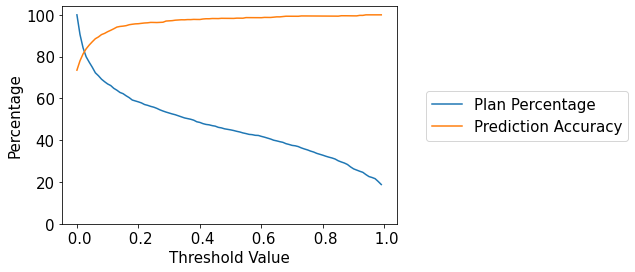

Threshold for 75% accuracy: 0.01
Plans % for 75% accuracy: 90.60317460317461
Threshold for 80% accuracy: 0.02
Plans % for 80% accuracy: 84.19047619047619
Threshold for 85% accuracy: 0.04
Plans % for 85% accuracy: 77.33333333333333
Threshold for 90% accuracy: 0.08
Plans % for 90% accuracy: 69.2063492063492
Threshold for 95% accuracy: 0.17
Plans % for 95% accuracy: 60.38095238095238


In [40]:
get_line_plot([y_confidence, y_pred_confidence], 
              range(0, len(x)+2, 20), [f'{i: .1f}' for i in np.arange(0, 1.1, 0.2)],
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], 'Threshold Value', 'Percentage', 
              styles=['-', '-'], markers=['', ''])

# plt.plot(x, y_confidence, label='Confident')
# plt.plot(x, y_pred_confidence, label='Predicted Confident')
# plt.legend()

for th in np.arange(75, 100, 5):
    print(f'Threshold for {int(th)}% accuracy: {[t for t, y in zip(x, y_pred_confidence) if y>th][0]}')
    print(f'Plans % for {int(th)}% accuracy: {[t for t, y in zip(y_confidence, y_pred_confidence) if y>th][0]}')

#### Risk aversion

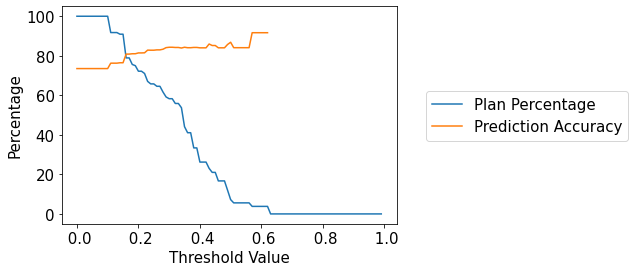

In [41]:
get_line_plot([y_risk_free, y_pred_risk_free], 
              range(0, len(x)+2, 20), [f'{i: .1f}' for i in np.arange(0, 1.1, 0.2)],
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], 'Threshold Value', 'Percentage', 
              styles=['-', '-'], markers=['', ''])
print()
# for th in np.arange(75, 100, 5):
#     print(f'Threshold for {int(th)}% accuracy: {[t for t, y in zip(x, y_pred_confidence) if y>th][0]}')
#     print(f'Plans % for {int(th)}% accuracy: {[t for t, y in zip(y_confidence, y_pred_confidence) if y>th][0]}')

#### Experience 

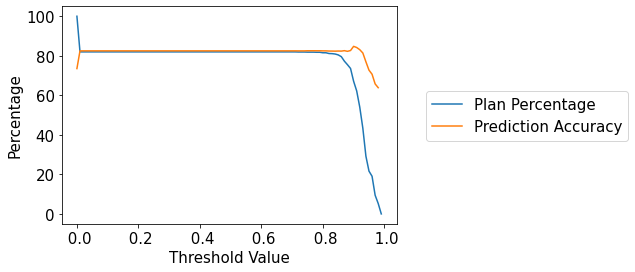

Threshold for 75% accuracy: 0.01
Plans % for 75% accuracy: 81.96825396825396
Threshold for 80% accuracy: 0.01
Plans % for 80% accuracy: 81.96825396825396
Threshold for 84% accuracy: 0.9
Plans % for 84% accuracy: 67.11111111111111


In [42]:
get_line_plot([y_precise, y_pred_precise], 
              range(0, len(x)+2, 20), [f'{i: .1f}' for i in np.arange(0, 1.1, 0.2)],
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], 'Threshold Value', 'Percentage', 
              styles=['-', '-'], markers=['', ''])
prec_thresholds = list(np.arange(75, 81, 5))
prec_thresholds.append(84)
for th in prec_thresholds:
    print(f'Threshold for {int(th)}% accuracy: {[t for t, y in zip(x, y_pred_precise) if y>th][0]}')
    print(f'Plans % for {int(th)}% accuracy: {[t for t, y in zip(y_precise, y_pred_precise) if y>th][0]}')


### Thresholds results for all models

In [12]:
thresholds = [0.08, 0.8]
#all_metrics, tot = get_metric(df_network, thresholds, 1, metrics_labels=['Confidence', 'Precise', 'Confidence AND Precise'])
#models_list = np.arange(22, 77)
models_list = np.linspace(22, 76, 25, dtype=int)
print(np.linspace(22,76, 5, dtype=int))
print(np.linspace(0,24, 5, dtype=int))
#x, network_plan_percentages, network_precisions, network_times, planner_plan_percentages, planner_precisions, planner_times, only_network_precisions, only_network_times = get_metrics_for_models(models_list, thresholds, verbose=0, metrics_labels=['Confidence', 'Precise', 'Confidence AND Precise'])


[22 35 49 62 76]
[ 0  6 12 18 24]


In [146]:
dp_dict = {}
dp_dict['x'] = x 
dp_dict['network_plan_percentages'] = network_plan_percentages
dp_dict['network_precisions'] = network_precisions
dp_dict['network_times'] = network_times
dp_dict['planner_plan_percentages'] = planner_plan_percentages
dp_dict['planner_precisions'] = planner_precisions
dp_dict['planner_times'] = planner_times
dp_dict['only_network_precisions'] = only_network_precisions
dp_dict['only_network_times'] = only_network_times


os.makedirs(os.path.join('..', 'data', 'depots'), exist_ok=True)
save_file(dp_dict, os.path.join('..', 'data', 'depots'), 'depots_results.pkl')

depots_results.pkl saved in ../data/depots


True

In [152]:
x, network_plan_percentages, network_precisions, network_times, planner_plan_percentages, planner_precisions, planner_times, only_network_precisions, only_network_times = dp_dict['x'], dp_dict['network_plan_percentages'], dp_dict['network_precisions'], dp_dict['network_times'], dp_dict['planner_plan_percentages'], dp_dict['planner_precisions'], dp_dict['planner_times'], dp_dict['only_network_precisions'], dp_dict['only_network_times']

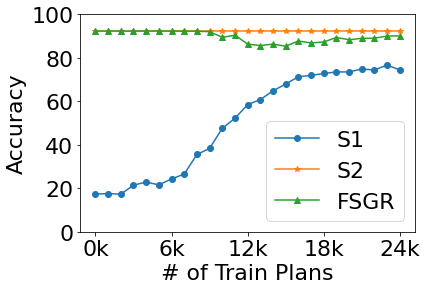

In [155]:
overall_precisions = [planner_precisions[i] if np.isnan(network_precisions[2][i]) else planner_precisions[i]*planner_plan_percentages[i]/100 + network_precisions[2][i]*network_plan_percentages[2][i]/100 
                       for i in range(len(planner_precisions))]
fig, ax = get_line_plot([only_network_precisions, [planner_precisions[0] for _ in range(len(overall_precisions))], overall_precisions], 
              np.linspace(0, 24, 5), [f'{int(np.floor((i+1)*15*64/1000))}k' for i in np.linspace(0, 24, 5, dtype=int)],
              range(0, 101, 20), [], 
              None, '# of Train Plans', 'Accuracy', 
              styles=['-', '-', '-'], markers=['o', '*', '^'])
labels = ['S1', 'S2', 'FSGR']
clear_output()
ax.legend(labels, loc = 'best')
display(fig)
print()


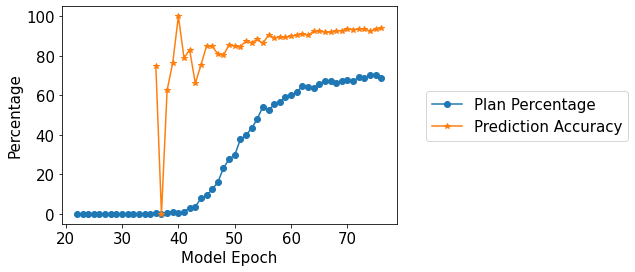

In [75]:
get_line_plot([network_plan_percentages[2], network_precisions[2]], 
              range(-2, len(x), 10), range(20, 77, 10),
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], 'Model Epoch', 'Percentage', 
              styles=['-', '-'], markers=['o', '*'])
print()

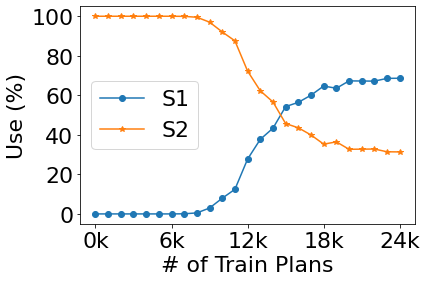

In [158]:
overall_precisions = [planner_precisions[i] if np.isnan(network_precisions[2][i]) else planner_precisions[i]*planner_plan_percentages[i]/100 + network_precisions[2][i]*network_plan_percentages[2][i]/100 
                       for i in range(len(planner_precisions))]
fig, ax = get_line_plot([network_plan_percentages[2], planner_plan_percentages], 
              np.linspace(0, 24, 5), [f'{int(np.floor((i+1)*15*64/1000))}k' for i in np.linspace(0, 24, 5, dtype=int)],
              range(0, 101, 20), [], 
              None, '# of Train Plans', 'Use (%)', 
              styles=['-', '-'], markers=['o', '*'])
clear_output()
labels = ['S1', 'S2']
ax.legend(labels, loc = 'best')
display(fig)
print()



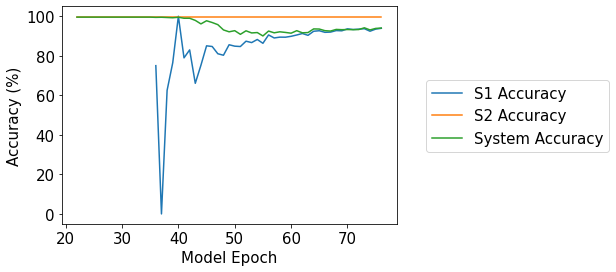

In [104]:
partial_planner_precisions = [planner_precisions[0] for i in range(len(planner_precisions))]
partial_network_precisions = [network_precisions[2][i] for i in range(len(planner_precisions))]
get_line_plot([partial_network_precisions, partial_planner_precisions, overall_precisions], 
              range(-2, len(x), 10), range(20, 77, 10),
              range(0, 101, 20), [], 
              ['S1 Accuracy', 'S2 Accuracy', 'System Accuracy'], 'Model Epoch', 'Accuracy (%)', 
              styles=['-', '-', '-'], markers=['', '', ''])
print()

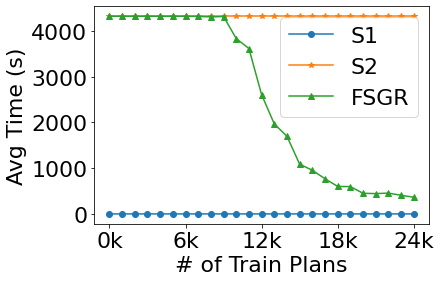

In [157]:
overall_times = [planner_times[i] if np.isnan(network_times[2][i]) else planner_times[i]*planner_plan_percentages[i]/100 + network_times[2][i]*network_plan_percentages[2][i]/100 for i in range(len(planner_times))]
fig, ax = get_line_plot([only_network_times, [planner_times[0] for _ in range(len(only_network_times))],overall_times], 
              np.linspace(0, 24, 5), [f'{int(np.floor((i+1)*15*64/1000))}k' for i in np.linspace(0, 24, 5, dtype=int)],
              np.linspace(0, 4000, 5), [], 
              None, '# of Train Plans', 'Avg Time (s)',
              styles=['-', '-', '-'], markers=['o', '*', '^'])
labels = ['S1', 'S2', 'FSGR']
clear_output()
ax.legend(labels, loc = 'best')
display(fig)
print()
    

In [1]:
overall_times = [planner_times[i] if np.isnan(network_times[2][i]) else planner_times[i]*planner_plan_percentages[i]/100 + network_times[2][i]*network_plan_percentages[2][i]/100 for i in range(len(planner_times))]
get_line_plot([overall_times], 
              range(-2, len(x), 10), range(20, 77, 10),
              np.linspace(0, 4000, 5), [],
              None, 'Model Epoch', 'Avg Time (s)',
              styles=['-', '-', '-'], markers=['', '', ''])
print()
    

NameError: name 'planner_times' is not defined

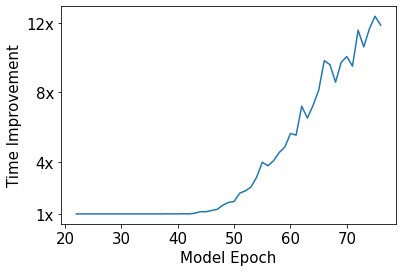

In [109]:
y_interval = np.linspace(1, 12, 4, dtype=int)
y_labels = [f'{i}x' for i in y_interval]
overall_time_improvement = [1 if np.isnan(network_times[2][i]) else planner_times[0]/(planner_times[i]*planner_plan_percentages[i]/100 + network_times[2][i]*network_plan_percentages[2][i]/100) for i in range(len(planner_times))]
get_line_plot([overall_time_improvement], 
              range(-2, len(x), 10), range(20, 77, 10),
              y_interval, y_labels,
              None, 'Model Epoch', 'Time Improvement',
              styles=['-', '-', '-'], markers=['', '', ''])
print()

### Multiple thresholds

In [10]:
thresholds = [0.08, 0.8]
#all_metrics, tot = get_metric(df_network, thresholds, 1, metrics_labels=['Confidence', 'Precise', 'Confidence AND Precise'])
#models_list = np.arange(22, 77)
models_list = np.linspace(22, 76, 25, dtype=int)
print(np.linspace(22,76, 5, dtype=int))
print(np.linspace(0,24, 5, dtype=int))

[22 35 49 62 76]
[ 0  6 12 18 24]


In [11]:
x_list = list()
network_plan_percentages_list = list()
network_precisions_list = list()
network_times_list = list()
planner_plan_percentages_list = list()
planner_precisions_list = list()
planner_times_list = list()
only_network_precisions_list = list()
only_network_times_list = list()

value_1 = thresholds[0]
value_1_list = [value_1/2, value_1, value_1*2]
value_2 = thresholds[1]
value_2_list = [value_2/2, value_2, value_2*2]

for i in value_1_list:
    for j in value_2_list:
        thresholds = [i, j]
        x, network_plan_percentages, network_precisions, network_times, planner_plan_percentages, planner_precisions, planner_times, only_network_precisions, only_network_times = get_metrics_for_models(models_list, thresholds, verbose=0, metrics_labels=['Confidence', 'Precise', 'Confidence AND Precise'])
        x_list.append(x)
        network_plan_percentages_list.append(network_plan_percentages)
        network_precisions_list.append(network_precisions)
        network_times_list.append(network_times)
        planner_plan_percentages_list.append(planner_plan_percentages)
        planner_precisions_list.append(planner_precisions)
        planner_times_list.append(planner_times)
        only_network_precisions_list.append(only_network_precisions)
        only_network_times_list.append(only_network_times)

results_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
Model 22
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_22
network_results_test_plans_p02.txt 

/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 24
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 26
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 28
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 31
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 33
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 35
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 37
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
Model 40
network_results_test_pl

/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 24
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 26
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 28
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 31
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 33
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 35
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 37
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
Model 40
network_results_test_pl

/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 24
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 26
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 28
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 31
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 33
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 35
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 37
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 40
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_40
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_40
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_40
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_40
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_40
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_40
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_40


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 42
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_42
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_42
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_42
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_42
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_42
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_42
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_42


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 44
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_44
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_44
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_44
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_44
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_44
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_44
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_44


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 46
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_46
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_46
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_46
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_46
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_46
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_46
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_46


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 49
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_49
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_49
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_49
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_49
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_49
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_49
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_49


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 51
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_51
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_51
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_51
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_51
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_51
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_51
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_51


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 53
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_53
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_53
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_53
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_53
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_53
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_53
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_53


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 55
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_55
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_55
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_55
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_55
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_55
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_55
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_55


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 58
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_58
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_58
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_58
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_58
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_58
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_58
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_58


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 60
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_60
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_60
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_60
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_60
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_60
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_60
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_60


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 62
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_62
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_62
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_62
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_62
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_62
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_62
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_62


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 64
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 67
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_67
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_67
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_67
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_67
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_67
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_67
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_67


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 69
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_69
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_69
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_69
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_69
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_69
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_69
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_69


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 71
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_71
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_71
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_71
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_71
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_71
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_71
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_71


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 73
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_73
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_73
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_73
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_73
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_73
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_73
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_73


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 76
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_76
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_76
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_76
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_76
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_76
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_76
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_76


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


results_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
Model 22
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_22
network_results_test_plans_p02.txt 

/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 24
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 26
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 28
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 31
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 33
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 35
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 37
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
Model 40
network_results_test_pl

/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 24
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 26
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 28
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 31
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 33
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 35
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 37
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
Model 40
network_results_test_pl

/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 24
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 26
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 28
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 31
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 33
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 35
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 37
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 40
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_40
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_40
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_40
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_40
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_40
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_40
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_40


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 42
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_42
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_42
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_42
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_42
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_42
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_42
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_42


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 44
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_44
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_44
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_44
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_44
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_44
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_44
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_44


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 46
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_46
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_46
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_46
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_46
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_46
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_46
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_46


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 49
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_49
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_49
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_49
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_49
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_49
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_49
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_49


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 51
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_51
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_51
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_51
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_51
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_51
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_51
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_51


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 53
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_53
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_53
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_53
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_53
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_53
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_53
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_53


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 55
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_55
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_55
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_55
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_55
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_55
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_55
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_55


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 58
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_58
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_58
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_58
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_58
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_58
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_58
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_58


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 60
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_60
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_60
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_60
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_60
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_60
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_60
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_60


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 62
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_62
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_62
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_62
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_62
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_62
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_62
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_62


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 64
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_64


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 67
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_67
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_67
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_67
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_67
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_67
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_67
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_67


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 69
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_69
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_69
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_69
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_69
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_69
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_69
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_69


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 71
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_71
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_71
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_71
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_71
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_71
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_71
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_71


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 73
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_73
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_73
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_73
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_73
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_73
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_73
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_73


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 76
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_76
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_76
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_76
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_76
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_76
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_76
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_76


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


results_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
results_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/planner
Model 22
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_22
network_results_test_plans_p02.txt 

/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 24
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 26
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 28
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 31
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 33
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 35
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 37
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
Model 40
network_results_test_pl

/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 24
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_24


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 26
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_26


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 28
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_28


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 31
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_31


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 33
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_33


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 35
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_35


/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 37
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/depots/optimal/model_37
Model 40
network_results_test_pl

KeyboardInterrupt: 

## 2. Logistics

### Define variables

In [19]:
results_folder = '../datasets/gr_logistics/results/results_jsons'
plots_dir = '../datasets/gr_logistics/results/plots'
target_model = 16
r_confidence = np.arange(0.00, 1, 0.01)
r_precision = np.arange(0.00, 1, 0.01)
r_risk = np.arange(0.00, 1, 0.01)

### Import results json

In [20]:
df_planner_dict = create_df_dict_planner(results_folder, verbose=0)

results_p01.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p02.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p03.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p04.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p05.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p06.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p07.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner


In [21]:
df_network = create_df_dict_network(target_model, results_folder=results_folder, verbose=0)

network_results_test_plans_p01.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_16
network_results_test_plans_p02.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_16
network_results_test_plans_p03.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_16
network_results_test_plans_p04.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_16
network_results_test_plans_p05.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_16
network_results_test_plans_p06.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_16
network_results_test_plans_p07.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_16


### Compute thresholds for the metrics with model chosen

In [22]:
x, y_confidence, y_pred_confidence = get_metrics_in_range(df_network, 0, r_confidence, 0, ['Confidence', 'Confidence2'])
x, y_risk_free, y_pred_risk_free = get_metrics_in_range(df_network, 0, r_risk, 0, ['Risk Free', 'Risk Free2'])
x, y_precise, y_pred_precise = get_metrics_in_range(df_network, 0, r_precision, 0, ['Precise', 'Precise2'])

/tmp/ipykernel_3593558/1447561972.py:105: RuntimeWarning: invalid value encountered in scalar divide
  y_pred_metric.append(all_metrics[target_metric][1]/all_metrics[target_metric][0]*100)


/home/deeplearning/ruggero/FSGR_thesis/code/utils_unibs/plots.py:369: UserWarning: The number of yticks labels is different from the number of yticks
  warnings.warn(C.TICKS_WARNING_MSG.format(axis))


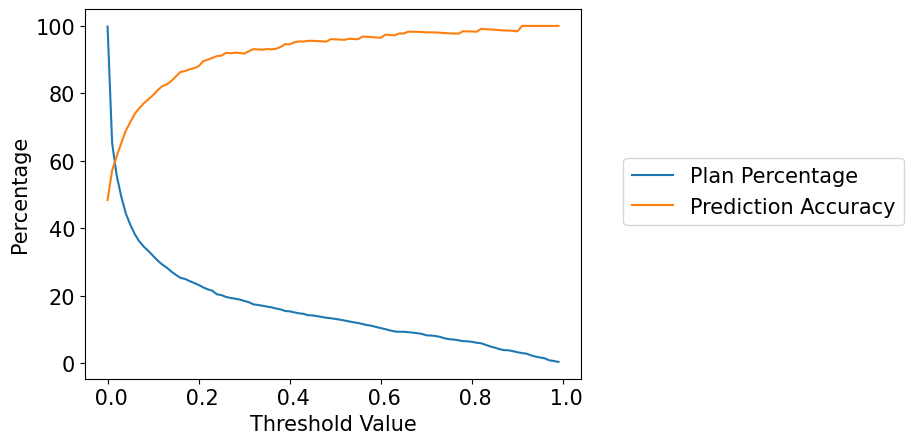

Threshold for 45% accuracy: 0.0
Plans % for 45% accuracy: 100.0
Threshold for 50% accuracy: 0.01
Plans % for 50% accuracy: 84.27377220480669
Threshold for 55% accuracy: 0.63
Plans % for 55% accuracy: 72.25705329153605
No threshold found for 60% accuracy (max accuracy: 59.38%)
No plans % found for 60% accuracy
No threshold found for 65% accuracy (max accuracy: 59.38%)
No plans % found for 65% accuracy
No threshold found for 70% accuracy (max accuracy: 59.38%)
No plans % found for 70% accuracy
No threshold found for 75% accuracy (max accuracy: 59.38%)
No plans % found for 75% accuracy
No threshold found for 80% accuracy (max accuracy: 59.38%)
No plans % found for 80% accuracy
No threshold found for 85% accuracy (max accuracy: 59.38%)
No plans % found for 85% accuracy
No threshold found for 90% accuracy (max accuracy: 59.38%)
No plans % found for 90% accuracy
No threshold found for 95% accuracy (max accuracy: 59.38%)
No plans % found for 95% accuracy


In [23]:
fig, ax = get_line_plot([y_confidence, y_pred_confidence], 
              range(0, len(x)+2, 20), [f'{i: .1f}' for i in np.arange(0, 1.1, 0.2)],
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], 'Threshold Value', 'Percentage', 
              styles=['-', '-'], markers=['', ''])


fig.savefig(os.path.join(plots_dir, 'acc_vs_plan_perc_y_conf_y_pred_conf.png'))

# plt.plot(x, y_confidence, label='Confident')
# plt.plot(x, y_pred_confidence, label='Predicted Confident')
# plt.legend()

prec_thresholds = list(np.arange(45, 100, 5))

for th in prec_thresholds:
    threshold_values = [t for t, y in zip(x, y_pred_precise) if y > th]
    plan_values = [t for t, y in zip(y_precise, y_pred_precise) if y > th]
    
    if threshold_values:
        print(f'Threshold for {int(th)}% accuracy: {threshold_values[0]}')
    else:
        print(f'No threshold found for {int(th)}% accuracy (max accuracy: {max(y_pred_precise):.2f}%)')
    
    if plan_values:
        print(f'Plans % for {int(th)}% accuracy: {plan_values[0]}')
    else:
        print(f'No plans % found for {int(th)}% accuracy')

/home/deeplearning/ruggero/FSGR_thesis/code/utils_unibs/plots.py:369: UserWarning: The number of yticks labels is different from the number of yticks
  warnings.warn(C.TICKS_WARNING_MSG.format(axis))


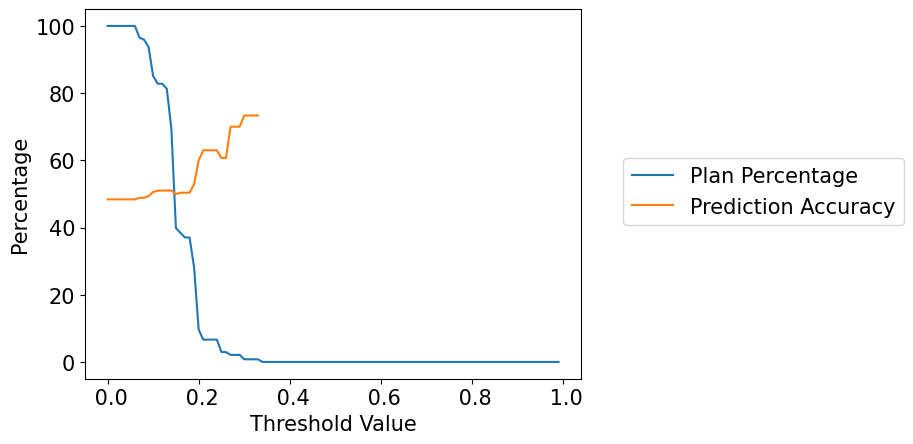

In [24]:
fig, ax = get_line_plot([y_risk_free, y_pred_risk_free], 
              range(0, len(x)+2, 20), [f'{i: .1f}' for i in np.arange(0, 1.1, 0.2)],
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], 'Threshold Value', 'Percentage', 
              styles=['-', '-'], markers=['', ''])
fig.savefig(os.path.join(plots_dir, 'acc_vs_plan_perc_y_risk_free_y_pred_risk_free.png'))

print()

/home/deeplearning/ruggero/FSGR_thesis/code/utils_unibs/plots.py:369: UserWarning: The number of yticks labels is different from the number of yticks
  warnings.warn(C.TICKS_WARNING_MSG.format(axis))


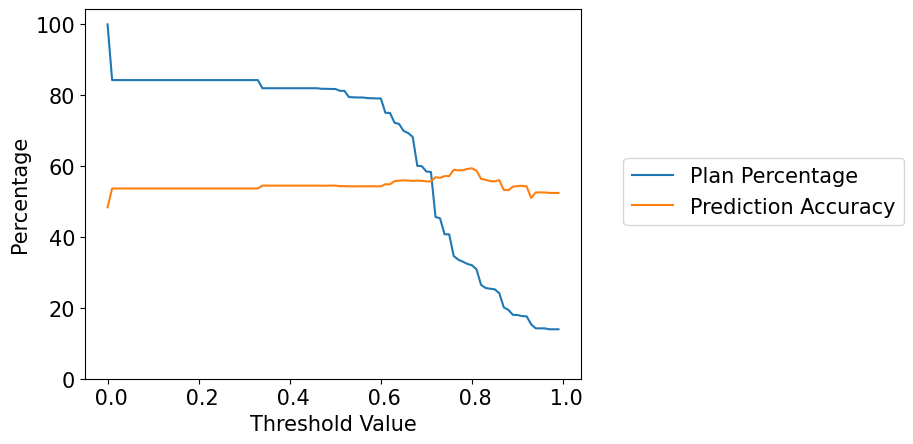

No threshold found for 75% accuracy (max accuracy: 59.38%)
No plans % found for 75% accuracy
No threshold found for 80% accuracy (max accuracy: 59.38%)
No plans % found for 80% accuracy


In [25]:
fig, ax = get_line_plot([y_precise, y_pred_precise], 
              range(0, len(x)+2, 20), [f'{i: .1f}' for i in np.arange(0, 1.1, 0.2)],
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], 'Threshold Value', 'Percentage', 
              styles=['-', '-'], markers=['', ''])

fig.savefig(os.path.join(plots_dir, 'acc_vs_plan_perc_y_precise_y_pred_precise.png'))
prec_thresholds = list(np.arange(75, 81, 5))
for th in prec_thresholds:
    threshold_values = [t for t, y in zip(x, y_pred_precise) if y > th]
    plan_values = [t for t, y in zip(y_precise, y_pred_precise) if y > th]
    
    if threshold_values:
        print(f'Threshold for {int(th)}% accuracy: {threshold_values[0]}')
    else:
        print(f'No threshold found for {int(th)}% accuracy (max accuracy: {max(y_pred_precise):.2f}%)')
    
    if plan_values:
        print(f'Plans % for {int(th)}% accuracy: {plan_values[0]}')
    else:
        print(f'No plans % found for {int(th)}% accuracy')

In [30]:
thresholds = [0.04, 0.6]
all_metrics, tot, _, _ = get_metric(df_network, thresholds, 0, metrics_labels=['Confidence', 'Precise', 'Confidence AND Precise'])
models_list = np.linspace(0, 16, 16, dtype=int)
#models_list = [37,38]
x, network_plan_percentages, network_precisions, network_times, planner_plan_percentages, planner_precisions, planner_times, only_network_precisions, only_network_times = get_metrics_for_models(models_list, 
                                                                                                                                                                                                thresholds, 
                                                                                                                                                                                                results_folder=results_folder,
                                                                                                                                                                                                verbose=0, 
                                                                                                                                                                                                use_planner=True,
                                                                                                                                                                                    metrics_labels=['Confidence', 'Precise', 'Confidence AND Precise'])

results_p01.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p02.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p03.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p04.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p05.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p06.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner
results_p07.txt loaded from ../datasets/gr_logistics/results/results_jsons/planner


Model 0
network_results_test_plans_p01.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_0
network_results_test_plans_p02.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_0
network_results_test_plans_p03.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_0
network_results_test_plans_p04.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_0
network_results_test_plans_p05.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_0
network_results_test_plans_p06.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_0
network_results_test_plans_p07.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_0


/tmp/ipykernel_3593558/1447561972.py:134: RuntimeWarning: invalid value encountered in scalar divide
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/tmp/ipykernel_3593558/1447561972.py:135: RuntimeWarning: invalid value encountered in scalar divide
  time = network_metrics[i][2]/network_metrics[i][0]


Model 1
network_results_test_plans_p01.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_1
network_results_test_plans_p02.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_1
network_results_test_plans_p03.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_1
network_results_test_plans_p04.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_1
network_results_test_plans_p05.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_1
network_results_test_plans_p06.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_1
network_results_test_plans_p07.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_1
Model 2
network_results_test_plans_p01.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_2
network_results_test_plans_p02.txt loaded from ../datasets/gr_logistics/results/results_jsons/model_2
network_results_test_plans_p03.txt loaded from ../datasets/gr_logi

In [32]:
print(planner_precisions)

[np.float64(55.73580633925464), np.float64(55.73580633925464), np.float64(55.89112405152641), np.float64(55.80864197530866), np.float64(55.802501761804116), np.float64(55.65495207667733), np.float64(55.710992907801426), np.float64(55.90177133655396), np.float64(55.75373790677223), np.float64(55.68987573099417), np.float64(54.962163159837594), np.float64(55.62581607908974), np.float64(55.10422588592003), np.float64(55.557416713195614), np.float64(54.54563031709204), np.float64(55.12420566146737)]


/home/deeplearning/ruggero/FSGR_thesis/code/utils_unibs/plots.py:369: UserWarning: The number of xticks labels is different from the number of xticks
  warnings.warn(C.TICKS_WARNING_MSG.format(axis))
/home/deeplearning/ruggero/FSGR_thesis/code/utils_unibs/plots.py:369: UserWarning: The number of yticks labels is different from the number of yticks
  warnings.warn(C.TICKS_WARNING_MSG.format(axis))


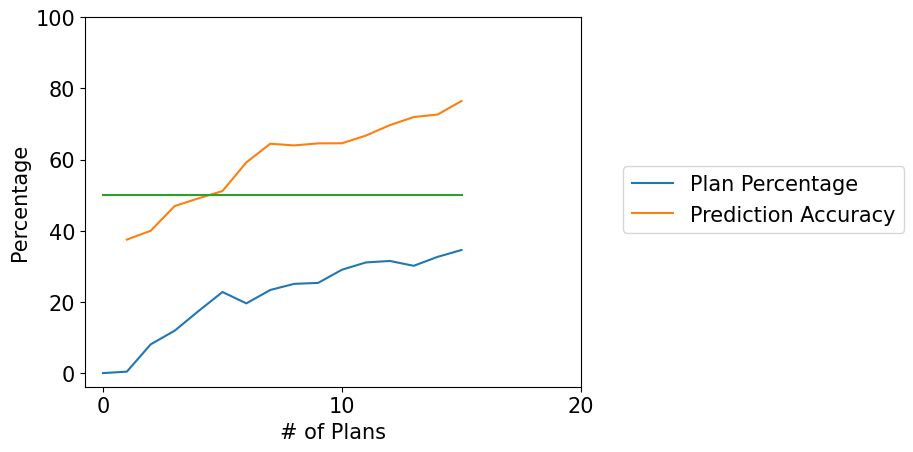

In [15]:
step = 10
models = 16
batch_size = 64
get_line_plot([network_plan_percentages[2], network_precisions[2], np.ones(len(network_plan_percentages[2]))*50], 
              range(0, len(network_plan_percentages[2])+9, 10), range(step*batch_size, step*batch_size*(len(network_plan_percentages[2])+2)+1, step*batch_size*10),
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], '# of Plans', 'Percentage', 
              styles=['-', '-', '-'], markers=['', '', ''])
print()

In [14]:
lg_dict = {}
lg_dict['x'] = x 
lg_dict['network_plan_percentages'] = network_plan_percentages
lg_dict['network_precisions'] = network_precisions
lg_dict['network_times'] = network_times
lg_dict['planner_plan_percentages'] = planner_plan_percentages
lg_dict['planner_precisions'] = planner_precisions
lg_dict['planner_times'] = planner_times
lg_dict['only_network_precisions'] = only_network_precisions
lg_dict['only_network_times'] = only_network_times


out_dir = os.path.join(results_folder, 'logistics_final')
os.makedirs(out_dir, exist_ok=True)
save_file(lg_dict, out_dir, 'logistics_results.pkl')

logistics_results.pkl saved in ../datasets/gr_logistics/results/results_jsons/logistics_final


True

In [15]:
x, network_plan_percentages, network_precisions, network_times, planner_plan_percentages, planner_precisions, planner_times, only_network_precisions, only_network_times = lg_dict['x'], lg_dict['network_plan_percentages'], lg_dict['network_precisions'], lg_dict['network_times'], lg_dict['planner_plan_percentages'], lg_dict['planner_precisions'], lg_dict['planner_times'], lg_dict['only_network_precisions'], lg_dict['only_network_times']

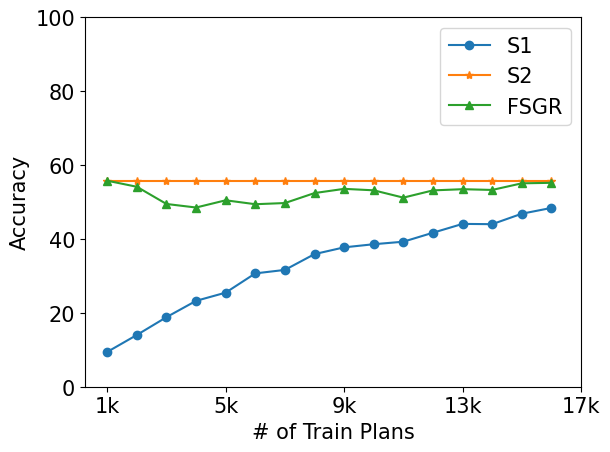


[np.float64(55.73580633925464), np.float64(54.09874608150471), np.float64(49.44444444444446), np.float64(48.48484848484848), np.float64(50.44148380355278), np.float64(49.37913618948102), np.float64(49.69696969696971), np.float64(52.39637756879136), np.float64(53.537095088819235), np.float64(53.13915012190874), np.float64(51.15987460815046), np.float64(53.12173458725183), np.float64(53.44130964820619), np.float64(53.243643329850215), np.float64(55.03308951584815), np.float64(55.168059909439215)]


In [31]:
# planner_precisions = logistics_results['planner_precisions']
# network_precisions = logistics_results['network_precisions']
# planner_plan_percentages = logistics_results['planner_plan_percentages']
# network_plan_percentages = logistics_results['network_plan_percentages']
# only_network_precisions = logistics_results['only_network_precisions']
#overall_precisions = [planner_precisions[i] if np.isnan(network_precisions[-1][i]) else planner_precisions[i]*planner_plan_percentages[i]/100 + network_precisions[-1][i]*network_plan_percentages[i]/100 
#                       for i in range(len(planner_precisions))]
overall_precisions = [planner_precisions[i] if np.isnan(network_precisions[2][i]) else planner_precisions[i]*planner_plan_percentages[i]/100 + network_precisions[2][i]*network_plan_percentages[2][i]/100 
                       for i in range(len(planner_precisions))]
fig, ax = get_line_plot([only_network_precisions, [planner_precisions[0] for _ in range(len(overall_precisions))], overall_precisions], 
              np.linspace(0, models, 5), [f'{int(np.floor((i+1)*16*64/1000))}k' for i in np.linspace(0, models, 5, dtype=int)],
              range(0, 101, 20), [], 
              None, '# of Train Plans', 'Accuracy', 
              styles=['-', '-', '-'], markers=['o', '*', '^'])
clear_output()
labels = ['S1', 'S2', 'FSGR']
ax.legend(labels, loc = 'best')
fig.savefig(os.path.join(plots_dir, 'fsgr_acc_vs_num_plans.png'))
display(fig)
print()
print(overall_precisions)

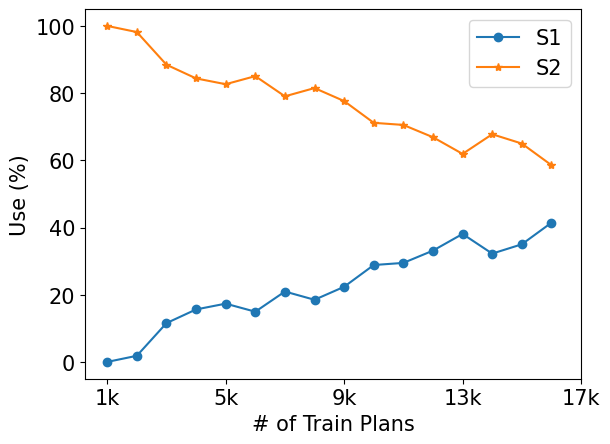

In [32]:

overall_precisions = [planner_precisions[i] if np.isnan(network_precisions[2][i]) else planner_precisions[i]*planner_plan_percentages[i]/100 + network_precisions[2][i]*network_plan_percentages[2][i]/100 
                       for i in range(len(planner_precisions))]
fig, ax = get_line_plot([network_plan_percentages[2], planner_plan_percentages], 
              np.linspace(0, models, 5), [f'{int(np.floor((i+1)*16*64/1000))}k' for i in np.linspace(0, models, 5, dtype=int)],
              range(0, 101, 20), [], 
              None, '# of Train Plans', 'Use (%)', 
              styles=['-', '-'], markers=['o', '*'])
clear_output()
labels = ['S1', 'S2']
ax.legend(labels, loc = 'best')
fig.savefig(os.path.join(plots_dir, 'fsgr_use_vs_num_plans.png'))
display(fig)
print()

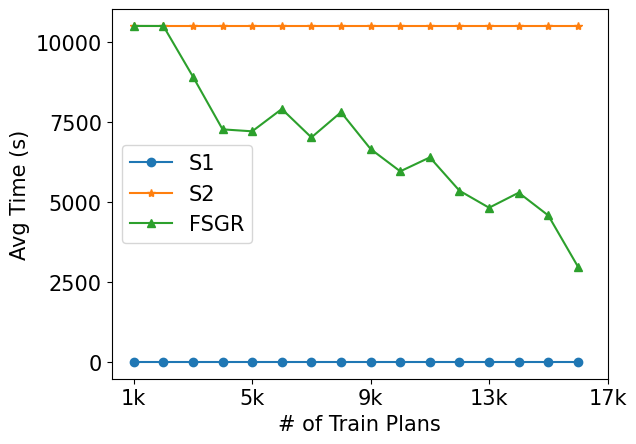

In [33]:
# planner_times = logistics_results['planner_times']
# network_times = logistics_results['network_times']
# only_network_times = logistics_results['only_network_times']
# planner_plan_percentages = logistics_results['planner_plan_percentages']
# network_plan_percentages = logistics_results['network_plan_percentages']
y_values = np.linspace(0, 10000, 5)
overall_times = [planner_times[i] if np.isnan(network_times[2][i]) else planner_times[i]*planner_plan_percentages[i]/100 + network_times[2][i]*network_plan_percentages[2][i]/100 for i in range(len(planner_times))]
# overall_times = [planner_times[i] if np.isnan(network_times[i]) else planner_times[i]*planner_plan_percentages[i]/100 + network_times[i]*network_plan_percentages[i]/100 for i in range(len(planner_times))]
fig, ax = get_line_plot([only_network_times, [planner_times[0] for _ in range(len(only_network_times))],overall_times], 
              np.linspace(0, models, 5), [f'{int(np.floor((i+1)*16*64/1000))}k' for i in np.linspace(0, models, 5, dtype=int)],
              y_values, [], 
              None, '# of Train Plans', 'Avg Time (s)',
              styles=['-', '-', '-'], markers=['o', '*', '^'])
clear_output()
labels = ['S1', 'S2', 'FSGR']
ax.legend(labels,loc = 'best')
fig.savefig(os.path.join(plots_dir, 'fsgr_avg_time_vs_num_plans.png'))
display(fig)
print()

/home/deeplearning/ruggero/FSGR_thesis/code/utils_unibs/plots.py:369: UserWarning: The number of xticks labels is different from the number of xticks
  warnings.warn(C.TICKS_WARNING_MSG.format(axis))


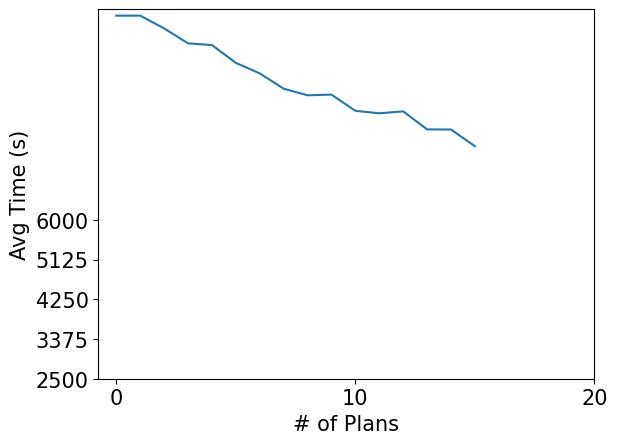

In [19]:
overall_times = [planner_times[i] if np.isnan(network_times[2][i]) else planner_times[i]*planner_plan_percentages[i]/100 + network_times[2][i]*network_plan_percentages[2][i]/100 for i in range(len(planner_times))]
fig, ax = get_line_plot([overall_times], 
              range(0, len(network_plan_percentages[2])+9, 10), range(step*batch_size, step*batch_size*(len(network_plan_percentages[2])+2)+1, step*batch_size*10),
              np.linspace(2500, 6000, 5), [], 
              None, '# of Plans', 'Avg Time (s)',
              styles=['-', '-', '-'], markers=['', '', ''])
print()
    

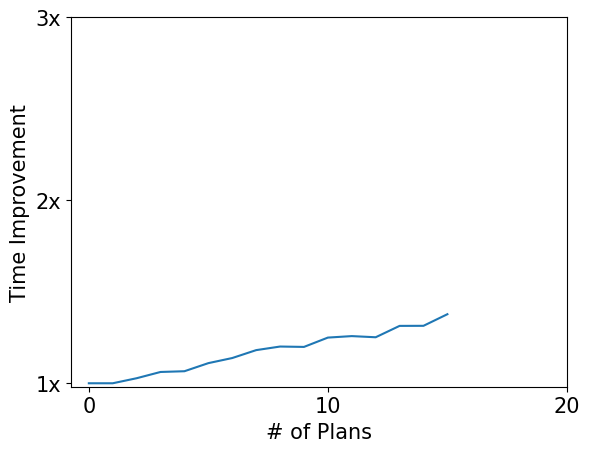

In [20]:
overall_time_improvement = [1 if np.isnan(network_times[2][i]) else planner_times[0]/(planner_times[i]*planner_plan_percentages[i]/100 + network_times[2][i]*network_plan_percentages[2][i]/100) for i in range(len(planner_times))]
max_improvement = 3
get_line_plot([overall_time_improvement], 
              range(0, len(network_plan_percentages[2])+9, 10), range(step*batch_size, step*batch_size*(len(network_plan_percentages[2])+2)+1, step*batch_size*10),
              np.linspace(1, max_improvement, max_improvement), [f'{i}x' for i in range(1, max_improvement+1)], 
              None, '# of Plans', 'Time Improvement',
              styles=['-', '-', '-'], markers=['', '', ''])
print()

## 3. Blocksworld

### Define variables

In [119]:
results_folder = '/Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/'
target_model = 24
r_confidence = np.arange(0.00, 1, 0.01)
r_precision = np.arange(0.00, 1, 0.01)
r_risk = np.arange(0.00, 1, 0.01)

### Import results json

In [8]:
df_planner_dict = create_df_dict_planner(results_folder, verbose=1)

results_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/planner
results_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/planner
results_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/planner
results_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/planner
results_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/planner
results_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/planner


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p001675,classic_goal_17,ottimo,classic_goal_17_p001675.sol,NoValidationPerformed,NaN,0.66,0.037,18,0.043355,2993
1,p001896,classic_goal_13,ottimo,classic_goal_13_p001896.sol,NoValidationPerformed,NaN,0.65,0.036,14,0.039805,180
2,p001514,classic_goal_1,ottimo,classic_goal_1_p001514.sol,NoValidationPerformed,NaN,0.58,0.041,14,0.016298,110
3,p001984,classic_goal_17,ottimo,classic_goal_17_p001984.sol,NoValidationPerformed,NaN,0.60,0.052,10,0.014449,23
4,p001960,classic_goal_5,ottimo,classic_goal_5_p001960.sol,NoValidationPerformed,NaN,0.56,0.065,6,0.007051,7
...,...,...,...,...,...,...,...,...,...,...,...
8395,p001675,constraints_constraint50_goal_7,pac_ottimo,constraints_constraint50_goal_7_p001675.sol,NoValidationPerformed,NaN,24.88,24.542,22,0.054445,358
8396,p001832,constraints_constraint50_goal_2,pac_ottimo,constraints_constraint50_goal_2_p001832.sol,NoValidationPerformed,NaN,28.25,28.019,11,0.007805,37
8397,p001894,constraints_constraint50_goal_7,pac_ottimo,constraints_constraint50_goal_7_p001894.sol,NoValidationPerformed,NaN,13.02,12.775,14,0.031612,275
8398,p001896,constraints_constraint50_goal_7,pac_ottimo,constraints_constraint50_goal_7_p001896.sol,NoValidationPerformed,NaN,27.87,27.638,13,0.006478,19


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p001387,classic_goal_0,ottimo,classic_goal_0_p001387.sol,NoValidationPerformed,NaN,0.67,0.080,8,0.010578,35
1,p001189,classic_goal_7,ottimo,classic_goal_7_p001189.sol,NoValidationPerformed,NaN,0.69,0.098,14,0.026240,335
2,p001189,classic_goal_15,ottimo,classic_goal_15_p001189.sol,NoValidationPerformed,NaN,0.79,0.066,16,0.021482,306
3,p001387,classic_goal_14,ottimo,classic_goal_14_p001387.sol,NoValidationPerformed,NaN,0.74,0.086,14,0.023121,364
4,p001001,classic_goal_17,ottimo,classic_goal_17_p001001.sol,NoValidationPerformed,NaN,0.70,0.066,16,0.014439,634
...,...,...,...,...,...,...,...,...,...,...,...
7995,p001280,constraints_constraint50_goal_7,pac_ottimo,constraints_constraint50_goal_7_p001280.sol,NoValidationPerformed,NaN,26.32,25.969,20,0.121843,927
7996,p001375,constraints_constraint50_goal_7,pac_ottimo,constraints_constraint50_goal_7_p001375.sol,NoValidationPerformed,NaN,27.42,27.191,15,0.008737,35
7997,p001187,constraints_constraint50_goal_7,pac_ottimo,constraints_constraint50_goal_7_p001187.sol,NoValidationPerformed,NaN,21.40,21.005,22,0.169023,1529
7998,p001187,constraints_constraint50_goal_4,pac_ottimo,constraints_constraint50_goal_4_p001187.sol,NoValidationPerformed,NaN,23.96,23.660,24,0.086489,625


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p002375,classic_goal_0,ottimo,classic_goal_0_p002375.sol,NoValidationPerformed,NaN,5.54,0.311,22,0.042576,1380
1,p002176,classic_goal_0,ottimo,classic_goal_0_p002176.sol,NoValidationPerformed,NaN,5.45,0.174,16,0.027757,1124
2,p002405,classic_goal_17,ottimo,classic_goal_17_p002405.sol,NoValidationPerformed,NaN,5.48,0.211,14,0.022309,821
3,p002464,classic_goal_11,ottimo,classic_goal_11_p002464.sol,NoValidationPerformed,NaN,4.91,0.057,12,0.009017,63
4,p002472,classic_goal_12,ottimo,classic_goal_12_p002472.sol,NoValidationPerformed,NaN,5.53,0.356,8,0.006550,11
...,...,...,...,...,...,...,...,...,...,...,...
7595,p002238,constraints_constraint70_goal_11,pac_ottimo,constraints_constraint70_goal_11_p002238.sol,NoValidationPerformed,NaN,13.26,12.978,28,0.061030,351
7596,p002398,constraints_constraint50_goal_7,pac_ottimo,constraints_constraint50_goal_7_p002398.sol,NoValidationPerformed,NaN,29.91,29.659,16,0.023765,167
7597,p002021,constraints_constraint50_goal_7,pac_ottimo,constraints_constraint50_goal_7_p002021.sol,NoValidationPerformed,NaN,26.36,25.782,30,0.346108,2356
7598,p002271,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p002271.sol,NoValidationPerformed,NaN,23.19,22.945,18,0.008034,29


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p003224,classic_goal_17,ottimo,classic_goal_17_p003224.sol,NoValidationPerformed,NaN,0.54,0.067,26.0,0.101151,5413.0
1,p003224,classic_goal_5,ottimo,classic_goal_5_p003224.sol,NoValidationPerformed,NaN,0.65,0.101,26.0,0.177714,6319.0
2,p003224,classic_goal_19,ottimo,classic_goal_19_p003224.sol,NoValidationPerformed,NaN,0.60,0.064,26.0,0.186386,7685.0
3,p003224,classic_goal_2,ottimo,classic_goal_2_p003224.sol,NoValidationPerformed,NaN,0.54,0.079,26.0,0.132218,6786.0
4,p003224,classic_goal_0,ottimo,classic_goal_0_p003224.sol,NoValidationPerformed,NaN,0.60,0.085,26.0,0.135318,6027.0
...,...,...,...,...,...,...,...,...,...,...,...
7995,p003210,constraints_constraint50_goal_17,pac_ottimo,constraints_constraint50_goal_17_p003210.sol,NoValidationPerformed,NaN,256.83,21.307,42.0,235.125000,655360.0
7996,p003198,constraints_constraint70_goal_9,pac_ottimo,NO SOLUTION,NaN,NaN,1800.01,NaN,NaN,NaN,NaN
7997,p003210,constraints_constraint50_goal_4,pac_ottimo,constraints_constraint50_goal_4_p003210.sol,NoValidationPerformed,NaN,1534.27,21.619,46.0,1512.120000,4726990.0
7998,p003200,constraints_constraint70_goal_9,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p000601,classic_goal_10,ottimo,classic_goal_10_p000601.sol,NoValidationPerformed,NaN,6.75,0.049,24.0,0.146058,553.0
1,p000681,classic_goal_18,ottimo,classic_goal_18_p000681.sol,NoValidationPerformed,NaN,7.56,0.149,28.0,0.302517,6615.0
2,p000615,classic_goal_12,ottimo,classic_goal_12_p000615.sol,NoValidationPerformed,NaN,8.55,0.816,26.0,0.390160,11058.0
3,p000851,classic_goal_17,ottimo,classic_goal_17_p000851.sol,NoValidationPerformed,NaN,8.38,0.134,28.0,0.415376,10201.0
4,p000601,classic_goal_4,ottimo,classic_goal_4_p000601.sol,NoValidationPerformed,NaN,8.92,0.095,26.0,1.095490,25186.0
...,...,...,...,...,...,...,...,...,...,...,...
7835,p000971,constraints_constraint50_goal_4,pac_ottimo,NO SOLUTION,NaN,NaN,1800.01,NaN,NaN,NaN,NaN
7836,p000594,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p000594.sol,NoValidationPerformed,NaN,982.45,22.955,46.0,958.043000,1825970.0
7837,p000595,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p000595.sol,NoValidationPerformed,NaN,35.08,24.031,42.0,10.748700,21132.0
7838,p000580,constraints_constraint50_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.01,NaN,NaN,NaN,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p000312,classic_goal_12,ottimo,classic_goal_12_p000312.sol,NoValidationPerformed,NaN,3.90,0.516,24.0,0.039758,533.0
1,p000312,classic_goal_14,ottimo,classic_goal_14_p000312.sol,NoValidationPerformed,NaN,3.65,0.060,24.0,0.020658,532.0
2,p000143,classic_goal_8,ottimo,classic_goal_8_p000143.sol,NoValidationPerformed,NaN,3.69,0.085,24.0,0.106125,4063.0
3,p000216,classic_goal_17,ottimo,classic_goal_17_p000216.sol,NoValidationPerformed,NaN,3.90,0.497,26.0,0.097008,2536.0
4,p000238,classic_goal_1,ottimo,classic_goal_1_p000238.sol,NoValidationPerformed,NaN,4.13,0.253,30.0,0.377431,16409.0
...,...,...,...,...,...,...,...,...,...,...,...
7835,p000111,constraints_constraint50_goal_4,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN
7836,p000486,constraints_constraint70_goal_11,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN
7837,p000348,constraints_constraint50_goal_4,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN
7838,p000488,constraints_constraint70_goal_11,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN


In [36]:
df_network = create_df_dict_network(target_model, results_folder=results_folder, verbose=1)

network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/model_24
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/model_24
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/model_24
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/model_24
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/model_24
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/model_24


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,12,13,14,15,16,17,18,19,20,PREDICTED
0,88 315 425 447 480,9 246 372 400,315 383 447 480,9 153 246 263,216 237 338 403 480,216 383 403 480,246 372 374 400 460,372 397 400 460,210 372 400 408 460,13 210 383 403 497,...,0.01659,0.32370,0.16652,0.01991,0.01921,0.32300,0.01107,0.31700,0.05824,False
1,88 315 425 447 480,9 246 372 400,315 383 447 480,9 153 246 263,216 237 338 403 480,216 383 403 480,246 372 374 400 460,372 397 400 460,210 372 400 408 460,13 210 383 403 497,...,0.07897,0.04702,0.09654,0.05451,0.09077,0.08327,0.03072,0.02734,0.05533,False
2,88 315 425 447 480,9 246 372 400,315 383 447 480,9 153 246 263,216 237 338 403 480,216 383 403 480,246 372 374 400 460,372 397 400 460,210 372 400 408 460,13 210 383 403 497,...,0.17515,0.11020,0.19692,0.19317,0.25463,0.17166,0.11025,0.05804,0.18162,False
3,88 315 425 447 480,9 246 372 400,315 383 447 480,9 153 246 263,216 237 338 403 480,216 383 403 480,246 372 374 400 460,372 397 400 460,210 372 400 408 460,13 210 383 403 497,...,0.09109,0.15287,0.07817,0.15779,0.08934,0.08441,0.07593,0.08492,0.08422,False
4,88 315 425 447 480,9 246 372 400,315 383 447 480,9 153 246 263,216 237 338 403 480,216 383 403 480,246 372 374 400 460,372 397 400 460,210 372 400 408 460,13 210 383 403 497,...,0.14491,0.22445,0.26730,0.22393,0.12999,0.13050,0.14129,0.22778,0.31997,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,88 315 425 447 480,9 246 372 400,315 383 447 480,9 153 246 263,216 237 338 403 480,216 383 403 480,246 372 374 400 460,372 397 400 460,210 372 400 408 460,13 210 383 403 497,...,0.21532,0.69279,1.11405,0.26563,0.18461,0.61177,0.26669,0.19340,0.50492,False
296,88 315 425 447 480,9 246 372 400,315 383 447 480,9 153 246 263,216 237 338 403 480,216 383 403 480,246 372 374 400 460,372 397 400 460,210 372 400 408 460,13 210 383 403 497,...,0.15180,0.14994,0.27720,0.53554,0.52743,0.14182,0.09704,0.03021,1.16672,False
297,88 315 425 447 480,9 246 372 400,315 383 447 480,9 153 246 263,216 237 338 403 480,216 383 403 480,246 372 374 400 460,372 397 400 460,210 372 400 408 460,13 210 383 403 497,...,0.09528,0.20390,0.15900,0.16695,0.08673,0.12368,0.12536,0.09008,0.11130,True
298,88 315 425 447 480,9 246 372 400,315 383 447 480,9 153 246 263,216 237 338 403 480,216 383 403 480,246 372 374 400 460,372 397 400 460,210 372 400 408 460,13 210 383 403 497,...,0.13527,0.23058,0.81065,0.22809,0.08160,0.08409,0.12582,1.08946,1.54764,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,11,12,13,14,15,16,17,18,19,PREDICTED
0,164 185 307 372 400,4 69 109 228 310 447,4 109 310 383 447,4 109 168 310,4 109 237 310 338 447,4 109 171 310 338,4 185 255 317 332,179 255 317 338,255 278 317 383,4 228 239 290 310,...,0.09920,0.16410,0.13983,0.14747,0.36493,0.33489,0.18191,0.16747,0.16644,False
1,164 185 307 372 400,4 69 109 228 310 447,4 109 310 383 447,4 109 168 310,4 109 237 310 338 447,4 109 171 310 338,4 185 255 317 332,179 255 317 338,255 278 317 383,4 228 239 290 310,...,0.04216,0.13259,0.70512,0.13956,0.07487,0.10507,0.03766,0.19540,0.08756,True
2,164 185 307 372 400,4 69 109 228 310 447,4 109 310 383 447,4 109 168 310,4 109 237 310 338 447,4 109 171 310 338,4 185 255 317 332,179 255 317 338,255 278 317 383,4 228 239 290 310,...,0.16554,0.11717,0.05632,0.07830,0.33765,0.32267,0.07210,0.06742,1.12286,False
3,164 185 307 372 400,4 69 109 228 310 447,4 109 310 383 447,4 109 168 310,4 109 237 310 338 447,4 109 171 310 338,4 185 255 317 332,179 255 317 338,255 278 317 383,4 228 239 290 310,...,0.09980,0.12851,0.46726,0.12725,0.04116,0.06712,0.03713,0.45757,0.05875,False
4,164 185 307 372 400,4 69 109 228 310 447,4 109 310 383 447,4 109 168 310,4 109 237 310 338 447,4 109 171 310 338,4 185 255 317 332,179 255 317 338,255 278 317 383,4 228 239 290 310,...,0.16370,0.98900,1.00064,0.99970,0.95027,0.06450,0.04993,0.08524,0.10586,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,164 185 307 372 400,4 69 109 228 310 447,4 109 310 383 447,4 109 168 310,4 109 237 310 338 447,4 109 171 310 338,4 185 255 317 332,179 255 317 338,255 278 317 383,4 228 239 290 310,...,1.20006,0.08886,0.39621,0.08859,0.08861,0.05164,0.13641,0.40592,0.04127,True
296,164 185 307 372 400,4 69 109 228 310 447,4 109 310 383 447,4 109 168 310,4 109 237 310 338 447,4 109 171 310 338,4 185 255 317 332,179 255 317 338,255 278 317 383,4 228 239 290 310,...,0.14659,0.73381,0.11496,0.40335,0.41401,0.43583,0.02978,0.03614,1.64097,True
297,164 185 307 372 400,4 69 109 228 310 447,4 109 310 383 447,4 109 168 310,4 109 237 310 338 447,4 109 171 310 338,4 185 255 317 332,179 255 317 338,255 278 317 383,4 228 239 290 310,...,1.85179,0.22873,0.06047,0.05376,0.25755,1.05362,0.05865,0.03375,0.09445,True
298,164 185 307 372 400,4 69 109 228 310 447,4 109 310 383 447,4 109 168 310,4 109 237 310 338 447,4 109 171 310 338,4 185 255 317 332,179 255 317 338,255 278 317 383,4 228 239 290 310,...,0.85854,0.10889,0.67449,0.10509,0.06844,0.22234,0.06724,0.68722,0.27986,False


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,10,11,12,13,14,15,16,17,18,PREDICTED
0,218 294 321 336 372 410 422,294 321 360 372 410 422,304 321 372 410,13 218 328 336 365,13 161 228 229 438,288 304 321 403 410,13 294 383 390 403,216 228 372 374 410 438,228 288 373 496,216 218 336 480,...,0.11838,0.13441,0.03142,0.03971,0.01647,0.16518,0.15966,0.17163,0.03871,True
1,218 294 321 336 372 410 422,294 321 360 372 410 422,304 321 372 410,13 218 328 336 365,13 161 228 229 438,288 304 321 403 410,13 294 383 390 403,216 228 372 374 410 438,228 288 373 496,216 218 336 480,...,0.05115,0.06406,0.06549,0.06712,0.07499,0.14991,0.09798,0.04014,0.06863,True
2,218 294 321 336 372 410 422,294 321 360 372 410 422,304 321 372 410,13 218 328 336 365,13 161 228 229 438,288 304 321 403 410,13 294 383 390 403,216 228 372 374 410 438,228 288 373 496,216 218 336 480,...,0.14727,0.16060,0.23988,0.25662,0.27941,0.09073,0.09538,0.10290,0.21014,False
3,218 294 321 336 372 410 422,294 321 360 372 410 422,304 321 372 410,13 218 328 336 365,13 161 228 229 438,288 304 321 403 410,13 294 383 390 403,216 228 372 374 410 438,228 288 373 496,216 218 336 480,...,0.07746,0.50785,0.54916,0.54786,0.12521,0.06136,0.09033,0.09858,0.56138,False
4,218 294 321 336 372 410 422,294 321 360 372 410 422,304 321 372 410,13 218 328 336 365,13 161 228 229 438,288 304 321 403 410,13 294 383 390 403,216 228 372 374 410 438,228 288 373 496,216 218 336 480,...,0.10700,0.49552,0.48009,0.54846,0.09251,0.36522,0.96976,0.13716,1.16050,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,218 294 321 336 372 410 422,294 321 360 372 410 422,304 321 372 410,13 218 328 336 365,13 161 228 229 438,288 304 321 403 410,13 294 383 390 403,216 228 372 374 410 438,228 288 373 496,216 218 336 480,...,0.03256,0.04386,1.10903,1.54829,1.64493,0.00869,0.02769,0.11919,0.12994,True
296,218 294 321 336 372 410 422,294 321 360 372 410 422,304 321 372 410,13 218 328 336 365,13 161 228 229 438,288 304 321 403 410,13 294 383 390 403,216 228 372 374 410 438,228 288 373 496,216 218 336 480,...,0.10207,0.12685,0.10656,0.13218,0.10600,0.55398,0.55631,0.04894,0.12706,True
297,218 294 321 336 372 410 422,294 321 360 372 410 422,304 321 372 410,13 218 328 336 365,13 161 228 229 438,288 304 321 403 410,13 294 383 390 403,216 228 372 374 410 438,228 288 373 496,216 218 336 480,...,0.21978,0.31203,1.06902,1.12472,1.37844,0.09604,0.20681,0.34204,0.08673,True
298,218 294 321 336 372 410 422,294 321 360 372 410 422,304 321 372 410,13 218 328 336 365,13 161 228 229 438,288 304 321 403 410,13 294 383 390 403,216 228 372 374 410 438,228 288 373 496,216 218 336 480,...,0.21189,0.26592,0.13370,0.14974,0.26310,0.26792,0.27252,0.35897,0.15160,False


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,11,12,13,14,15,16,17,18,19,PREDICTED
0,32 36 94 103 154 223 316 401 436,18 36 72 94 103 154 316 401 436,18 29 50 72 94 103 154 316 401,18 50 94 103 154 316 401 487 502,8 20 94 103 151 154 401 487 502,32 36 103 129 154 223 296 316 436,18 50 103 129 154 296 316 487 502,18 36 72 103 129 154 296 316 436,37 103 129 154 223 296 316 436 487,8 20 103 129 151 154 296 487 502,...,1.69223,1.69234,0.07402,0.09952,0.16711,0.14066,0.14077,0.05994,0.16616,False
1,32 36 94 103 154 223 316 401 436,18 36 72 94 103 154 316 401 436,18 29 50 72 94 103 154 316 401,18 50 94 103 154 316 401 487 502,8 20 94 103 151 154 401 487 502,32 36 103 129 154 223 296 316 436,18 50 103 129 154 296 316 487 502,18 36 72 103 129 154 296 316 436,37 103 129 154 223 296 316 436 487,8 20 103 129 151 154 296 487 502,...,0.26657,0.39560,0.22169,0.16136,0.24602,0.22801,0.35705,0.22240,0.16768,False
2,32 36 94 103 154 223 316 401 436,18 36 72 94 103 154 316 401 436,18 29 50 72 94 103 154 316 401,18 50 94 103 154 316 401 487 502,8 20 94 103 151 154 401 487 502,32 36 103 129 154 223 296 316 436,18 50 103 129 154 296 316 487 502,18 36 72 103 129 154 296 316 436,37 103 129 154 223 296 316 436 487,8 20 103 129 151 154 296 487 502,...,0.45127,0.07538,0.51029,0.36459,0.63079,0.41557,0.03968,0.50837,0.26986,True
3,32 36 94 103 154 223 316 401 436,18 36 72 94 103 154 316 401 436,18 29 50 72 94 103 154 316 401,18 50 94 103 154 316 401 487 502,8 20 94 103 151 154 401 487 502,32 36 103 129 154 223 296 316 436,18 50 103 129 154 296 316 487 502,18 36 72 103 129 154 296 316 436,37 103 129 154 223 296 316 436 487,8 20 103 129 151 154 296 487 502,...,1.08969,0.79655,0.55901,0.09075,0.55599,0.55360,0.26045,0.55969,0.08533,True
4,32 36 94 103 154 223 316 401 436,18 36 72 94 103 154 316 401 436,18 29 50 72 94 103 154 316 401,18 50 94 103 154 316 401 487 502,8 20 94 103 151 154 401 487 502,32 36 103 129 154 223 296 316 436,18 50 103 129 154 296 316 487 502,18 36 72 103 129 154 296 316 436,37 103 129 154 223 296 316 436 487,8 20 103 129 151 154 296 487 502,...,1.25623,1.26815,0.97908,0.41794,0.96762,0.96778,0.97970,0.85864,0.40664,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,32 36 94 103 154 223 316 401 436,18 36 72 94 103 154 316 401 436,18 29 50 72 94 103 154 316 401,18 50 94 103 154 316 401 487 502,8 20 94 103 151 154 401 487 502,32 36 103 129 154 223 296 316 436,18 50 103 129 154 296 316 487 502,18 36 72 103 129 154 296 316 436,37 103 129 154 223 296 316 436 487,8 20 103 129 151 154 296 487 502,...,1.19692,0.86096,0.51814,0.41006,0.65238,0.50408,0.16813,0.51517,0.39600,True
296,32 36 94 103 154 223 316 401 436,18 36 72 94 103 154 316 401 436,18 29 50 72 94 103 154 316 401,18 50 94 103 154 316 401 487 502,8 20 94 103 151 154 401 487 502,32 36 103 129 154 223 296 316 436,18 50 103 129 154 296 316 487 502,18 36 72 103 129 154 296 316 436,37 103 129 154 223 296 316 436 487,8 20 103 129 151 154 296 487 502,...,1.60603,2.45098,0.57935,0.96222,0.23570,0.26237,1.10732,0.27227,0.64524,True
297,32 36 94 103 154 223 316 401 436,18 36 72 94 103 154 316 401 436,18 29 50 72 94 103 154 316 401,18 50 94 103 154 316 401 487 502,8 20 94 103 151 154 401 487 502,32 36 103 129 154 223 296 316 436,18 50 103 129 154 296 316 487 502,18 36 72 103 129 154 296 316 436,37 103 129 154 223 296 316 436 487,8 20 103 129 151 154 296 487 502,...,0.96865,0.43787,1.96688,1.43859,0.66234,0.88646,0.35568,1.53127,0.35817,True
298,32 36 94 103 154 223 316 401 436,18 36 72 94 103 154 316 401 436,18 29 50 72 94 103 154 316 401,18 50 94 103 154 316 401 487 502,8 20 94 103 151 154 401 487 502,32 36 103 129 154 223 296 316 436,18 50 103 129 154 296 316 487 502,18 36 72 103 129 154 296 316 436,37 103 129 154 223 296 316 436 487,8 20 103 129 151 154 296 487 502,...,1.06410,0.90562,0.80149,1.03000,0.49360,0.90822,0.74974,0.81303,1.13674,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,11,12,13,14,15,16,17,18,19,PREDICTED
0,8 39 125 127 139 178 240 341 417 487,8 39 125 127 139 148 178 194 341 417,8 125 139 154 230 240 341 351 417 487,8 125 139 154 175 230 240 341 417 494,8 39 73 125 139 175 300 318 341 417,38 39 84 127 131 178 240 263 416 487,38 39 84 127 131 148 178 194 263 416,38 84 131 154 230 240 263 351 416 487,38 84 131 154 175 230 240 263 416 494,50 84 131 154 175 230 240 362 416 494,...,0.36640,0.46571,0.35390,0.55937,0.28871,0.38802,0.27621,0.48168,0.53094,True
1,8 39 125 127 139 178 240 341 417 487,8 39 125 127 139 148 178 194 341 417,8 125 139 154 230 240 341 351 417 487,8 125 139 154 175 230 240 341 417 494,8 39 73 125 139 175 300 318 341 417,38 39 84 127 131 178 240 263 416 487,38 39 84 127 131 148 178 194 263 416,38 84 131 154 230 240 263 351 416 487,38 84 131 154 175 230 240 263 416 494,50 84 131 154 175 230 240 362 416 494,...,0.61514,0.79495,0.64198,0.84816,0.57201,0.75181,0.59884,0.80502,1.10116,False
2,8 39 125 127 139 178 240 341 417 487,8 39 125 127 139 148 178 194 341 417,8 125 139 154 230 240 341 351 417 487,8 125 139 154 175 230 240 341 417 494,8 39 73 125 139 175 300 318 341 417,38 39 84 127 131 178 240 263 416 487,38 39 84 127 131 148 178 194 263 416,38 84 131 154 230 240 263 351 416 487,38 84 131 154 175 230 240 263 416 494,50 84 131 154 175 230 240 362 416 494,...,1.37180,1.00811,0.78454,0.36373,1.14868,0.78498,0.56141,0.14060,0.25543,True
3,8 39 125 127 139 178 240 341 417 487,8 39 125 127 139 148 178 194 341 417,8 125 139 154 230 240 341 351 417 487,8 125 139 154 175 230 240 341 417 494,8 39 73 125 139 175 300 318 341 417,38 39 84 127 131 178 240 263 416 487,38 39 84 127 131 148 178 194 263 416,38 84 131 154 230 240 263 351 416 487,38 84 131 154 175 230 240 263 416 494,50 84 131 154 175 230 240 362 416 494,...,1.28599,1.33634,0.19531,0.18337,1.27944,1.32979,0.18876,0.17682,0.87680,False
4,8 39 125 127 139 178 240 341 417 487,8 39 125 127 139 148 178 194 341 417,8 125 139 154 230 240 341 351 417 487,8 125 139 154 175 230 240 341 417 494,8 39 73 125 139 175 300 318 341 417,38 39 84 127 131 178 240 263 416 487,38 39 84 127 131 148 178 194 263 416,38 84 131 154 230 240 263 351 416 487,38 84 131 154 175 230 240 263 416 494,50 84 131 154 175 230 240 362 416 494,...,1.31592,1.33151,1.30697,1.31562,1.00796,1.02355,0.99901,1.00765,0.31209,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,8 39 125 127 139 178 240 341 417 487,8 39 125 127 139 148 178 194 341 417,8 125 139 154 230 240 341 351 417 487,8 125 139 154 175 230 240 341 417 494,8 39 73 125 139 175 300 318 341 417,38 39 84 127 131 178 240 263 416 487,38 39 84 127 131 148 178 194 263 416,38 84 131 154 230 240 263 351 416 487,38 84 131 154 175 230 240 263 416 494,50 84 131 154 175 230 240 362 416 494,...,0.48707,0.54859,1.25982,0.74427,0.35067,0.41219,1.12342,0.60786,0.38917,True
290,8 39 125 127 139 178 240 341 417 487,8 39 125 127 139 148 178 194 341 417,8 125 139 154 230 240 341 351 417 487,8 125 139 154 175 230 240 341 417 494,8 39 73 125 139 175 300 318 341 417,38 39 84 127 131 178 240 263 416 487,38 39 84 127 131 148 178 194 263 416,38 84 131 154 230 240 263 351 416 487,38 84 131 154 175 230 240 263 416 494,50 84 131 154 175 230 240 362 416 494,...,1.85715,2.98365,0.85835,0.85487,1.70520,2.83171,0.70641,0.70293,1.30944,True
291,8 39 125 127 139 178 240 341 417 487,8 39 125 127 139 148 178 194 341 417,8 125 139 154 230 240 341 351 417 487,8 125 139 154 175 230 240 341 417 494,8 39 73 125 139 175 300 318 341 417,38 39 84 127 131 178 240 263 416 487,38 39 84 127 131 148 178 194 263 416,38 84 131 154 230 240 263 351 416 487,38 84 131 154 175 230 240 263 416 494,50 84 131 154 175 230 240 362 416 494,...,0.59224,0.58532,0.72171,2.35354,0.63039,0.62347,0.75985,2.39168,0.80845,True
292,8 39 125 127 139 178 240 341 417 487,8 39 125 127 139 148 178 194 341 417,8 125 139 154 230 240 341 351 417 487,8 125 139 154 175 2

,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,11,12,13,14,15,16,17,18,19,PREDICTED
0,20 181 230 240 241 296 302 417 423 494,230 240 241 248 296 302 341 417 423 494,37 84 181 230 240 241 296 379 423 494,20 121 170 175 215 240 302 362 417 494,125 159 230 240 241 248 264 341 417 494,20 57 73 175 181 230 302 368 417 423,57 73 175 230 248 302 341 368 417 423,36 57 73 84 159 181 230 368 379 502,36 57 73 84 121 159 215 368 379 502,36 57 73 84 159 181 226 248 368 502,...,0.34741,0.33763,0.30599,1.20134,1.49887,0.49365,0.45223,1.34758,0.29810,True
1,20 181 230 240 241 296 302 417 423 494,230 240 241 248 296 302 341 417 423 494,37 84 181 230 240 241 296 379 423 494,20 121 170 175 215 240 302 362 417 494,125 159 230 240 241 248 264 341 417 494,20 57 73 175 181 230 302 368 417 423,57 73 175 230 248 302 341 368 417 423,36 57 73 84 159 181 230 368 379 502,36 57 73 84 121 159 215 368 379 502,36 57 73 84 159 181 226 248 368 502,...,0.12570,0.45282,0.11301,0.33009,0.23254,0.20608,0.19339,0.41047,0.21461,True
2,20 181 230 240 241 296 302 417 423 494,230 240 241 248 296 302 341 417 423 494,37 84 181 230 240 241 296 379 423 494,20 121 170 175 215 240 302 362 417 494,125 159 230 240 241 248 264 341 417 494,20 57 73 175 181 230 302 368 417 423,57 73 175 230 248 302 341 368 417 423,36 57 73 84 159 181 230 368 379 502,36 57 73 84 121 159 215 368 379 502,36 57 73 84 159 181 226 248 368 502,...,0.09800,0.08945,0.06736,0.93848,0.95330,0.10072,0.07009,0.94120,0.12852,False
3,20 181 230 240 241 296 302 417 423 494,230 240 241 248 296 302 341 417 423 494,37 84 181 230 240 241 296 379 423 494,20 121 170 175 215 240 302 362 417 494,125 159 230 240 241 248 264 341 417 494,20 57 73 175 181 230 302 368 417 423,57 73 175 230 248 302 341 368 417 423,36 57 73 84 159 181 230 368 379 502,36 57 73 84 121 159 215 368 379 502,36 57 73 84 159 181 226 248 368 502,...,0.25058,0.34647,0.16936,0.53759,2.23306,2.21761,2.13639,2.50462,2.60965,True
4,20 181 230 240 241 296 302 417 423 494,230 240 241 248 296 302 341 417 423 494,37 84 181 230 240 241 296 379 423 494,20 121 170 175 215 240 302 362 417 494,125 159 230 240 241 248 264 341 417 494,20 57 73 175 181 230 302 368 417 423,57 73 175 230 248 302 341 368 417 423,36 57 73 84 159 181 230 368 379 502,36 57 73 84 121 159 215 368 379 502,36 57 73 84 159 181 226 248 368 502,...,0.65563,0.71198,0.71325,0.26742,1.34755,1.31275,1.37038,0.92455,0.95316,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,20 181 230 240 241 296 302 417 423 494,230 240 241 248 296 302 341 417 423 494,37 84 181 230 240 241 296 379 423 494,20 121 170 175 215 240 302 362 417 494,125 159 230 240 241 248 264 341 417 494,20 57 73 175 181 230 302 368 417 423,57 73 175 230 248 302 341 368 417 423,36 57 73 84 159 181 230 368 379 502,36 57 73 84 121 159 215 368 379 502,36 57 73 84 159 181 226 248 368 502,...,0.34105,0.34703,0.25414,0.71356,0.25798,0.25216,0.16525,0.62467,0.19682,True
290,20 181 230 240 241 296 302 417 423 494,230 240 241 248 296 302 341 417 423 494,37 84 181 230 240 241 296 379 423 494,20 121 170 175 215 240 302 362 417 494,125 159 230 240 241 248 264 341 417 494,20 57 73 175 181 230 302 368 417 423,57 73 175 230 248 302 341 368 417 423,36 57 73 84 159 181 230 368 379 502,36 57 73 84 121 159 215 368 379 502,36 57 73 84 159 181 226 248 368 502,...,1.04394,1.24284,0.97127,3.65881,2.49792,0.88214,0.80947,3.49701,1.34170,False
291,20 181 230 240 241 296 302 417 423 494,230 240 241 248 296 302 341 417 423 494,37 84 181 230 240 241 296 379 423 494,20 121 170 175 215 240 302 362 417 494,125 159 230 240 241 248 264 341 417 494,20 57 73 175 181 230 302 368 417 423,57 73 175 230 248 302 341 368 417 423,36 57 73 84 159 181 230 368 379 502,36 57 73 84 121 159 215 368 379 502,36 57 73 84 159 181 226 248 368 502,...,0.64429,0.77297,0.72900,0.52240,0.31564,0.40019,0.48489,0.27829,0.24162,True
292,20 181 230 240 241 296 302 417 423 494,230 240 241 248 296 302 341 417 423 494,37 84 181 230

### Compute thresholds for the metrics with model 38

In [80]:
x, y_confidence, y_pred_confidence = get_metrics_in_range(df_network, 0, r_confidence, 0, ['Confidence', 'Confidence2'])
x, y_risk_free, y_pred_risk_free = get_metrics_in_range(df_network, 0, r_risk, 0, ['Risk Free', 'Risk Free2'])
x, y_precise, y_pred_precise = get_metrics_in_range(df_network, 0, r_precision, 0, ['Precise', 'Precise2'])

NameError: name 'df_network' is not defined

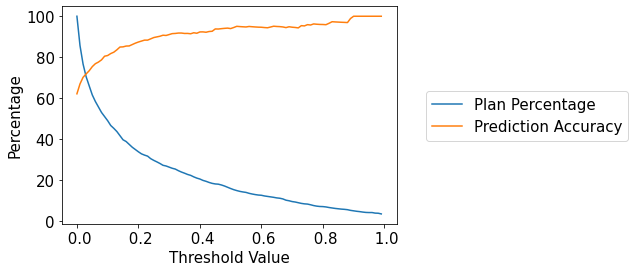

Threshold for 75% accuracy: 0.05
Plans % for 75% accuracy: 61.521252796420576
Threshold for 80% accuracy: 0.09
Plans % for 80% accuracy: 50.950782997762865
Threshold for 85% accuracy: 0.15
Plans % for 85% accuracy: 39.59731543624161
Threshold for 90% accuracy: 0.27
Plans % for 90% accuracy: 28.02013422818792
Threshold for 95% accuracy: 0.52
Plans % for 95% accuracy: 14.76510067114094


In [19]:
get_line_plot([y_confidence, y_pred_confidence], 
              range(0, len(x)+2, 20), [f'{i: .1f}' for i in np.arange(0, 1.1, 0.2)],
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], 'Threshold Value', 'Percentage', 
              styles=['-', '-'], markers=['', ''])

# plt.plot(x, y_confidence, label='Confident')
# plt.plot(x, y_pred_confidence, label='Predicted Confident')
# plt.legend()

for th in np.arange(75, 100, 5):
    print(f'Threshold for {int(th)}% accuracy: {[t for t, y in zip(x, y_pred_confidence) if y>th][0]}')
    print(f'Plans % for {int(th)}% accuracy: {[t for t, y in zip(y_confidence, y_pred_confidence) if y>th][0]}')

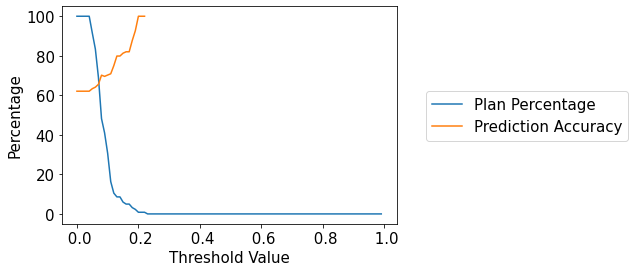

In [20]:
get_line_plot([y_risk_free, y_pred_risk_free], 
              range(0, len(x)+2, 20), [f'{i: .1f}' for i in np.arange(0, 1.1, 0.2)],
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], 'Threshold Value', 'Percentage', 
              styles=['-', '-'], markers=['', ''])
print()

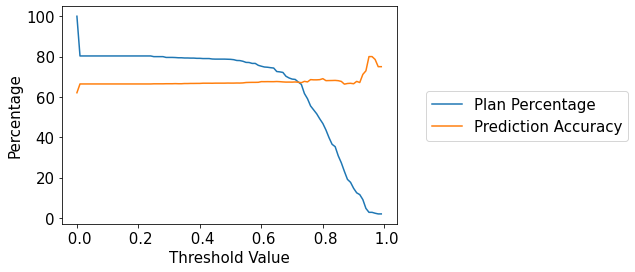

Threshold for 75% accuracy: 0.9500000000000001
Plans % for 75% accuracy: 2.796420581655481


IndexError: list index out of range

In [21]:
get_line_plot([y_precise, y_pred_precise], 
              range(0, len(x)+2, 20), [f'{i: .1f}' for i in np.arange(0, 1.1, 0.2)],
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], 'Threshold Value', 'Percentage', 
              styles=['-', '-'], markers=['', ''])
prec_thresholds = list(np.arange(75, 81, 5))
prec_thresholds.append(84)
for th in prec_thresholds:
    print(f'Threshold for {int(th)}% accuracy: {[t for t, y in zip(x, y_pred_precise) if y>th][0]}')
    print(f'Plans % for {int(th)}% accuracy: {[t for t, y in zip(y_precise, y_pred_precise) if y>th][0]}')

### Thresholds results using Depots Thresholds

In [120]:
thresholds = [0.08, 0.7]
#all_metrics, tot = get_metric(df_network, thresholds, 1, metrics_labels=['Confidence', 'Precise', 'Confidence AND Precise'])
models_list = np.arange(0, 25)
x, network_plan_percentages, network_precisions, network_times, planner_plan_percentages, planner_precisions, planner_times, only_network_precisions, only_network_times = get_metrics_for_models(models_list, 
                                                                                                                                                                                                thresholds, 
                                                                                                                                                                                                results_folder=results_folder,
                                                                                                                                                                                                verbose=0, 
                                                                                                                                                                                                use_planner=True,
                                                                                                                                                                                                metrics_labels=['Confidence', 'Precise', 'Confidence AND Precise'])

results_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/planner
results_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/planner
results_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/planner
results_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/planner
results_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/planner
results_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/planner
Model 0
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/model_0
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocks

/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_16358/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_16358/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 1
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/model_1
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/model_1
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/model_1
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/model_1
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/model_1
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/model_1
Model 2
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/blocksworld/optimal/model

In [82]:
print(only_network_times)

[0.03697963951683258, 0.03674716064060561, 0.03693309953015389, 0.03669787400517306, 0.0364321836955862, 0.03678433847107343, 0.036514835202987296, 0.03624109547143548, 0.03696562953176648, 0.03622142887222154, 0.036575727681452265, 0.03673295153334104, 0.036761260806047406, 0.03616737586006489, 0.03619041725559789, 0.036675764810318916, 0.03725834992189413, 0.036293236334585234, 0.03703595847891481, 0.03638292065669493, 0.0362756518976267, 0.036876236318407876, 0.036493664289494764, 0.03608294928100552, 0.036709906004152575]


In [103]:
blocksworld_results = {}
blocksworld_results['network_plan_percentages'] = [0.0, 1.6219239373601788, 3.803131991051454, 5.033557046979865, 5.201342281879195, 8.612975391498882, 7.718120805369128, 11.968680089485458, 16.05145413870246, 15.827740492170022, 19.686800894854585, 19.854586129753915, 25.782997762863534, 25.279642058165546, 29.194630872483224, 30.760626398210288, 30.87248322147651, 33.33333333333333, 32.662192393736014, 33.836689038031324, 36.18568232662193, 38.64653243847875, 37.75167785234899, 38.53467561521253, 38.758389261744966]
blocksworld_results['network_precisions'] = [np.nan, 34.48275862068966, 80.88235294117648, 71.11111111111111, 77.41935483870968, 72.07792207792207, 86.23188405797102, 77.57009345794393, 75.26132404181185, 84.45229681978799, 80.9659090909091, 81.40845070422536, 82.21258134490239, 83.1858407079646, 81.99233716475096, 84.36363636363636, 84.60144927536231, 83.38926174496645, 84.58904109589042, 84.79338842975207, 83.77125193199382, 83.3574529667149, 82.37037037037037, 83.16400580551525, 82.82828282828282]
blocksworld_results['network_times'] =[np.nan, 0.036511618515540814, 0.03634471402448766, 0.03585819138420953, 0.036081752469462734, 0.036163282084774664, 0.03871449353038401, 0.037642925699180534, 0.0375178275623388, 0.037156618947275115, 0.03703939372842962, 0.037082676820352045, 0.03699961349917596, 0.03640850455360075, 0.03639922607904193, 0.03682165102525191, 0.037448534499044006, 0.03631526671800037, 0.03743766636064608, 0.03644102466993095, 0.0366150426348726, 0.03694715065134935, 0.036788083888866285, 0.0358413469981732, 0.037034373262743926]
blocksworld_results['planner_plan_percentages'] = [100.0, 98.37807606263982, 96.19686800894854, 94.96644295302013, 94.79865771812081, 91.38702460850112, 92.28187919463087, 88.03131991051454, 83.94854586129753, 84.17225950782998, 80.31319910514542, 80.14541387024609, 74.21700223713647, 74.72035794183445, 70.80536912751677, 69.23937360178971, 69.12751677852349, 66.66666666666667, 67.337807606264, 66.16331096196868, 63.81431767337807, 61.35346756152125, 62.24832214765101, 61.46532438478747, 61.241610738255034]
blocksworld_results['planner_precisions'] = [98.99328859060402, 98.69243888573052, 98.31395348837209, 97.99764428739694, 98.23008849557522, 96.81762545899633, 97.45454545454545, 96.18805590851333, 95.73617588274483, 96.41196013289036, 95.12534818941504, 95.324494068388, 95.25244913338358, 95.28443113772454, 93.91785150078988, 94.34571890145395, 94.33656957928802, 92.70134228187919, 94.01993355481729, 94.25190194420964, 93.95267309377738, 93.25432999088423, 93.71069182389937, 93.81255686988172, 94.06392694063926]
blocksworld_results['planner_times'] = [10730.57795302013, 10663.657430358155, 10485.162360465112, 10731.463851590102, 10856.632843657813, 10603.694675642591, 10785.772581818179, 10416.001080050823, 9663.025176548967, 9542.24738870432, 9140.367896935932, 8369.885847871597, 8127.5327279578, 7776.7070059880225, 7841.031761453397, 6354.4139176090475, 6472.395461165051, 6068.132441275169, 6479.289352159469, 5820.6001437024515, 5387.876976336547, 4916.160492251595, 4985.436567834681, 4440.613403093721, 4365.9268767123285]
blocksworld_results['only_network_precisions'] = [6.326987681970884, 30.760626398210288, 34.34004474272931, 38.05260212646894, 43.51230425055929, 45.41387024608501, 48.15436241610738, 49.832214765100666, 50.83892617449665, 54.80984340044742, 54.69798657718121, 55.92841163310962, 57.66219239373602, 59.11633109619687, 59.395973154362416, 59.395973154362416, 60.4364857302742, 60.123042505592835, 61.40939597315436, 61.12975391498882, 62.13646532438478, 62.1152770005596, 61.44376049244544, 62.02460850111857, 62.08053691275168]
blocksworld_results['only_network_times'] = [0.03697963951683258, 0.03674716064060561, 0.03693309953015389, 0.03669787400517306, 0.0364321836955862, 0.03678433847107343, 0.036514835202987296, 0.03624109547143548, 0.03696562953176648, 0.03622142887222154, 0.036575727681452265, 0.03673295153334104, 0.036761260806047406, 0.03616737586006489, 0.03619041725559789, 0.036675764810318916, 0.03725834992189413, 0.036293236334585234, 0.03703595847891481, 0.03638292065669493, 0.0362756518976267, 0.036876236318407876, 0.036493664289494764, 0.03608294928100552, 0.036709906004152575]

In [131]:
bw_dict = {}
bw_dict['x'] = x 
bw_dict['network_plan_percentages'] = network_plan_percentages
bw_dict['network_precisions'] = network_precisions
bw_dict['network_times'] = network_times
bw_dict['planner_plan_percentages'] = planner_plan_percentages
bw_dict['planner_precisions'] = planner_precisions
bw_dict['planner_times'] = planner_times
bw_dict['only_network_precisions'] = only_network_precisions
bw_dict['only_network_times'] = only_network_times


os.makedirs(os.path.join('..', 'data', 'blocksworld'), exist_ok=True)
save_file(bw_dict, os.path.join('..', 'data', 'blocksworld'), 'blocksworld_results.pkl')

blocksworld_results.pkl saved in ../data/blocksworld


True

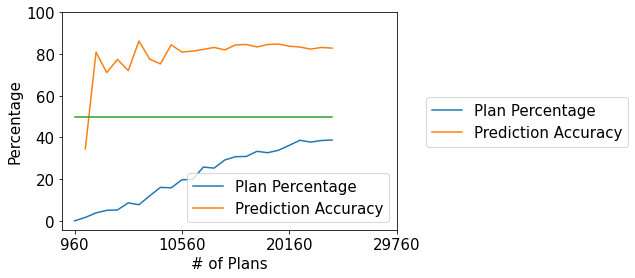

In [38]:

step = 15
models = target_model
batch_size = 64
fig, ax = get_line_plot([network_plan_percentages[2], network_precisions[2], np.ones(len(network_plan_percentages[2]))*50], 
              range(0, len(network_plan_percentages[2])+9, 10), range(step*batch_size, step*batch_size*(len(network_plan_percentages[2])+9), step*batch_size*10),
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], '# of Plans', 'Percentage', 
              styles=['-', '-', '-'], markers=['', '', ''])
print()
clear_output()
ax.legend(loc = 'best')
display(fig)

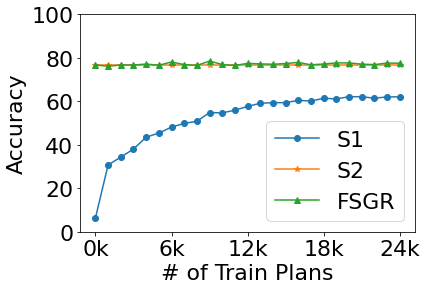

In [126]:
set_size('big', 25)
set_size('medium', 22)
overall_precisions = [planner_precisions[i] if np.isnan(network_precisions[2][i]) else planner_precisions[i]*planner_plan_percentages[i]/100 + network_precisions[2][i]*network_plan_percentages[2][i]/100 
                       for i in range(len(planner_precisions))]
fig, ax = get_line_plot([only_network_precisions, [planner_precisions[0] for _ in range(len(overall_precisions))], overall_precisions], 
              np.linspace(0, 24, 5), [f'{int(np.floor((i+1)*15*64/1000))}k' for i in np.linspace(0, 24, 5, dtype=int)],
              range(0, 101, 20), [], 
              None, '# of Train Plans', 'Accuracy', 
              styles=['-', '-', '-'], markers=['o', '*', '^'])
print()
labels = ['S1', 'S2', 'FSGR']
clear_output()
ax.legend(labels, loc = 'best')
display(fig)


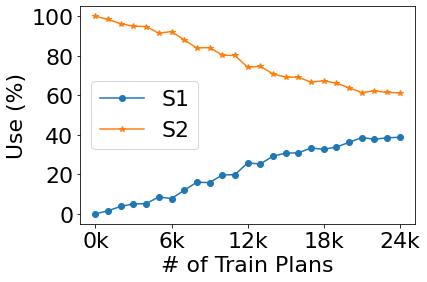

In [127]:
overall_precisions = [planner_precisions[i] if np.isnan(network_precisions[2][i]) else planner_precisions[i]*planner_plan_percentages[i]/100 + network_precisions[2][i]*network_plan_percentages[2][i]/100 
                       for i in range(len(planner_precisions))]
fig, ax = get_line_plot([network_plan_percentages[2], planner_plan_percentages], 
              np.linspace(0, 24, 5), [f'{int(np.floor((i+1)*15*64/1000))}k' for i in np.linspace(0, 24, 5, dtype=int)],
              range(0, 101, 20), [], 
              None, '# of Train Plans', 'Use (%)', 
              styles=['-', '-'], markers=['o', '*'])
clear_output()
labels = ['S1', 'S2']
ax.legend(labels, loc = 'best')
display(fig)
print()

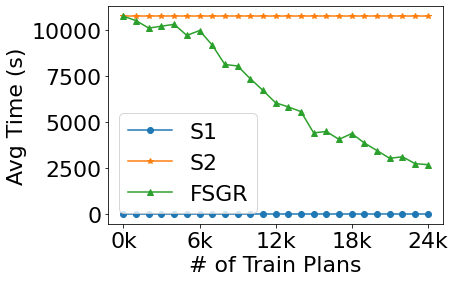

In [129]:
overall_times = [planner_times[i] if np.isnan(network_times[2][i]) else planner_times[i]*planner_plan_percentages[i]/100 + network_times[2][i]*network_plan_percentages[2][i]/100 for i in range(len(planner_times))]
fig, ax = get_line_plot([only_network_times, [planner_times[0] for _ in range(len(only_network_times))],overall_times], 
              np.linspace(0, 24, 5), [f'{int(np.floor((i+1)*15*64/1000))}k' for i in np.linspace(0, 24, 5, dtype=int)],
              np.linspace(0, 10000, 5), [], 
              None, '# of Train Plans', 'Avg Time (s)',
              styles=['-', '-', '-'], markers=['o', '*', '^'])
print()
clear_output()
labels = ['S1', 'S2', 'FSGR']
ax.legend(labels, loc = 'best')
display(fig)

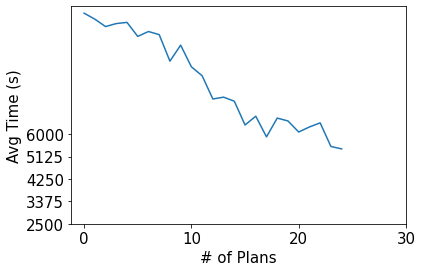

In [130]:
overall_times = [planner_times[i] if np.isnan(network_times[2][i]) else planner_times[i]*planner_plan_percentages[i]/100 + network_times[2][i]*network_plan_percentages[2][i]/100 for i in range(len(planner_times))]
get_line_plot([overall_times], 
              range(0, len(network_plan_percentages[2])+9, 10), range(step*batch_size, step*batch_size*(len(network_plan_percentages[2])+2)+1, step*batch_size*10),
              np.linspace(2500, 6000, 5), [], 
              None, '# of Plans', 'Avg Time (s)',
              styles=['-', '-', '-'], markers=['', '', ''])
print()
    

/Users/mattiachiari/miniforge3/envs/tf/lib/python3.8/site-packages/utils_unibs-0.1-py3.8.egg/utils_unibs/plots.py:369: UserWarning: The number of xticks labels is different from the number of xticks
  warnings.warn(C.TICKS_WARNING_MSG.format(axis))


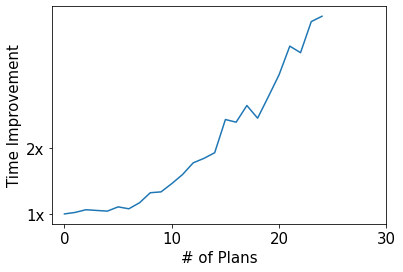

In [24]:
overall_time_improvement = [1 if np.isnan(network_times[2][i]) else planner_times[0]/(planner_times[i]*planner_plan_percentages[i]/100 + network_times[2][i]*network_plan_percentages[2][i]/100) for i in range(len(planner_times))]
max_improvement = 2
get_line_plot([overall_time_improvement], 
              range(0, len(network_plan_percentages[2])+9, 10), range(step*batch_size, step*batch_size*(len(network_plan_percentages[2])+2)+1, step*batch_size*10),
              np.linspace(1, max_improvement, max_improvement), [f'{i}x' for i in range(1, max_improvement+1)], 
              None, '# of Plans', 'Time Improvement',
              styles=['-', '-', '-'], markers=['', '', ''])
print()

## 4. Zenotravel

### Define variables

In [12]:
results_folder = '/Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/'
target_model = 24
r_confidence = np.arange(0.00, 1, 0.01)
r_precision = np.arange(0.00, 1, 0.01)
r_risk = np.arange(0.00, 1, 0.01)

### Import results json

In [133]:
df_planner_dict = create_df_dict_planner(results_folder, verbose=1)

results_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/planner
results_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/planner
results_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/planner
results_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/planner
results_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/planner
results_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/planner
results_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/planner


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p004707,classic_goal_2,ottimo,classic_goal_2_p004707.sol,NoValidationPerformed,NaN,2.72,0.096,11,0.073168,136
1,p004516,classic_goal_3,ottimo,classic_goal_3_p004516.sol,NoValidationPerformed,NaN,2.90,0.143,11,0.112163,172
2,p004516,classic_goal_4,ottimo,classic_goal_4_p004516.sol,NoValidationPerformed,NaN,3.08,0.104,11,0.088938,147
3,p004594,classic_goal_7,ottimo,classic_goal_7_p004594.sol,NoValidationPerformed,NaN,3.19,0.310,13,0.122029,1019
4,p004707,classic_goal_1,ottimo,classic_goal_1_p004707.sol,NoValidationPerformed,NaN,3.14,0.178,11,0.144061,389
...,...,...,...,...,...,...,...,...,...,...,...
3195,p004712,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p004712.sol,NoValidationPerformed,NaN,1.03,0.389,19,0.298034,419
3196,p004715,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p004715.sol,NoValidationPerformed,NaN,0.70,0.325,14,0.022274,15
3197,p004738,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p004738.sol,NoValidationPerformed,NaN,4.10,0.258,21,3.520190,6186
3198,p004965,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p004965.sol,NoValidationPerformed,NaN,42.27,0.297,24,41.596500,110083


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p002569,classic_goal_1,ottimo,classic_goal_1_p002569.sol,NoValidationPerformed,NaN,2.71,0.693,8.0,0.025253,64.0
1,p002987,classic_goal_4,ottimo,classic_goal_4_p002987.sol,NoValidationPerformed,NaN,2.80,0.369,16.0,0.144869,3157.0
2,p002013,classic_goal_4,ottimo,classic_goal_4_p002013.sol,NoValidationPerformed,NaN,2.73,0.857,7.0,0.060502,544.0
3,p002071,classic_goal_3,ottimo,classic_goal_3_p002071.sol,NoValidationPerformed,NaN,2.75,0.752,6.0,0.022373,46.0
4,p002731,classic_goal_1,ottimo,classic_goal_1_p002731.sol,NoValidationPerformed,NaN,2.82,0.809,10.0,0.095034,2723.0
...,...,...,...,...,...,...,...,...,...,...,...
2395,p002090,constraints_constraint50_goal_4,pac_ottimo,constraints_constraint50_goal_4_p002090.sol,NoValidationPerformed,NaN,85.88,0.709,21.0,84.678400,50981.0
2396,p002347,constraints_constraint50_goal_4,pac_ottimo,constraints_constraint50_goal_4_p002347.sol,NoValidationPerformed,NaN,796.72,0.721,24.0,794.978000,717232.0
2397,p002686,constraints_constraint50_goal_4,pac_ottimo,NO SOLUTION,NaN,NaN,1800.01,NaN,NaN,NaN,NaN
2398,p002989,constraints_constraint50_goal_4,pac_ottimo,NO SOLUTION,NaN,NaN,1800.01,NaN,NaN,NaN,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p001481,classic_goal_5,ottimo,classic_goal_5_p001481.sol,NoValidationPerformed,NaN,5.24,0.231,9,0.119198,154
1,p001542,classic_goal_5,ottimo,classic_goal_5_p001542.sol,NoValidationPerformed,NaN,5.43,0.241,12,0.100586,3146
2,p001217,classic_goal_0,ottimo,classic_goal_0_p001217.sol,NoValidationPerformed,NaN,5.24,0.268,12,0.038180,1696
3,p001972,classic_goal_1,ottimo,classic_goal_1_p001972.sol,NoValidationPerformed,NaN,5.17,0.143,9,0.024397,399
4,p001872,classic_goal_3,ottimo,classic_goal_3_p001872.sol,NoValidationPerformed,NaN,5.06,0.201,6,0.011798,37
...,...,...,...,...,...,...,...,...,...,...,...
2395,p001817,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p001817.sol,NoValidationPerformed,NaN,4.14,0.156,23,3.635360,16081
2396,p001854,constraints_constraint70_goal_3,pac_ottimo,constraints_constraint70_goal_3_p001854.sol,NoValidationPerformed,NaN,14.77,0.152,19,14.289400,68110
2397,p001048,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p001048.sol,NoValidationPerformed,NaN,1.15,0.239,17,0.522907,916
2398,p001064,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p001064.sol,NoValidationPerformed,NaN,0.53,0.174,12,0.027388,41


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p000111,classic_goal_5,ottimo,classic_goal_5_p000111.sol,NoValidationPerformed,NaN,2.11,1.198,9.0,0.040371,155.0
1,p000013,classic_goal_8,ottimo,classic_goal_8_p000013.sol,NoValidationPerformed,NaN,2.34,0.311,8.0,0.053144,187.0
2,p000067,classic_goal_6,ottimo,classic_goal_6_p000067.sol,NoValidationPerformed,NaN,2.72,0.423,16.0,0.474488,2435.0
3,p000393,classic_goal_6,ottimo,classic_goal_6_p000393.sol,NoValidationPerformed,NaN,3.03,0.331,15.0,0.565171,6346.0
4,p000362,classic_goal_4,ottimo,classic_goal_4_p000362.sol,NoValidationPerformed,NaN,3.06,0.293,15.0,0.635115,6300.0
...,...,...,...,...,...,...,...,...,...,...,...
3155,p000882,constraints_constraint50_goal_7,pac_ottimo,NO SOLUTION,NaN,NaN,1800.01,NaN,NaN,NaN,NaN
3156,p000769,constraints_constraint50_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.02,NaN,NaN,NaN,NaN
3157,p000710,constraints_constraint50_goal_7,pac_ottimo,NO SOLUTION,NaN,NaN,1800.01,NaN,NaN,NaN,NaN
3158,p000625,constraints_constraint50_goal_7,pac_ottimo,NO SOLUTION,NaN,NaN,1800.03,NaN,NaN,NaN,NaN


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p003502,classic_goal_4,ottimo,classic_goal_4_p003502.sol,NoValidationPerformed,NaN,9.07,1.693,14.0,2.71152,23748.0
1,p003795,classic_goal_2,ottimo,classic_goal_2_p003795.sol,NoValidationPerformed,NaN,15.47,0.280,17.0,9.29545,63156.0
2,p003915,classic_goal_5,ottimo,classic_goal_5_p003915.sol,NoValidationPerformed,NaN,17.56,1.397,20.0,10.89540,72780.0
3,p003581,classic_goal_5,ottimo,classic_goal_5_p003581.sol,NoValidationPerformed,NaN,20.33,1.776,15.0,13.63820,61850.0
4,p003638,classic_goal_4,ottimo,classic_goal_4_p003638.sol,NoValidationPerformed,NaN,19.68,0.358,18.0,13.43270,96583.0
...,...,...,...,...,...,...,...,...,...,...,...
1171,p003795,constraints_constraint50_goal_4,pac_ottimo,NO SOLUTION,NaN,NaN,1800.02,NaN,NaN,NaN,NaN
1172,p003502,constraints_constraint70_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.01,NaN,NaN,NaN,NaN
1173,p003581,constraints_constraint70_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN
1174,p003977,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p003977.sol,NoValidationPerformed,NaN,1498.52,1.123,33.0,1495.65000,598433.0


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p006144,classic_goal_4,ottimo,classic_goal_4_p006144.sol,NoValidationPerformed,NaN,6.94,1.313,7.0,0.025230,37.0
1,p006995,classic_goal_5,ottimo,classic_goal_5_p006995.sol,NoValidationPerformed,NaN,6.97,1.218,9.0,0.018524,119.0
2,p006126,classic_goal_0,ottimo,classic_goal_0_p006126.sol,NoValidationPerformed,NaN,7.23,1.425,12.0,0.278055,2284.0
3,p006452,classic_goal_2,ottimo,classic_goal_2_p006452.sol,NoValidationPerformed,NaN,6.97,1.016,9.0,0.149047,973.0
4,p006887,classic_goal_5,ottimo,classic_goal_5_p006887.sol,NoValidationPerformed,NaN,7.08,1.181,10.0,0.256737,3192.0
...,...,...,...,...,...,...,...,...,...,...,...
2347,p006887,constraints_constraint70_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN
2348,p006825,constraints_constraint50_goal_2,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN
2349,p006642,constraints_constraint70_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.03,NaN,NaN,NaN,NaN
2350,p006647,constraints_constraint70_goal_0,pac_ottimo,constraints_constraint70_goal_0_p006647.sol,NoValidationPerformed,NaN,144.67,0.465,26.0,143.797000,61266.0


,INSTANCE,DOMAIN,SYSTEM,SOLUTION,VALIDATED,VALIDATOR_VALUE,TOTALRUNTIME,FD_PREPROCESSOR_RUNTIME,FD_PLAN_STEPS,FD_SEARCH_TIME,FD_EXPANDED_NODES
0,p005280,classic_goal_3,ottimo,classic_goal_3_p005280.sol,NoValidationPerformed,NaN,7.57,0.539,15.0,1.16207,5913.0
1,p005775,classic_goal_0,ottimo,classic_goal_0_p005775.sol,NoValidationPerformed,NaN,9.23,0.609,13.0,1.65838,23148.0
2,p005403,classic_goal_1,ottimo,classic_goal_1_p005403.sol,NoValidationPerformed,NaN,10.61,0.640,15.0,4.19688,16985.0
3,p005580,classic_goal_4,ottimo,classic_goal_4_p005580.sol,NoValidationPerformed,NaN,12.98,0.299,16.0,7.11083,33514.0
4,p005813,classic_goal_4,ottimo,classic_goal_4_p005813.sol,NoValidationPerformed,NaN,15.14,0.361,17.0,8.69318,40527.0
...,...,...,...,...,...,...,...,...,...,...,...
1195,p005453,constraints_constraint70_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN
1196,p005538,constraints_constraint70_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.01,NaN,NaN,NaN,NaN
1197,p005583,constraints_constraint70_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.00,NaN,NaN,NaN,NaN
1198,p005600,constraints_constraint70_goal_0,pac_ottimo,NO SOLUTION,NaN,NaN,1800.01,NaN,NaN,NaN,NaN


In [10]:
df_network = create_df_dict_network(target_model, results_folder=results_folder, verbose=1)

network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_24
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_24
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_24
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_24
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_24
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_24
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_24


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,0,1,2,3,4,5,6,7,PREDICTED
0,14 32 37 39 63,21 22 25 32 61,24 37 52 61 64,1 22 23 24 29,1 21 62 63 64,23 25 39 52 63,14 15 32 48 61,21 22 31 57 62,0.34969,1.36506,0.31351,1.25537,0.31648,0.29552,0.41703,1.19386,False
1,14 32 37 39 63,21 22 25 32 61,24 37 52 61 64,1 22 23 24 29,1 21 62 63 64,23 25 39 52 63,14 15 32 48 61,21 22 31 57 62,2.20704,1.08088,0.52793,0.22341,1.55707,1.31181,1.17450,0.12525,True
2,14 32 37 39 63,21 22 25 32 61,24 37 52 61 64,1 22 23 24 29,1 21 62 63 64,23 25 39 52 63,14 15 32 48 61,21 22 31 57 62,0.27131,1.40384,0.61567,0.43831,1.28081,0.30035,0.45644,1.39176,True
3,14 32 37 39 63,21 22 25 32 61,24 37 52 61 64,1 22 23 24 29,1 21 62 63 64,23 25 39 52 63,14 15 32 48 61,21 22 31 57 62,0.28261,1.53296,0.49741,1.25330,0.54489,0.52290,0.30176,1.48015,False
4,14 32 37 39 63,21 22 25 32 61,24 37 52 61 64,1 22 23 24 29,1 21 62 63 64,23 25 39 52 63,14 15 32 48 61,21 22 31 57 62,2.20984,0.25071,1.35224,0.41864,0.26464,1.20532,0.26983,0.19296,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,14 32 37 39 63,21 22 25 32 61,24 37 52 61 64,1 22 23 24 29,1 21 62 63 64,23 25 39 52 63,14 15 32 48 61,21 22 31 57 62,0.32565,0.21613,1.26949,3.23103,1.25093,1.32371,0.23242,0.21141,True
296,14 32 37 39 63,21 22 25 32 61,24 37 52 61 64,1 22 23 24 29,1 21 62 63 64,23 25 39 52 63,14 15 32 48 61,21 22 31 57 62,1.02755,1.03120,4.95160,1.05479,0.99171,1.02541,1.03394,0.03691,True
297,14 32 37 39 63,21 22 25 32 61,24 37 52 61 64,1 22 23 24 29,1 21 62 63 64,23 25 39 52 63,14 15 32 48 61,21 22 31 57 62,1.14957,3.12133,0.14254,1.23743,0.16684,1.14195,1.13173,1.14218,True
298,14 32 37 39 63,21 22 25 32 61,24 37 52 61 64,1 22 23 24 29,1 21 62 63 64,23 25 39 52 63,14 15 32 48 61,21 22 31 57 62,0.30711,0.22922,1.21533,3.18984,1.22767,1.30132,0.16181,0.22780,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,0,1,2,3,4,5,PREDICTED
0,14 20 23 48 57,21 32 48 62 63,4 15 52 62 64,5 15 24 52 61,1 20 22 25 29 37,4 23 24 30 47 52,0.58411,0.38204,0.20347,2.21129,0.42813,0.54630,True
1,14 20 23 48 57,21 32 48 62 63,4 15 52 62 64,5 15 24 52 61,1 20 22 25 29 37,4 23 24 30 47 52,0.48374,0.71347,0.32304,2.21076,0.58876,1.40021,True
2,14 20 23 48 57,21 32 48 62 63,4 15 52 62 64,5 15 24 52 61,1 20 22 25 29 37,4 23 24 30 47 52,0.30272,0.15805,0.10249,0.28019,3.34058,0.13443,True
3,14 20 23 48 57,21 32 48 62 63,4 15 52 62 64,5 15 24 52 61,1 20 22 25 29 37,4 23 24 30 47 52,0.18710,2.30064,0.27461,0.38607,0.35487,0.40031,True
4,14 20 23 48 57,21 32 48 62 63,4 15 52 62 64,5 15 24 52 61,1 20 22 25 29 37,4 23 24 30 47 52,2.19993,1.33031,0.38587,0.35301,1.55105,0.30825,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,14 20 23 48 57,21 32 48 62 63,4 15 52 62 64,5 15 24 52 61,1 20 22 25 29 37,4 23 24 30 47 52,0.26871,0.34347,1.16528,2.11772,0.45234,3.25704,True
296,14 20 23 48 57,21 32 48 62 63,4 15 52 62 64,5 15 24 52 61,1 20 22 25 29 37,4 23 24 30 47 52,0.13823,0.12565,4.03452,2.20930,0.18778,2.31046,True
297,14 20 23 48 57,21 32 48 62 63,4 15 52 62 64,5 15 24 52 61,1 20 22 25 29 37,4 23 24 30 47 52,1.41787,2.21846,0.34300,0.38310,0.31967,0.28038,True
298,14 20 23 48 57,21 32 48 62 63,4 15 52 62 64,5 15 24 52 61,1 20 22 25 29 37,4 23 24 30 47 52,1.29258,3.19421,1.31715,0.44742,0.33466,0.20465,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,0,1,2,3,4,5,PREDICTED
0,15 25 29 52 60 64,14 23 29 36 52 64,21 22 24 32 44 63,23 25 31 36 48 57,22 23 25 32 60 63,23 24 44 48 57 63,1.75437,1.56960,0.73541,0.77198,0.95264,0.60499,False
1,15 25 29 52 60 64,14 23 29 36 52 64,21 22 24 32 44 63,23 25 31 36 48 57,22 23 25 32 60 63,23 24 44 48 57 63,1.61788,1.70658,1.00211,0.59255,1.07728,0.62065,True
2,15 25 29 52 60 64,14 23 29 36 52 64,21 22 24 32 44 63,23 25 31 36 48 57,22 23 25 32 60 63,23 24 44 48 57 63,1.25397,1.28696,1.19889,2.22262,3.17919,1.18265,True
3,15 25 29 52 60 64,14 23 29 36 52 64,21 22 24 32 44 63,23 25 31 36 48 57,22 23 25 32 60 63,23 24 44 48 57 63,0.44684,0.43227,1.58871,0.19770,0.28205,1.25888,True
4,15 25 29 52 60 64,14 23 29 36 52 64,21 22 24 32 44 63,23 25 31 36 48 57,22 23 25 32 60 63,23 24 44 48 57 63,1.54022,1.52325,0.55927,0.61803,0.60951,0.59570,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,15 25 29 52 60 64,14 23 29 36 52 64,21 22 24 32 44 63,23 25 31 36 48 57,22 23 25 32 60 63,23 24 44 48 57 63,0.26939,0.26783,3.20938,0.15507,1.22566,1.16353,True
296,15 25 29 52 60 64,14 23 29 36 52 64,21 22 24 32 44 63,23 25 31 36 48 57,22 23 25 32 60 63,23 24 44 48 57 63,0.42210,0.50215,2.64636,0.31869,1.46572,1.42450,True
297,15 25 29 52 60 64,14 23 29 36 52 64,21 22 24 32 44 63,23 25 31 36 48 57,22 23 25 32 60 63,23 24 44 48 57 63,1.36488,0.36286,0.25858,2.36102,1.32632,0.26941,True
298,15 25 29 52 60 64,14 23 29 36 52 64,21 22 24 32 44 63,23 25 31 36 48 57,22 23 25 32 60 63,23 24 44 48 57 63,0.42674,1.55620,1.54581,1.31665,2.44925,2.32403,False


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,GOAL_6,GOAL_7,GOAL_8,GOAL_9,...,1,2,3,4,5,6,7,8,9,PREDICTED
0,0 21 24 30 32 36 38 50,9 21 24 39 42 52 61 65,0 10 35 37 42 45 52 64,6 15 22 25 28 29 47 49,5 22 24 32 36 37 50 61,20 23 24 29 33 36 39 57,5 21 22 24 31 32 42 65,1 5 22 29 40 49 50 55,4 5 28 32 34 48 49 62,22 29 34 47 49 56 62 65,...,0.62493,0.50429,0.63261,0.43721,0.51614,0.73489,0.46154,1.80897,2.85197,True
1,0 21 24 30 32 36 38 50,9 21 24 39 42 52 61 65,0 10 35 37 42 45 52 64,6 15 22 25 28 29 47 49,5 22 24 32 36 37 50 61,20 23 24 29 33 36 39 57,5 21 22 24 31 32 42 65,1 5 22 29 40 49 50 55,4 5 28 32 34 48 49 62,22 29 34 47 49 56 62 65,...,0.67479,0.96263,0.92793,0.73611,0.72625,0.79715,1.06653,0.96336,0.75943,False
2,0 21 24 30 32 36 38 50,9 21 24 39 42 52 61 65,0 10 35 37 42 45 52 64,6 15 22 25 28 29 47 49,5 22 24 32 36 37 50 61,20 23 24 29 33 36 39 57,5 21 22 24 31 32 42 65,1 5 22 29 40 49 50 55,4 5 28 32 34 48 49 62,22 29 34 47 49 56 62 65,...,0.76262,0.80935,0.76819,0.75276,0.72863,0.76040,1.07049,0.76175,0.74690,False
3,0 21 24 30 32 36 38 50,9 21 24 39 42 52 61 65,0 10 35 37 42 45 52 64,6 15 22 25 28 29 47 49,5 22 24 32 36 37 50 61,20 23 24 29 33 36 39 57,5 21 22 24 31 32 42 65,1 5 22 29 40 49 50 55,4 5 28 32 34 48 49 62,22 29 34 47 49 56 62 65,...,1.83858,0.81704,0.77929,1.86603,1.76584,2.20836,1.03977,0.98224,0.81614,True
4,0 21 24 30 32 36 38 50,9 21 24 39 42 52 61 65,0 10 35 37 42 45 52 64,6 15 22 25 28 29 47 49,5 22 24 32 36 37 50 61,20 23 24 29 33 36 39 57,5 21 22 24 31 32 42 65,1 5 22 29 40 49 50 55,4 5 28 32 34 48 49 62,22 29 34 47 49 56 62 65,...,0.63031,0.71629,1.71372,0.69087,0.72747,0.61291,0.76053,1.78326,0.66779,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,0 21 24 30 32 36 38 50,9 21 24 39 42 52 61 65,0 10 35 37 42 45 52 64,6 15 22 25 28 29 47 49,5 22 24 32 36 37 50 61,20 23 24 29 33 36 39 57,5 21 22 24 31 32 42 65,1 5 22 29 40 49 50 55,4 5 28 32 34 48 49 62,22 29 34 47 49 56 62 65,...,1.30416,1.48641,0.47834,4.31737,1.34507,2.62443,2.43919,1.50359,0.43546,True
233,0 21 24 30 32 36 38 50,9 21 24 39 42 52 61 65,0 10 35 37 42 45 52 64,6 15 22 25 28 29 47 49,5 22 24 32 36 37 50 61,20 23 24 29 33 36 39 57,5 21 22 24 31 32 42 65,1 5 22 29 40 49 50 55,4 5 28 32 34 48 49 62,22 29 34 47 49 56 62 65,...,1.32011,0.12835,0.56119,0.36402,4.38909,0.51258,0.30783,0.24359,0.28141,True
234,0 21 24 30 32 36 38 50,9 21 24 39 42 52 61 65,0 10 35 37 42 45 52 64,6 15 22 25 28 29 47 49,5 22 24 32 36 37 50 61,20 23 24 29 33 36 39 57,5 21 22 24 31 32 42 65,1 5 22 29 40 49 50 55,4 5 28 32 34 48 49 62,22 29 34 47 49 56 62 65,...,1.06120,0.97076,1.12081,5.91567,1.07142,4.13421,3.08131,2.08479,1.11672,True
235,0 21 24 30 32 36 38 50,9 21 24 39 42 52 61 65,0 10 35 37 42 45 52 64,6 15 22 25 28 29 47 49,5 22 24 32 36 37 50 61,20 23 24 29 33 36 39 57,5 21 22 24 31 32 42 65,1 5 22 29 40 49 50 55,4 5 28 32 34 48 49 62,22 29 34 47 49 56 62 65,...,2.32059,0.37646,0.32531,1.32443,4.36874,1.28541,0.41093,0.29470,0.31765,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,0,1,2,3,4,5,PREDICTED
0,9 15 22 26 31 32 45 65,5 14 22 27 32 40 58 61,4 8 20 21 33 39 55 57,9 16 23 29 35 39 45 57,0 1 25 35 40 47 51 54,3 14 20 23 28 52 54 61,0.19708,0.27383,4.31629,1.31155,0.19146,1.79154,True
1,9 15 22 26 31 32 45 65,5 14 22 27 32 40 58 61,4 8 20 21 33 39 55 57,9 16 23 29 35 39 45 57,0 1 25 35 40 47 51 54,3 14 20 23 28 52 54 61,0.49638,2.45914,0.64675,0.92976,1.08991,1.61402,True
2,9 15 22 26 31 32 45 65,5 14 22 27 32 40 58 61,4 8 20 21 33 39 55 57,9 16 23 29 35 39 45 57,0 1 25 35 40 47 51 54,3 14 20 23 28 52 54 61,1.28260,4.13975,0.18996,0.22989,0.22308,1.13483,True
3,9 15 22 26 31 32 45 65,5 14 22 27 32 40 58 61,4 8 20 21 33 39 55 57,9 16 23 29 35 39 45 57,0 1 25 35 40 47 51 54,3 14 20 23 28 52 54 61,1.06159,0.79355,0.68643,0.71953,1.85791,0.69750,True
4,9 15 22 26 31 32 45 65,5 14 22 27 32 40 58 61,4 8 20 21 33 39 55 57,9 16 23 29 35 39 45 57,0 1 25 35 40 47 51 54,3 14 20 23 28 52 54 61,0.57242,2.46310,0.59629,0.52223,1.78277,0.73435,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,9 15 22 26 31 32 45 65,5 14 22 27 32 40 58 61,4 8 20 21 33 39 55 57,9 16 23 29 35 39 45 57,0 1 25 35 40 47 51 54,3 14 20 23 28 52 54 61,1.61336,0.52376,0.32682,3.48787,0.57976,1.52548,True
143,9 15 22 26 31 32 45 65,5 14 22 27 32 40 58 61,4 8 20 21 33 39 55 57,9 16 23 29 35 39 45 57,0 1 25 35 40 47 51 54,3 14 20 23 28 52 54 61,2.22388,0.16024,2.11093,6.21406,0.34353,0.12001,True
144,9 15 22 26 31 32 45 65,5 14 22 27 32 40 58 61,4 8 20 21 33 39 55 57,9 16 23 29 35 39 45 57,0 1 25 35 40 47 51 54,3 14 20 23 28 52 54 61,0.36478,1.30056,0.40461,0.31838,4.24361,1.32552,True
145,9 15 22 26 31 32 45 65,5 14 22 27 32 40 58 61,4 8 20 21 33 39 55 57,9 16 23 29 35 39 45 57,0 1 25 35 40 47 51 54,3 14 20 23 28 52 54 61,0.28399,0.36099,5.14535,2.20177,0.31247,1.26474,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,0,1,2,3,4,5,PREDICTED
0,2 20 23 29 32 45 48,2 10 14 40 48 52 63,1 15 24 38 44 61 64,5 14 37 44 56 61 64,23 24 39 47 56 60 61,10 18 22 23 25 57 61,0.27523,1.43983,2.45975,3.29303,1.28960,1.54388,True
1,2 20 23 29 32 45 48,2 10 14 40 48 52 63,1 15 24 38 44 61 64,5 14 37 44 56 61 64,23 24 39 47 56 60 61,10 18 22 23 25 57 61,0.51040,1.43175,2.54909,3.40699,1.62260,1.58067,True
2,2 20 23 29 32 45 48,2 10 14 40 48 52 63,1 15 24 38 44 61 64,5 14 37 44 56 61 64,23 24 39 47 56 60 61,10 18 22 23 25 57 61,0.93974,0.51993,1.57023,1.78222,1.78410,1.51693,False
3,2 20 23 29 32 45 48,2 10 14 40 48 52 63,1 15 24 38 44 61 64,5 14 37 44 56 61 64,23 24 39 47 56 60 61,10 18 22 23 25 57 61,0.27305,0.44546,1.54544,1.28572,1.47980,2.42662,True
4,2 20 23 29 32 45 48,2 10 14 40 48 52 63,1 15 24 38 44 61 64,5 14 37 44 56 61 64,23 24 39 47 56 60 61,10 18 22 23 25 57 61,3.29121,1.32606,0.56745,0.44876,1.60488,1.38399,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2 20 23 29 32 45 48,2 10 14 40 48 52 63,1 15 24 38 44 61 64,5 14 37 44 56 61 64,23 24 39 47 56 60 61,10 18 22 23 25 57 61,4.17337,1.10644,0.28368,0.37810,1.32177,1.17981,True
290,2 20 23 29 32 45 48,2 10 14 40 48 52 63,1 15 24 38 44 61 64,5 14 37 44 56 61 64,23 24 39 47 56 60 61,10 18 22 23 25 57 61,1.29291,1.36379,0.45468,0.30200,1.30948,3.18416,True
291,2 20 23 29 32 45 48,2 10 14 40 48 52 63,1 15 24 38 44 61 64,5 14 37 44 56 61 64,23 24 39 47 56 60 61,10 18 22 23 25 57 61,4.09561,1.10148,0.23133,0.21376,1.14290,1.07229,True
292,2 20 23 29 32 45 48,2 10 14 40 48 52 63,1 15 24 38 44 61 64,5 14 37 44 56 61 64,23 24 39 47 56 60 61,10 18 22 23 25 57 61,0.41510,0.46965,1.61631,0.52728,3.37997,0.43505,True


,GOAL_0,GOAL_1,GOAL_2,GOAL_3,GOAL_4,GOAL_5,0,1,2,3,4,5,PREDICTED
0,0 8 24 35 40 47 53 57 64,1 4 10 15 16 50 53 62 64,5 23 31 35 46 51 54 56 62,6 14 16 21 28 38 54 60 63,9 15 27 30 36 52 61 62 65,5 11 23 26 29 45 48 52 58,0.64379,0.50131,0.73326,3.63524,1.14989,0.53722,True
1,0 8 24 35 40 47 53 57 64,1 4 10 15 16 50 53 62 64,5 23 31 35 46 51 54 56 62,6 14 16 21 28 38 54 60 63,9 15 27 30 36 52 61 62 65,5 11 23 26 29 45 48 52 58,0.74837,0.84411,0.59511,0.58740,0.61396,2.41482,True
2,0 8 24 35 40 47 53 57 64,1 4 10 15 16 50 53 62 64,5 23 31 35 46 51 54 56 62,6 14 16 21 28 38 54 60 63,9 15 27 30 36 52 61 62 65,5 11 23 26 29 45 48 52 58,1.47150,3.55633,1.37320,0.48304,1.38818,0.37649,True
3,0 8 24 35 40 47 53 57 64,1 4 10 15 16 50 53 62 64,5 23 31 35 46 51 54 56 62,6 14 16 21 28 38 54 60 63,9 15 27 30 36 52 61 62 65,5 11 23 26 29 45 48 52 58,0.74637,1.49568,1.42781,3.64239,0.48755,0.75769,True
4,0 8 24 35 40 47 53 57 64,1 4 10 15 16 50 53 62 64,5 23 31 35 46 51 54 56 62,6 14 16 21 28 38 54 60 63,9 15 27 30 36 52 61 62 65,5 11 23 26 29 45 48 52 58,0.41906,1.49693,1.70101,0.34578,4.47056,0.69141,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0 8 24 35 40 47 53 57 64,1 4 10 15 16 50 53 62 64,5 23 31 35 46 51 54 56 62,6 14 16 21 28 38 54 60 63,9 15 27 30 36 52 61 62 65,5 11 23 26 29 45 48 52 58,0.34004,2.13360,1.45827,0.15119,6.09537,1.24511,True
146,0 8 24 35 40 47 53 57 64,1 4 10 15 16 50 53 62 64,5 23 31 35 46 51 54 56 62,6 14 16 21 28 38 54 60 63,9 15 27 30 36 52 61 62 65,5 11 23 26 29 45 48 52 58,0.24156,0.45883,0.27322,0.43407,5.21085,0.40792,True
147,0 8 24 35 40 47 53 57 64,1 4 10 15 16 50 53 62 64,5 23 31 35 46 51 54 56 62,6 14 16 21 28 38 54 60 63,9 15 27 30 36 52 61 62 65,5 11 23 26 29 45 48 52 58,1.31670,5.15445,1.21334,1.16489,1.14524,0.14249,True
148,0 8 24 35 40 47 53 57 64,1 4 10 15 16 50 53 62 64,5 23 31 35 46 51 54 56 62,6 14 16 21 28 38 54 60 63,9 15 27 30 36 52 61 62 65,5 11 23 26 29 45 48 52 58,0.59034,0.54555,1.54564,0.39922,1.39121,4.44110,True


### Compute thresholds for the metrics with model 38

In [11]:
x, y_confidence, y_pred_confidence = get_metrics_in_range(df_network, 0, r_confidence, 0, ['Confidence', 'Confidence2'])
x, y_risk_free, y_pred_risk_free = get_metrics_in_range(df_network, 0, r_risk, 0, ['Risk Free', 'Risk Free2'])
x, y_precise, y_pred_precise = get_metrics_in_range(df_network, 0, r_precision, 0, ['Precise', 'Precise2'])

/Users/mattiachiari/miniforge3/envs/tf/lib/python3.8/site-packages/utils_unibs-0.1-py3.8.egg/utils_unibs/plots.py:369: UserWarning: The number of yticks labels is different from the number of yticks
  warnings.warn(C.TICKS_WARNING_MSG.format(axis))


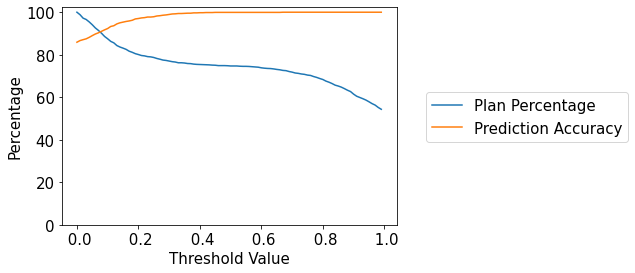

Threshold for 75% accuracy: 0.0
Plans % for 75% accuracy: 100.0
Threshold for 80% accuracy: 0.0
Plans % for 80% accuracy: 100.0
Threshold for 85% accuracy: 0.0
Plans % for 85% accuracy: 100.0
Threshold for 90% accuracy: 0.07
Plans % for 90% accuracy: 91.43518518518519
Threshold for 95% accuracy: 0.14
Plans % for 95% accuracy: 83.62268518518519


In [12]:
get_line_plot([y_confidence, y_pred_confidence], 
              range(0, len(x)+2, 20), [f'{i: .1f}' for i in np.arange(0, 1.1, 0.2)],
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], 'Threshold Value', 'Percentage', 
              styles=['-', '-'], markers=['', ''])

# plt.plot(x, y_confidence, label='Confident')
# plt.plot(x, y_pred_confidence, label='Predicted Confident')
# plt.legend()

for th in np.arange(75, 100, 5):
    print(f'Threshold for {int(th)}% accuracy: {[t for t, y in zip(x, y_pred_confidence) if y>th][0]}')
    print(f'Plans % for {int(th)}% accuracy: {[t for t, y in zip(y_confidence, y_pred_confidence) if y>th][0]}')

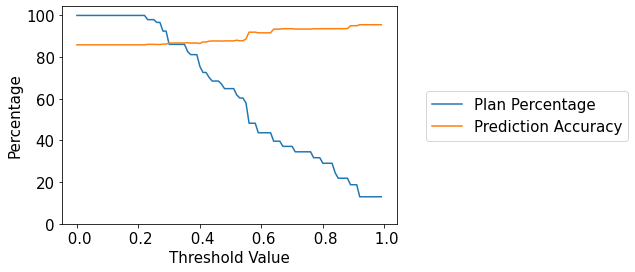

In [13]:
get_line_plot([y_risk_free, y_pred_risk_free], 
              range(0, len(x)+2, 20), [f'{i: .1f}' for i in np.arange(0, 1.1, 0.2)],
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], 'Threshold Value', 'Percentage', 
              styles=['-', '-'], markers=['', ''])
print()

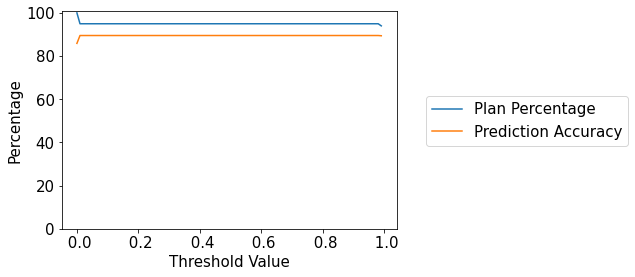

Threshold for 75% accuracy: 0.0
Plans % for 75% accuracy: 100.0
Threshold for 80% accuracy: 0.0
Plans % for 80% accuracy: 100.0
Threshold for 84% accuracy: 0.0
Plans % for 84% accuracy: 100.0


In [14]:
get_line_plot([y_precise, y_pred_precise], 
              range(0, len(x)+2, 20), [f'{i: .1f}' for i in np.arange(0, 1.1, 0.2)],
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], 'Threshold Value', 'Percentage', 
              styles=['-', '-'], markers=['', ''])
prec_thresholds = list(np.arange(75, 81, 5))
prec_thresholds.append(84)
for th in prec_thresholds:
    print(f'Threshold for {int(th)}% accuracy: {[t for t, y in zip(x, y_pred_precise) if y>th][0]}')
    print(f'Plans % for {int(th)}% accuracy: {[t for t, y in zip(y_precise, y_pred_precise) if y>th][0]}')

### Thresholds results using Depots Thresholds

In [13]:
thresholds = [0.08, 0.8]
#all_metrics, tot = get_metric(df_network, thresholds, 1, metrics_labels=['Confidence', 'Precise', 'Confidence AND Precise'])
models_list = np.arange(0, target_model+1)
x, network_plan_percentages, network_precisions, network_times, planner_plan_percentages, planner_precisions, planner_times, only_network_precisions, only_network_times = get_metrics_for_models(models_list, 
                                                                                                                                                                                                thresholds, 
                                                                                                                                                                                                results_folder=results_folder,
                                                                                                                                                                                                verbose=0, 
                                                                                                                                                                                                use_planner=True,
                                                                                                                                                                                                metrics_labels=['Confidence', 'Precise', 'Confidence AND Precise'])

results_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/planner
results_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/planner
results_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/planner
results_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/planner
results_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/planner
results_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/planner
results_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/planner
Model 0
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_0
netwo

/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:134: RuntimeWarning: invalid value encountered in double_scalars
  precision = network_metrics[i][1]/network_metrics[i][0]*100
/var/folders/3y/pqlwvgvs0zv0sz3xdnjk_08r0000gn/T/ipykernel_3820/1447561972.py:135: RuntimeWarning: invalid value encountered in double_scalars
  time = network_metrics[i][2]/network_metrics[i][0]


Model 1
network_results_test_plans_p01.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_1
network_results_test_plans_p02.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_1
network_results_test_plans_p03.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_1
network_results_test_plans_p04.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_1
network_results_test_plans_p05.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_1
network_results_test_plans_p06.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_1
network_results_test_plans_p07.txt loaded from /Users/mattiachiari/Desktop/Lavoro/Fast-Slow-Project/WMCA/results/zenotravel/optimal/model_1
Model 2
netw

In [14]:
zt_dict = {}
zt_dict['x'] = x 
zt_dict['network_plan_percentages'] = network_plan_percentages
zt_dict['network_precisions'] = network_precisions
zt_dict['network_times'] = network_times
zt_dict['planner_plan_percentages'] = planner_plan_percentages
zt_dict['planner_precisions'] = planner_precisions
zt_dict['planner_times'] = planner_times
zt_dict['only_network_precisions'] = only_network_precisions
zt_dict['only_network_times'] = only_network_times


os.makedirs(os.path.join('..', 'data', 'zenotravel'), exist_ok=True)
save_file(zt_dict, os.path.join('..', 'data', 'zenotravel'), 'zenotravel_results.pkl')

/Users/mattiachiari/miniforge3/envs/tf/lib/python3.8/site-packages/utils_unibs-0.1-py3.8.egg/utils_unibs/plots.py:369: UserWarning: The number of yticks labels is different from the number of yticks
  warnings.warn(C.TICKS_WARNING_MSG.format(axis))


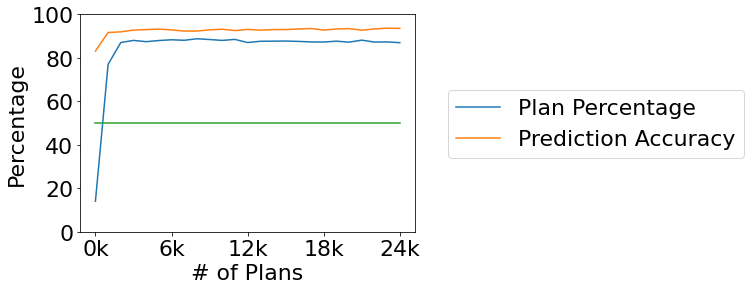

In [136]:
step = 25
models = target_model
batch_size = 64
get_line_plot([network_plan_percentages[2], network_precisions[2], np.ones(len(network_plan_percentages[2]))*50], 
              np.linspace(0, 24, 5), [f'{int(np.floor((i+1)*15*64/1000))}k' for i in np.linspace(0, 24, 5, dtype=int)],
              range(0, 101, 20), [], 
              ['Plan Percentage', 'Prediction Accuracy'], '# of Plans', 'Percentage', 
              styles=['-', '-', '-'], markers=['', '', ''])
print()

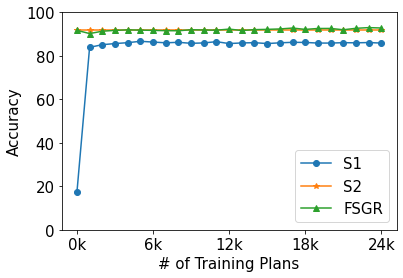

In [15]:
overall_precisions = [planner_precisions[i] if np.isnan(network_precisions[2][i]) else planner_precisions[i]*planner_plan_percentages[i]/100 + network_precisions[2][i]*network_plan_percentages[2][i]/100 
                       for i in range(len(planner_precisions))]
fig, ax = get_line_plot([only_network_precisions, [planner_precisions[0] for _ in range(len(overall_precisions))], overall_precisions], 
              np.linspace(0, 24, 5), [f'{int(np.floor((i+1)*15*64/1000))}k' for i in np.linspace(0, 24, 5, dtype=int)],
              range(0, 101, 20), [], 
              None, '# of Training Plans', 'Accuracy', 
              styles=['-', '-', '-'], markers=['o', '*', '^'])
print()
clear_output()
labels = ['S1', 'S2', 'FSGR']
ax.legend(labels, loc = 'best')
display(fig)


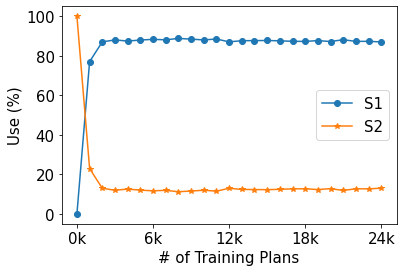

In [16]:
overall_precisions = [planner_precisions[i] if np.isnan(network_precisions[2][i]) else planner_precisions[i]*planner_plan_percentages[i]/100 + network_precisions[2][i]*network_plan_percentages[2][i]/100 
                       for i in range(len(planner_precisions))]
fig, ax = get_line_plot([network_plan_percentages[2], planner_plan_percentages], 
              np.linspace(0, 24, 5), [f'{int(np.floor((i+1)*15*64/1000))}k' for i in np.linspace(0, 24, 5, dtype=int)],
              range(0, 101, 20), [], 
              None, '# of Training Plans', 'Use (%)', 
              styles=['-', '-'], markers=['o', '*'])
print()
clear_output()
labels = ['S1', 'S2']
ax.legend(labels, loc = 'best')
display(fig)

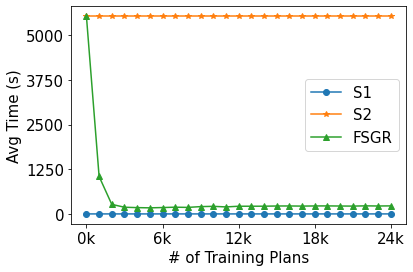

In [17]:
overall_times = [planner_times[i] if np.isnan(network_times[2][i]) else planner_times[i]*planner_plan_percentages[i]/100 + network_times[2][i]*network_plan_percentages[2][i]/100 for i in range(len(planner_times))]
fig, ax = get_line_plot([only_network_times, [planner_times[0] for _ in range(len(only_network_times))],overall_times], 
              np.linspace(0, 24, 5), [f'{int(np.floor((i+1)*15*64/1000))}k' for i in np.linspace(0, 24, 5, dtype=int)],
              np.linspace(0, 5000, 5), [], 
              None, '# of Training Plans', 'Avg Time (s)',
              styles=['-', '-', '-'], markers=['o', '*', '^'])
clear_output()
labels = ['S1', 'S2', 'FSGR']
ax.legend(labels, loc = 'best')
display(fig)
print()

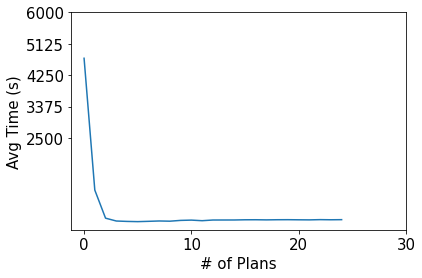

In [140]:
overall_times = [planner_times[i] if np.isnan(network_times[2][i]) else planner_times[i]*planner_plan_percentages[i]/100 + network_times[2][i]*network_plan_percentages[2][i]/100 for i in range(len(planner_times))]
get_line_plot([overall_times], 
              range(0, len(network_plan_percentages[2])+9, 10), range(step*batch_size, step*batch_size*(len(network_plan_percentages[2])+2)+1, step*batch_size*10),
              np.linspace(2500, 6000, 5), [], 
              None, '# of Plans', 'Avg Time (s)',
              styles=['-', '-', '-'], markers=['', '', ''])
print()
    

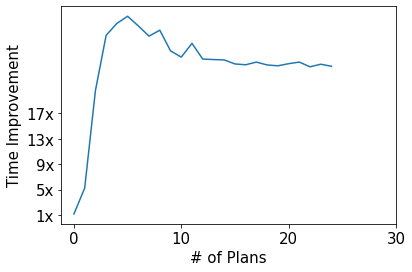

In [141]:
overall_time_improvement = [1 if np.isnan(network_times[2][i]) else planner_times[0]/(planner_times[i]*planner_plan_percentages[i]/100 + network_times[2][i]*network_plan_percentages[2][i]/100) for i in range(len(planner_times))]
max_improvement = 17
get_line_plot([overall_time_improvement], 
              range(0, len(network_plan_percentages[2])+9, 10), range(step*batch_size, step*batch_size*(len(network_plan_percentages[2])+2)+1, step*batch_size*10),
              np.linspace(1, max_improvement, 5), [f'{int(i)}x' for i in np.linspace(1, max_improvement, 5)], 
              None, '# of Plans', 'Time Improvement',
              styles=['-', '-', '-'], markers=['', '', ''])
print()

Text(3.7, 1.15, 'Pallagani\n    et al.')

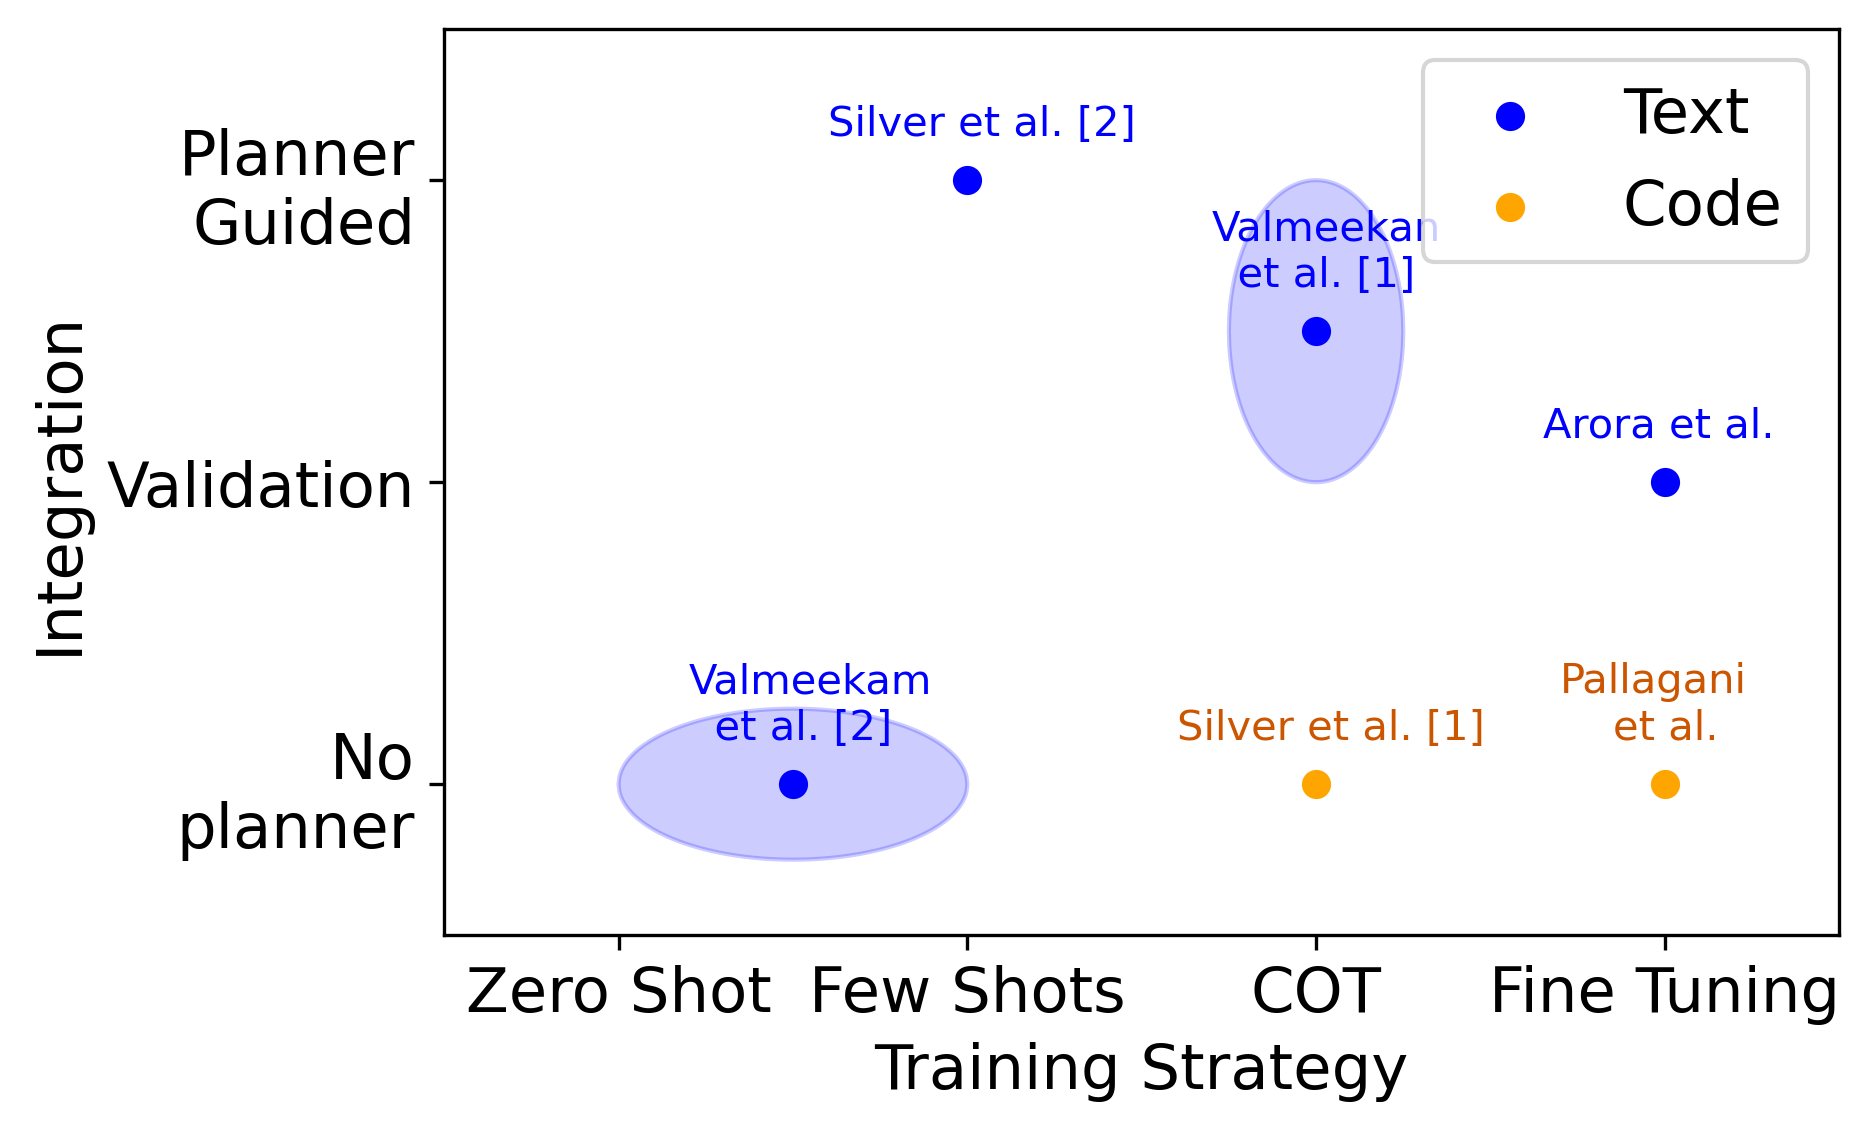

In [3]:
from utils_unibs.plots import plt

x = [1.5, 2, 3, 4]
y = [1, 3, 2.5, 2]

x1 = [4, 3]
y1 = [1, 1]
annotations = ['Valmeekam\n  et al. [2]', 'Silver et al. [2]', 'Silver et al. [1]', 'Valmeekan\n  et al. [1]', 'Pallagani\n    et al.', 'Arora et al.']

xe1 = np.linspace(1, 2, 500)
ye1 = [(32+np.sqrt(32*32-4*16*(4*x*x-12*x+24)))/32 for x in xe1]
ye1 = ye1 + [(32-np.sqrt(32*32-4*16*(4*x*x-12*x+24)))/32 for x in xe1[::-1]]

xe1 = list(xe1)
xe1 = xe1 + list(xe1[::-1])

xe2 = np.linspace(2.75, 3.25, 500)
xe2 = list(xe2)
ye2 = list([(20+np.sqrt(400-4*4*(16*x*x-96*x+168)))/8 for x in xe2])
ye2 = ye2 + [(20-np.sqrt(400-4*4*(16*x*x-96*x+168)))/8 for x in xe2[::-1]]

xe2 = xe2 + list(xe2[::-1])



fig, ax = plt.subplots(dpi=300)
ax.fill(xe1, ye1, color='blue', alpha=0.2)
ax.fill(xe2, ye2, color='blue', alpha=0.2)
plt.scatter(x, y, color='blue', label='Text')
plt.scatter(x1, y1, color='orange', label='Code')
ax.set_xticks(range(1, 5))
ax.set_xticklabels(['Zero Shot', 'Few Shots', 'COT', 'Fine Tuning'])
ax.set_yticks(range(1, 4))
ax.set_yticklabels(['No\nplanner', 'Validation', 'Planner\nGuided'])
ax.set_xlim([0.5, 4.5])
ax.set_ylim([0.5, 3.5])

ax.legend()

ax.set_xlabel('Training Strategy')
ax.set_ylabel('Integration')

ax.annotate(annotations[0], (x[0], y[0]), xytext=(x[0]-0.3, y[0]+0.15), color = 'blue')
ax.annotate(annotations[1], (x[1], y[1]), xytext=(x[1]-0.4, y[1]+0.15), color = 'blue')
ax.annotate(annotations[3], (x[2], y[2]), xytext=(x[2]-0.3, y[2]+0.15), color = 'blue')
ax.annotate(annotations[5], (x[3], y[3]), xytext=(x[3]-0.35, y[3]+0.15), color = 'blue')

ax.annotate(annotations[2], (x1[1], y1[1]), xytext=(x1[1]-0.4, y1[1]+0.15), color = '#CC5500')
ax.annotate(annotations[4], (x1[0], y1[0]), xytext=(x1[0]-0.3, y1[0]+0.15), color = '#CC5500')




Text(2.1199999999999997, 1.9, 'Silver et al. [1]')

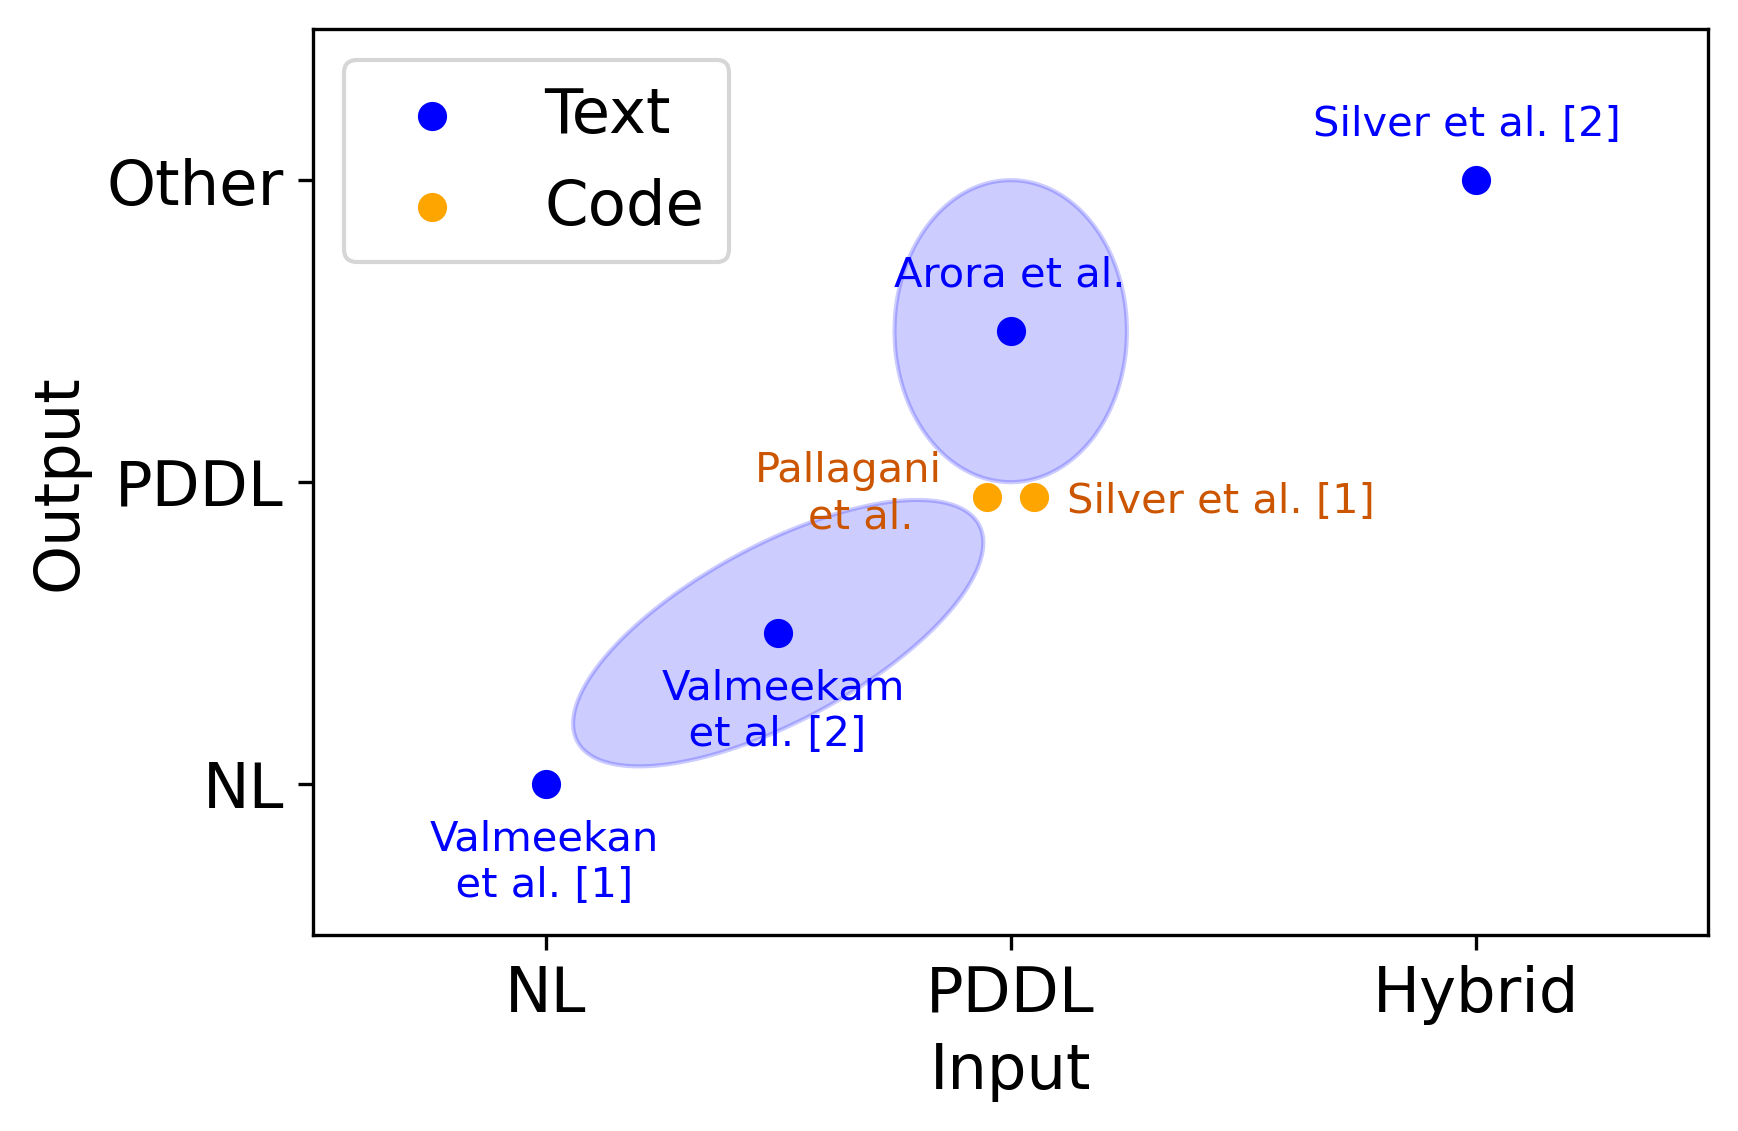

In [190]:
x = [1.5, 2, 1, 3]
y = [1.5, 2.5, 1, 3]
x1 = [2-0.05, 2+0.05]
y1 = [2-0.05, 2-0.05]
annotations = ['Valmeekam\n  et al. [2]', 'Pallagani\n    et al.', 'Silver et al. [1]', 'Arora et al.', 'Valmeekan\n  et al. [1]', 'Silver et al. [2]']

xe1 = np.linspace(1.75, 2.25, 500)
ye1 = [(5 + np.sqrt(-63 + 64*x - 16*x*x))/2 for x in xe1]
ye1 = ye1 + [(5 - np.sqrt(-63 + 64*x - 16*x*x))/2 for x in xe1[::-1]]

xe1 = list(xe1)
xe1 = xe1 + list(xe1[::-1])

xe2 = np.linspace(-0.25, 0.25, 500)
xe2 = list(xe2)
ye2 = [np.sqrt((1-16*(x)*(x)))/1.75 for x in xe2]
ye2 = ye2 + [-np.sqrt((1-16*(x)*(x)))/1.75 for x in xe2[::-1]]

xe2 = xe2 + list(xe2[::-1])

xe2r = [x/np.sqrt(2) + y/np.sqrt(2) for x, y in zip(xe2, ye2)]
ye2r = [-x/np.sqrt(2) + y/np.sqrt(2) for x, y in zip(xe2, ye2)]

xe2t = [x+1.5 for x in xe2r]
ye2t = [y+1.5 for y in ye2r]


fig, ax = plt.subplots(dpi=300)
ax.fill(xe1, ye1, color='blue', alpha=0.2)
ax.fill(xe2t, ye2t, color='blue', alpha=0.2)
plt.scatter(x, y, color = 'blue', label = 'Text')
plt.scatter(x1, y1, color = 'orange', label = 'Code')
ax.set_xticks(range(1, 4))
ax.set_xticklabels(['NL', 'PDDL', 'Hybrid'])
ax.set_yticks(range(1, 4))
ax.set_yticklabels(['NL', 'PDDL', 'Other'])
ax.set_xlim([0.5, 3.5])
ax.set_ylim([0.5, 3.5])
ax.legend()

ax.set_xlabel('Input')
ax.set_ylabel('Output')

ax.annotate(annotations[0], (x[0], y[0]), xytext=(x[0]-0.25, y[0]-0.37), color = 'blue')
ax.annotate(annotations[3], (x[1], y[1]), xytext=(x[1]-0.25, y[1]+0.15), color = 'blue')
ax.annotate(annotations[4], (x[2], y[2]), xytext=(x[2]-0.25, y[2]-0.37), color = 'blue')
ax.annotate(annotations[5], (x[3], y[3]), xytext=(x[3]-0.35, y[3]+0.15), color = 'blue')

ax.annotate(annotations[1], (x1[0], y1[0]), xytext=(x1[0]-0.5, y1[0]-0.1), color = '#CC5500')
ax.annotate(annotations[2], (x1[1], y1[1]), xytext=(x1[1]+0.07, y1[1]-0.05), color = '#CC5500')

In [193]:
headers = ['Work', 'Valid Plan Generation', 'Optimal Plans Generation' 'Names Randomization', 'Backprompting', 'Task Generalization', 'Combination with a Planner', ]
rows = []
rows.append([r'\citeauthor{valmeekam_llmstill} \cite{valmeekam_llmstill}', r'\cmark', r'\cmark', r'\xmark', r'\xmark', r'\cmark', r'\cmark'])
rows.append([r'\citeauthor{valmeekam_abilities} \cite{valmeekam_abilities}', r'\cmark', r'\xmark', r'\cmark', r'\cmark', r'\cmark', r'\cmark'])
rows.append([r'\citeauthor{arora_learning} \cite{arora_learning}', r'\cmark', r'\xmark', r'\xmark', r'\cmark', r'\xmark', r'\xmark'])
rows.append([r'\citeauthor{silver2022pddl} \cite{silver2022pddl}', r'\cmark', r'\xmark', r'\cmark', r'\cmark', r'\cmark', r'\cmark'])
rows.append([r'\citeauthor{silver2023generalized} \cite{silver2023generalized}', r'\cmark', r'\xmark', r'\cmark', r'\cmark', r'\cmark', r'\xmark'])
rows.append([r'\citeauthor{plansformer_ijcai} \cite{plansformer_ijcai, pallagani_plansformer_long} ', r'\cmark', r'\cmark', r'\cmark', r'\xmark', r'\cmark', r'\xmark'])

for h in headers[:-1]:
    print(h, end=' & ')
print(headers[-1], end=' \\\\\n')
print('\\midrule')
for row in rows:
    print(' & '.join(row), end=' \\\\\n')
print('\\bottomrule')

Work & Valid Plan Generation & Optimal Plans GenerationNames Randomization & Backprompting & Task Generalization & Combination with a Planner \\
\midrule
\citeauthor{valmeekam_llmstill} \cite{valmeekam_llmstill} & \cmark & \cmark & \xmark & \xmark & \cmark & \cmark \\
\citeauthor{valmeekam_abilities} \cite{valmeekam_abilities} & \cmark & \xmark & \cmark & \cmark & \cmark & \cmark \\
\citeauthor{arora_learning} \cite{arora_learning} & \cmark & \xmark & \xmark & \cmark & \xmark & \xmark \\
\citeauthor{silver2022pddl} \cite{silver2022pddl} & \cmark & \xmark & \cmark & \cmark & \cmark & \cmark \\
\citeauthor{silver2023generalized} \cite{silver2023generalized} & \cmark & \xmark & \cmark & \cmark & \cmark & \xmark \\
\citeauthor{plansformer_ijcai} \cite{plansformer_ijcai, pallagani_plansformer_long}  & \cmark & \cmark & \cmark & \xmark & \cmark & \xmark \\
\bottomrule
